데이터 전처리 코드

경로 정의 및 매핑

In [23]:
# === 경로 & 기본 설정 ===
INPUT_DIR = "/home/deok/Desktop/LOG_SMART_202508"  # CSV 폴더
OUT_UNITS = "units_timeseries.csv"                 # 유닛 단위 출력
OUT_ROOMS = "rooms_timeseries.csv"                 # 방 단위 출력
TZ = "Asia/Seoul"

# 공기 밀도 [kg/m^3]
AIR_DENSITY = 1.2

# 방 구성
ROOMS = {
    "Room1": [8, 3, 5],
    "Room2": [4, 1, 6],
    "Room3": [2, 7],
    "Room4": [9, 10, 11],
}

# Room 평균 Tid에서 제외할 실내기 (센서 신뢰 낮음)
EXCLUDE_TID_IDS = {5, 9}

# 원시 풍량 단계 → 실제 단계 매핑
RAW2STAGE = {5: 1, 1: 2, 2: 3, 3: 4}

# 제조사 제공 부피유량 [m^3/min]
VDOT_DEFAULT = {4: 30.89363, 3: 27.977,   2: 23.72948, 1: 21.26592}
VDOT_AUTO2   = {4: 18.97226, 3: 16.31048, 2: 13.25226, 1: 11.24177}
VDOT_AUTO10  = {4: 18.49087, 3: 15.74414, 2: 13.25226, 1: 11.24177}

# ⚠️ 2번/10번 실내기는 다른 모델, 나머지는 공통(DEFAULT)
VDOT_MODE_PER_UNIT = {
    2:  "AUTO2",
    10: "AUTO10",
}
DEFAULT_VDOT_MODE = "DEFAULT"


In [ ]:
함수 정의

In [103]:
import pandas as pd
from pathlib import Path
import numpy as np
import re

# 파일명에서 YYYYMMDD 추출
DATE_IN_FILENAME_REGEX = re.compile(r"(20\d{6})")  # ex) 20250821

def extract_date_from_filename(path: Path):
    m = DATE_IN_FILENAME_REGEX.search(path.name)
    return pd.to_datetime(m.group(1), format="%Y%m%d") if m else None

# 예시 CSV 스키마 -> 표준 컬럼명
# (Tpip_out을 표준명 'Tpip_outeh'로 통일합니다.)
RENAME_MAP = {
    "Auto Id": "auto_id",
    "Time": "time",
    "Frun": "Frun",
    "Tcon": "Tcon",
    "Tbdy": "Tbdy",
    "Tid": "Tid",
    "Tod": "Tod",
    "Hid": "Hid",
    "Tpip_in": "Tpip_in",
    "Tpip_out": "Tpip_outeh",
    "Tpip_outeh": "Tpip_outeh",  # 이미 이렇게 오는 파일도 지원
}

def build_datetime_from_filename_and_time(df: pd.DataFrame, src_path: Path, tz: str) -> pd.Series:
    file_date = extract_date_from_filename(src_path)
    if file_date is None:
        raise ValueError(f"Filename has no date: {src_path.name}")
    # 'Time' 열을 문자열로 정리 (예: 0:0:5 형태 포함)
    tstr = df["time"].astype(str).str.strip()
    full = file_date.strftime("%Y-%m-%d") + " " + tstr
    dt = pd.to_datetime(full, errors="coerce")
    dt = dt.dt.tz_localize(tz)
    return dt

def load_one_csv_schema_fixed(path: Path, tz="Asia/Seoul") -> pd.DataFrame:
    # 🔧 여기서 low_memory 제거!
    df0 = pd.read_csv(
        path,
        engine="python",        # tokenizer 에러에 관대
        on_bad_lines="skip",    # 필드 깨진 행 건너뜀
        dtype=str,              # 일단 안전하게 문자열로
        # low_memory=False      # ❌ (C 파서 전용 옵션이므로 삭제)
    )

    # 헤더 공백 제거 후 리네임
    df0.columns = [c.strip() for c in df0.columns]
    colmap = {c: RENAME_MAP[c] for c in df0.columns if c in RENAME_MAP}
    df = df0.rename(columns=colmap)

    # 필수 컬럼 체크(예시 스키마 기준)
    required = ["auto_id","time","Frun","Tcon","Tbdy","Tid","Tod"]
    missing = [c for c in required if c not in df.columns]
    if missing:
        raise ValueError(f"Missing required columns {missing} in {path.name}")

    # datetime 생성 = 파일명 날짜 + Time
    df["datetime"] = build_datetime_from_filename_and_time(df, path, tz)

    # 숫자 변환
    df["auto_id"] = pd.to_numeric(df["auto_id"], errors="coerce").astype("Int64")
    for c in ["Frun","Tcon","Tbdy","Tid","Tod","Hid","Tpip_in","Tpip_outeh"]:
        if c in df.columns:
            df[c] = pd.to_numeric(df[c], errors="coerce")

    # 정렬/선택
    keep = ["datetime","auto_id","Frun","Tcon","Tbdy","Tid","Tod","Hid","Tpip_in","Tpip_outeh"]
    present = [c for c in keep if c in df.columns]
    df = df[present].sort_values(["datetime","auto_id"]).reset_index(drop=True)
    return df


In [51]:
def compute_stage(frun_series: pd.Series) -> pd.Series:
    # 원시 Frun 값(예: 5,1,2,3)을 스테이지 1~4로 매핑
    st = frun_series.map(RAW2STAGE).astype("float")
    # 0 또는 NaN(꺼짐)은 스테이지 NaN으로 둠
    st[(frun_series==0) | (frun_series.isna())] = np.nan
    return st

# === 유량(m^3/min) 계산: auto_id별 테이블 적용 ===
def per_unit_vdot(df: pd.DataFrame) -> pd.Series:
    def row_vdot(row):
        frun = row.get("Frun", 0.0)
        st   = row.get("stage", np.nan)
        aid  = row.get("auto_id", np.nan)
        if pd.isna(st) or frun == 0 or pd.isna(aid):
            return 0.0
        st = int(st)
        if aid == 2:
            table = VDOT_AUTO2
        elif aid == 10:
            table = VDOT_AUTO10
        else:
            table = VDOT_DEFAULT
        return float(table.get(st, 0.0))
    return df.apply(row_vdot, axis=1)

# === 한 파일 로더: 이미 작성하신 load_one_csv_schema_fixed 사용 ===
# (바로 위 셀에서 정의해두신 걸 그대로 씁니다)

# === 폴더 전체 로더 ===
from pathlib import Path

def load_all_csvs_schema_fixed(root_dir: str, tz="Asia/Seoul") -> pd.DataFrame:
    root = Path(root_dir)
    files = sorted(root.glob("*.csv"))
    if not files:
        raise FileNotFoundError(f"No CSV files under {root_dir}")
    dfs = []
    for p in files:
        try:
            dfp = load_one_csv_schema_fixed(p, tz=tz)
            dfs.append(dfp)
        except Exception as e:
            print(f"[WARN] Skip {p.name}: {e}")
    if not dfs:
        raise ValueError("No valid CSVs were loaded.")
    df = (pd.concat(dfs, ignore_index=True)
            .dropna(subset=["datetime"])
            .sort_values(["datetime","auto_id"])
            .reset_index(drop=True))
    return df

실내기별로 전처리

In [52]:
def enrich_units(df: pd.DataFrame) -> pd.DataFrame:
    d = df.copy()

    # 단계 매핑
    d["stage"] = compute_stage(d["Frun"])

    # 부피유량/질량유량
    d["vdot_m3_min"] = per_unit_vdot(d)
    d["mdot_kg_s"] = AIR_DENSITY * (d["vdot_m3_min"] / 60.0)

    # ON/OFF: Tcon != 0 and Frun != 0
    tcon_nz = d["Tcon"].fillna(0.0)
    frun_nz = d["Frun"].fillna(0.0)
    d["is_on"] = (tcon_nz != 0) & (frun_nz != 0)

    return d

# 실행
df_units_raw = load_all_csvs_schema_fixed(INPUT_DIR)
df_units = enrich_units(df_units_raw)

print(df_units.shape)
df_units.head(10)


(4798801, 14)


datetime  auto_id  Frun  Tcon  Tbdy   Tid   Tod   Hid  \
0 2025-08-01 13:25:07+09:00        1     0   0.0  19.6  27.3  36.3  47.0   
1 2025-08-01 13:25:07+09:00        2     5  21.0  28.0  28.0  36.3  54.0   
2 2025-08-01 13:25:07+09:00        3     0   0.0  28.4  28.4  36.3  42.0   
3 2025-08-01 13:25:07+09:00        4     5  21.0  21.0  27.3  36.3  42.0   
4 2025-08-01 13:25:07+09:00        5     5  21.0  22.3  22.3  36.3  48.0   
5 2025-08-01 13:25:07+09:00        6     0   0.0  26.6  26.6  36.3  43.0   
6 2025-08-01 13:25:07+09:00        7     0   0.0  26.9  26.9  36.3  54.0   
7 2025-08-01 13:25:07+09:00        8     0   0.0  29.1  29.1  36.3  43.0   
8 2025-08-01 13:25:07+09:00        9     0   0.0  25.8  25.8  36.3  49.0   
9 2025-08-01 13:25:07+09:00       10     5  21.0  23.0  25.1  36.3  44.0   

   Tpip_in  Tpip_outeh  stage  vdot_m3_min  mdot_kg_s  is_on  
0      6.0         9.1    NaN      0.00000   0.000000  False  
1      9.4        15.7    1.0     11.24177   0.224835   True  
2     22.5        23.2    NaN      0.00000   0.000000  False  
3      9.4        12.4    1.0     21.26592   0.425318   True  
4      8.7        11.4    1.0     21.26592   0.425318   True  
5     13.7        19.4    NaN      0.00000   0.000000  False  
6     14.7        18.7    NaN      0.00000   0.000000  False  
7     22.2        22.8    NaN      0.00000   0.000000  False  
8     24.2        24.6    NaN      0.00000   0.000000  False  
9      8.1        12.1    1.0     11.24177   0.224835   True

방 별로 전처리

In [53]:
import numpy as np
import pandas as pd

def gb_mean_min1(gb_series: pd.core.groupby.SeriesGroupBy) -> pd.Series:
    """그룹 내 유효값이 1개 이상이면 평균, 모두 NaN이면 NaN."""
    return gb_series.apply(lambda s: s.mean(skipna=True) if s.notna().any() else np.nan)

def gb_sum_min1(gb_series: pd.core.groupby.SeriesGroupBy) -> pd.Series:
    """그룹 내 유효값이 1개 이상이면 합, 모두 NaN이면 NaN (0으로 떨어지는 것 방지)."""
    return gb_series.apply(lambda s: s.sum(skipna=True) if s.notna().any() else np.nan)



def aggregate_rooms(df_units: pd.DataFrame) -> pd.DataFrame:
    records = []
    dfu = df_units.copy()

    for room, unit_ids in ROOMS.items():
        sub = dfu[dfu["auto_id"].isin(unit_ids)].copy()
        if sub.empty:
            continue

        # 방별 Tod 평균, any_on
        agg_tod = gb_mean_min1(sub.groupby("datetime")["Tod"])
        any_on  = sub.groupby("datetime")["is_on"].any()

        # Room 평균 Tid (5,9 제외)
        valid_ids = [uid for uid in unit_ids if uid not in EXCLUDE_TID_IDS]
        sub_tid = sub[sub["auto_id"].isin(valid_ids)]
        tid_room = gb_mean_min1(sub_tid.groupby("datetime")["Tid"])

        # ON 유닛만으로 mdot 합계, mdot*(Tid_room - Tbdy) 합계
        on_rows = sub[sub["is_on"]]
        mdot_sum_on = gb_sum_min1(on_rows.groupby("datetime")["mdot_kg_s"])

        tbdy_on = on_rows.set_index("datetime")[["auto_id", "Tbdy", "mdot_kg_s"]]
        tmp = tbdy_on.join(tid_room.rename("Tid_room"), how="left")
        tmp["mdot_Tdiff"] = tmp["mdot_kg_s"] * (tmp["Tid_room"] - tmp["Tbdy"])
        mdot_tdiff_sum = gb_sum_min1(tmp.groupby("datetime")["mdot_Tdiff"])

        room_df = pd.DataFrame({
            "room": room,
            "Tod_room": agg_tod,
            "Tid_room": tid_room,
            "any_on": any_on,
            "mdot_sum_on": mdot_sum_on,
            "mdot_Tdiff_sum": mdot_tdiff_sum,
        }).reset_index()

        # 방 내 모든 실내기가 OFF인 시각은 제외
        room_df = room_df[room_df["any_on"].fillna(False)]
        records.append(room_df)

    if not records:
        return pd.DataFrame(columns=["datetime","room","Tod_room","Tid_room","any_on","mdot_sum_on","mdot_Tdiff_sum"])

    rooms_df = (pd.concat(records, ignore_index=True)
                  .sort_values(["datetime","room"])
                  .reset_index(drop=True))

    # 타임존 보정(가능 시)
    try:
        if rooms_df["datetime"].dtype == "datetime64[ns]":
            rooms_df["datetime"] = rooms_df["datetime"].dt.tz_localize(TZ)
    except Exception:
        pass

    return rooms_df
    
df_rooms = aggregate_rooms(df_units)
print(df_rooms.shape)
df_rooms.head(10)


(323655, 7)


datetime   room  Tod_room   Tid_room  any_on  mdot_sum_on  \
0 2025-08-01 13:25:07+09:00  Room1      36.3  28.750000    True     0.425318   
1 2025-08-01 13:25:07+09:00  Room2      36.3  27.066667    True     0.425318   
2 2025-08-01 13:25:07+09:00  Room3      36.3  27.450000    True     0.224835   
3 2025-08-01 13:25:07+09:00  Room4      36.3  24.400000    True     0.650154   
4 2025-08-01 13:25:12+09:00  Room1      36.3  28.750000    True     0.425318   
5 2025-08-01 13:25:12+09:00  Room2      36.3  27.066667    True     0.425318   
6 2025-08-01 13:25:12+09:00  Room3      36.3  27.450000    True     0.224835   
7 2025-08-01 13:25:12+09:00  Room4      36.3  24.400000    True     0.650154   
8 2025-08-01 13:25:17+09:00  Room1      36.3  28.750000    True     0.425318   
9 2025-08-01 13:25:17+09:00  Room2      36.3  27.066667    True     0.425318   

   mdot_Tdiff_sum  
0        2.743304  
1        2.580265  
2       -0.123659  
3        1.930979  
4        2.743304  
5        2.580265  
6       -0.123659  
7        1.930979  
8        2.743304  
9        2.580265

In [12]:
import numpy as np, pandas as pd, torch, torch.nn as nn

# IRK 계수 (Gauss–Legendre 2-stage)
sqrt3 = np.sqrt(3.0)
c1, c2 = 0.5 - sqrt3/6.0, 0.5 + sqrt3/6.0
A = np.array([[0.25, 0.25 - sqrt3/6.0],
              [0.25 + sqrt3/6.0, 0.25]], dtype=np.float64)
b = np.array([0.5, 0.5], dtype=np.float64)
DELTA = 30.0  # seconds

# 보간: 타임스탬프(초) 기준 선형 보간
def lin_interp(t_grid_sec, y_grid, t_query_sec):
    return np.interp(t_query_sec, t_grid_sec, y_grid, left=np.nan, right=np.nan)

# 연속 5초 구간(세션)에서 30초 윈도우 만들기
def build_windows_from_room_df(df_room: pd.DataFrame, room_name: str):
    """df_room: 단일 room의 df_rooms 부분집합 (any_on=True만 들어있음)"""
    d = df_room.sort_values("datetime").copy()
    t = pd.to_datetime(d["datetime"]).view("int64") // 10**9  # to epoch seconds
    # 연속 5초 구간 마킹
    dt = np.diff(t.values, prepend=t.values[0])
    new_seq = dt != 5  # 5초가 아니면 새 세션 시작
    seq_id = np.cumsum(new_seq)

    # 결과 저장
    windows = []
    for sid, g in d.groupby(seq_id):
        if len(g) < 7:  # 30초(=6스텝) 만들려면 최소 7포인트 필요
            continue
        tg = (pd.to_datetime(g["datetime"]).view("int64") // 10**9).values.astype(float)
        T  = g["Tid_room"].values.astype(float)
        Tod = g["Tod_room"].values.astype(float)
        M   = g["mdot_Tdiff_sum"].values.astype(float)

        # 결측이 있으면 해당 윈도우 건너뜀
        for i in range(len(g) - 6):
            t0 = tg[i]
            t1 = tg[i+6]
            # 스테이지 시각
            ts1 = t0 + c1*DELTA
            ts2 = t0 + c2*DELTA

            T0  = T[i]
            T1  = T[i+6]
            Tod1 = lin_interp(tg, Tod, ts1); Tod2 = lin_interp(tg, Tod, ts2)
            M1   = lin_interp(tg, M,   ts1); M2   = lin_interp(tg, M,   ts2)
            # 유효성 체크
            if np.any(np.isnan([T0, T1, Tod1, Tod2, M1, M2])):
                continue
            windows.append([room_name, t0, t1, T0, Tod1, Tod2, M1, M2, T1])

    if not windows:
        return pd.DataFrame(columns=["room","t0","t1","T0","Tod1","Tod2","M1","M2","T1"])
    return pd.DataFrame(windows, columns=["room","t0","t1","T0","Tod1","Tod2","M1","M2","T1"])

# 전체 room에서 윈도우 뽑기
def build_all_windows(df_rooms: pd.DataFrame):
    out = []
    for room, g in df_rooms.groupby("room"):
        out.append(build_windows_from_room_df(g, room))
    win = pd.concat(out, ignore_index=True) if out else pd.DataFrame()
    return win

# df_rooms에서 윈도우 생성
assert set(["datetime","room","Tid_room","Tod_room","mdot_Tdiff_sum"]).issubset(df_rooms.columns)
windows_df = build_all_windows(df_rooms)
print("windows:", windows_df.shape)
windows_df.head()


/tmp/ipykernel_284110/1752067909.py:19: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  t = pd.to_datetime(d["datetime"]).view("int64") // 10**9  # to epoch seconds
/tmp/ipykernel_284110/1752067909.py:30: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  tg = (pd.to_datetime(g["datetime"]).view("int64") // 10**9).values.astype(float)
/tmp/ipykernel_284110/1752067909.py:30: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  tg = (pd.to_datetime(g["datetime"]).view("int64") // 10**9).values.astype(float)
/tmp/ipykernel_284110/1752067909.py:30: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  tg = (pd.to_datetime(g["datetime"]).view("int64")

windows: (322997, 9)


/tmp/ipykernel_284110/1752067909.py:30: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  tg = (pd.to_datetime(g["datetime"]).view("int64") // 10**9).values.astype(float)
/tmp/ipykernel_284110/1752067909.py:30: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  tg = (pd.to_datetime(g["datetime"]).view("int64") // 10**9).values.astype(float)


room            t0            t1     T0       Tod1       Tod2        M1  \
0  Room1  1.754022e+09  1.754022e+09  28.75  36.300000  36.080385  2.743304   
1  Room1  1.754022e+09  1.754022e+09  28.75  36.300000  36.000000  2.743304   
2  Room1  1.754022e+09  1.754022e+09  28.75  36.300000  36.000000  2.743304   
3  Room1  1.754022e+09  1.754022e+09  28.75  36.219615  36.000000  2.743304   
4  Room1  1.754022e+09  1.754022e+09  28.75  36.000000  36.073205  2.743304   

         M2     T1  
0  2.743304  28.75  
1  2.743304  28.75  
2  2.743304  28.75  
3  2.743304  28.75  
4  2.743304  28.75

In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Dataset
class IRKDataset(torch.utils.data.Dataset):
    def __init__(self, df):
        X = df[["T0","Tod1","Tod2","M1","M2"]].values.astype(np.float32)
        y = df[["T1"]].values.astype(np.float32)
        self.X = torch.from_numpy(X)
        self.y = torch.from_numpy(y)
    def __len__(self): return len(self.X)
    def __getitem__(self, i): return self.X[i], self.y[i]

# MLP: 입력 5 -> 은닉 -> 출력 3 (Y1, Y2, T1)
class IRKNet(nn.Module):
    def __init__(self, hid=64):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(5, hid), nn.ReLU(),
            nn.Linear(hid, hid), nn.ReLU(),
            nn.Linear(hid, 3),
        )
        # 물리 파라미터 (학습 대상)
        self.lam1  = nn.Parameter(torch.tensor(0.0))    # free
        self.lam2r = nn.Parameter(torch.tensor(0.1))    # lam2 = -softplus(lam2r)
        self.lam3  = nn.Parameter(torch.tensor(0.0))    # free
        self.lam4r = nn.Parameter(torch.tensor(0.01))   # lam4 = softplus(lam4r)
    def forward(self, X):
        # X: [B,5] = [T0, Tod1, Tod2, M1, M2]
        Y = self.net(X)   # [B,3] -> Y1, Y2, T1
        Y1, Y2, T1 = Y[:,0:1], Y[:,1:2], Y[:,2:3]
        return Y1, Y2, T1
    def phys_params(self):
        lam1 = self.lam1
        lam2 = -torch.nn.functional.softplus(self.lam2r)
        lam3 = self.lam3
        lam4 = torch.nn.functional.softplus(self.lam4r) + 1e-8
        return lam1, lam2, lam3, lam4

def F_of(T, Tod, M, lam1, lam2, lam3, lam4):
    return lam1*Tod + lam2*T + lam3 - lam4*M

def irk_loss(model, X, y):
    """
    X: [B,5] = [T0, Tod1, Tod2, M1, M2]
    y: [B,1] = [T1_meas]
    """
    T0, Tod1, Tod2, M1, M2 = X[:,0:1], X[:,1:2], X[:,2:3], X[:,3:4], X[:,4:5]
    Y1, Y2, T1_pred = model(X)
    lam1, lam2, lam3, lam4 = model.phys_params()
    # IRK residuals
    # stage vectorization
    F1 = F_of(Y1, Tod1, M1, lam1, lam2, lam3, lam4)
    F2 = F_of(Y2, Tod2, M2, lam1, lam2, lam3, lam4)
    # R^(j) = Yj - T0 - Δ Σ_k a_{jk} Fk
    A_t = torch.tensor(A, dtype=X.dtype, device=X.device)  # 2x2
    Fstk = torch.cat([F1, F2], dim=1)  # [B,2]
    Ystk = torch.cat([Y1, Y2], dim=1)  # [B,2]
    T0rep = T0.repeat(1,2)             # [B,2]
    R_stage = Ystk - T0rep - DELTA * (Fstk @ A_t.T)
    # R_out = T1 - T0 - Δ Σ_k b_k Fk
    b_t = torch.tensor(b, dtype=X.dtype, device=X.device).view(2,1)  # [2,1]
    R_out = T1_pred - T0 - DELTA * (Fstk @ b_t)

    L_irk = (R_stage**2).mean() + (R_out**2).mean()
    L_data = ((T1_pred - y)**2).mean()

    # 물리 제약 가벼운 정규화(선택): lam4>0, lam2<0는 재매개변수화로 이미 보장
    L_reg = 1e-6*(model.lam1**2 + model.lam3**2)

    L_total = L_data + L_irk + L_reg
    return L_total, {"L_data": L_data.item(), "L_irk": L_irk.item()}

# 데이터 분할 (train/val)
from sklearn.model_selection import train_test_split
train_df, val_df = train_test_split(windows_df, test_size=0.2, random_state=42, shuffle=True)

train_ds = IRKDataset(train_df);  val_ds = IRKDataset(val_df)
train_loader = torch.utils.data.DataLoader(train_ds, batch_size=512, shuffle=True)
val_loader   = torch.utils.data.DataLoader(val_ds,   batch_size=1024, shuffle=False)

# 학습
model = IRKNet(hid=64).to(device)
opt = torch.optim.Adam(model.parameters(), lr=1e-3)

EPOCHS = 50
for ep in range(1, EPOCHS+1):
    model.train()
    losses = []
    for Xb, yb in train_loader:
        Xb, yb = Xb.to(device), yb.to(device)
        opt.zero_grad()
        L, comp = irk_loss(model, Xb, yb)
        L.backward()
        opt.step()
        losses.append(comp)
    if ep % 5 == 0 or ep == 1:
        # validation
        model.eval()
        with torch.no_grad():
            Xv = val_ds.X.to(device); yv = val_ds.y.to(device)
            Lv, compv = irk_loss(model, Xv, yv)
            lam1, lam2, lam3, lam4 = model.phys_params()
            print(f"[{ep:03d}] "
                  f"train L_data={np.mean([d['L_data'] for d in losses]):.4f} "
                  f"L_irk={np.mean([d['L_irk'] for d in losses]):.4f} | "
                  f"val total={Lv.item():.4f} "
                  f"(lam1={lam1.item():.4f}, lam2={lam2.item():.4f}, lam3={lam3.item():.4f}, lam4={lam4.item():.6f})")


[001] train L_data=80.6920 L_irk=335.4503 | val total=18.4649 (lam1=0.0048, lam2=-0.7680, lam3=0.0038, lam4=0.656758)
[005] train L_data=1.0939 L_irk=10.1927 | val total=10.3564 (lam1=0.0165, lam2=-0.8971, lam3=0.0094, lam4=0.653497)
[010] train L_data=0.5714 L_irk=6.1648 | val total=6.6429 (lam1=0.0347, lam2=-1.1741, lam3=0.0200, lam4=0.646870)
[015] train L_data=0.3095 L_irk=3.8880 | val total=3.3216 (lam1=0.0448, lam2=-1.5459, lam3=0.0256, lam4=0.641412)
[020] train L_data=0.1854 L_irk=2.6242 | val total=2.2463 (lam1=0.0491, lam2=-1.9670, lam3=0.0282, lam4=0.637992)
[025] train L_data=0.1174 L_irk=1.8799 | val total=1.3166 (lam1=0.0516, lam2=-2.4424, lam3=0.0300, lam4=0.635697)
[030] train L_data=0.0895 L_irk=1.6183 | val total=1.5314 (lam1=0.0530, lam2=-2.7828, lam3=0.0313, lam4=0.632306)
[035] train L_data=0.0753 L_irk=1.3221 | val total=0.9701 (lam1=0.0542, lam2=-3.0333, lam3=0.0322, lam4=0.628696)
[040] train L_data=0.0683 L_irk=1.1821 | val total=0.9624 (lam1=0.0552, lam2=-3.22

In [14]:
model.eval()
with torch.no_grad():
    Xv = val_ds.X.to(device)
    _, _, T1_pred = model(Xv)
    T1_meas = val_ds.y.to(device)
    mse = torch.mean((T1_pred - T1_meas)**2).item()
    print("VAL MSE (30s ahead):", mse)

# 파라미터 해석
lam1, lam2, lam3, lam4 = model.phys_params()
Cp_over_Cair = lam4.item()          # = c_p / C_air
# c_p를 1.005 kJ/kg/K ~= 1005 J/kg/K로 잡으면 C_air ≈ c_p / lam4
c_p = 1005.0
C_air_est = c_p / max(lam4.item(), 1e-8)
print(f"lam1={lam1.item():.4f}, lam2={lam2.item():.4f}, lam3={lam3.item():.4f}, lam4={lam4.item():.6f}")
print(f"Estimated C_air ≈ {C_air_est:.2f} J/K")


VAL MSE (30s ahead): 0.05313568189740181
lam1=0.0567, lam2=-3.5109, lam3=0.0336, lam4=0.617877
Estimated C_air ≈ 1626.54 J/K


In [21]:
import numpy as np, pandas as pd

# 안전한 epoch(sec) 변환 (Series/Index/스칼라 모두 지원)
def to_epoch_sec(ts):
    dt = pd.to_datetime(ts, utc=True)
    if isinstance(dt, (pd.Series, pd.Index, np.ndarray)):
        return pd.to_datetime(dt).astype("int64") // 10**9
    else:
        return int(pd.to_datetime(dt).value // 10**9)

# 5초 간격으로 연속 구간(세션) 분리
def group_contiguous_5s(dts):
    t = to_epoch_sec(dts).values
    dt = np.diff(t, prepend=t[0])
    return np.cumsum(dt != 5)

# 방별 세션 시작점부터 최대 40분(roll_min)까지 30초 그리드로 롤아웃용 윈도우 구성
def make_rollout_windows_from_rooms(df_rooms, roll_min=40):
    ROLL_SEC = roll_min * 60
    wins = []
    for room, g in df_rooms.groupby("room"):
        g = g.sort_values("datetime").copy()
        sid = group_contiguous_5s(g["datetime"])
        for _, seg in g.groupby(sid):
            if seg.empty:
                continue
            t0 = to_epoch_sec(seg["datetime"].iloc[0])
            t_end = to_epoch_sec(seg["datetime"].iloc[-1])
            t_stop = min(t0 + ROLL_SEC, t_end)
            t_grid = np.arange(t0, t_stop + 1e-6, DELTA, dtype=float)
            if len(t_grid) < 2:
                continue

            tg   = to_epoch_sec(seg["datetime"]).values.astype(float)
            T    = seg["Tid_room"].values.astype(float)
            Tod  = seg["Tod_room"].values.astype(float)
            M    = seg["mdot_Tdiff_sum"].values.astype(float)

            # 실측 온도를 30초 그리드로 보간 (초점: 비교를 위한 동일 시간축)
            T_meas = np.interp(t_grid, tg, T, left=np.nan, right=np.nan)

            wins.append({
                "room": room,
                "t_grid": t_grid,   # 30s grid
                "tg": tg,           # 5s grid
                "Tod": Tod,
                "M": M,
                "T_meas": T_meas
            })
    return wins


In [25]:
import numpy as np, pandas as pd

# 안전한 epoch(sec) 변환 (Series/Index/스칼라 모두 지원)
def to_epoch_sec(ts):
    dt = pd.to_datetime(ts, utc=True)
    if isinstance(dt, (pd.Series, pd.Index, np.ndarray)):
        return pd.to_datetime(dt).astype("int64") // 10**9
    else:
        return int(pd.to_datetime(dt).value // 10**9)

# 5초 간격 연속 구간(세션) ID 부여
def group_contiguous_5s(dts):
    t = to_epoch_sec(dts).values
    dt = np.diff(t, prepend=t[0])
    return np.cumsum(dt != 5)

# 방별 세션 시작점부터 최대 roll_min(분)까지 30초 그리드로 윈도우 구성
def make_rollout_windows_from_rooms(df_rooms, roll_min=40):
    ROLL_SEC = roll_min * 60
    wins = []
    for room, g in df_rooms.groupby("room"):
        g = g.sort_values("datetime").copy()
        sid = group_contiguous_5s(g["datetime"])
        for _, seg in g.groupby(sid):
            if seg.empty:
                continue
            t0   = to_epoch_sec(seg["datetime"].iloc[0])
            t_end= to_epoch_sec(seg["datetime"].iloc[-1])
            t_stop = min(t0 + ROLL_SEC, t_end)
            t_grid = np.arange(t0, t_stop + 1e-6, DELTA, dtype=float)
            if len(t_grid) < 2:
                continue

            tg   = to_epoch_sec(seg["datetime"]).values.astype(float)
            T    = seg["Tid_room"].values.astype(float)
            Tod  = seg["Tod_room"].values.astype(float)
            M    = seg["mdot_Tdiff_sum"].values.astype(float)

            # 실측 온도를 30초 그리드로 보간 (비교용 동일 시간축)
            T_meas = np.interp(t_grid, tg, T, left=np.nan, right=np.nan)

            wins.append({
                "room": room,
                "t_grid": t_grid,   # 30s grid
                "tg": tg,           # 5s grid
                "Tod": Tod,
                "M": M,
                "T_meas": T_meas
            })
    return wins

# 윈도우 만들기 (필요 시 roll_min 변경 가능)
roll_windows_1step = make_rollout_windows_from_rooms(df_rooms, roll_min=40)
print("n_windows (train, 1-step):", len(roll_windows_1step))



n_windows (train, 1-step): 103


In [26]:
import torch

# IRK 텐서 상수
def _irk_consts(device, dtype=torch.float32):
    A_t = torch.tensor(A, dtype=dtype, device=device)
    b_t = torch.tensor(b, dtype=dtype, device=device).view(2,1)
    return A_t, b_t

@torch.no_grad()
def rollout_window_1step(model, win):
    """
    1-step(교사강제) 예측:
      매 스텝 초기 상태 T0는 '실측'을 사용하고,
      외생입력(Tod, M)은 실측을 보간해서 사용.
    """
    device = next(model.parameters()).device
    A_t, b_t = _irk_consts(device)

    t_grid = win["t_grid"]
    tg, Tod, M = win["tg"], win["Tod"], win["M"]
    T_meas = win["T_meas"]

    T_pred = np.zeros_like(t_grid, dtype=np.float64)
    T_pred[0] = T_meas[0]  # 첫 스텝은 실측으로 시드

    for k in range(len(t_grid)-1):
        # 1-step: 매 스텝 T0는 실측 사용
        T0_for_step = T_meas[k]

        ts1, ts2 = t_grid[k] + c1*DELTA, t_grid[k] + c2*DELTA
        Tod1 = np.interp(ts1, tg, Tod, left=np.nan, right=np.nan)
        Tod2 = np.interp(ts2, tg, Tod, left=np.nan, right=np.nan)
        M1   = np.interp(ts1, tg, M,   left=np.nan, right=np.nan)
        M2   = np.interp(ts2, tg, M,   left=np.nan, right=np.nan)
        if np.any(np.isnan([Tod1, Tod2, M1, M2, T0_for_step])):
            T_pred[k+1:] = np.nan
            break

        X = torch.tensor([[T0_for_step, Tod1, Tod2, M1, M2]], dtype=torch.float32, device=device)
        # 네트워크는 Y1,Y2,(선택)T1을 출력하지만, 최종 T1은 IRK로 일관 계산
        Y1, Y2, _ = model(X)
        lam1, lam2, lam3, lam4 = model.phys_params()

        F1 = F_of(Y1, X[:,1:2], X[:,3:4], lam1, lam2, lam3, lam4)
        F2 = F_of(Y2, X[:,2:3], X[:,4:5], lam1, lam2, lam3, lam4)
        Fstk = torch.cat([F1, F2], dim=1)
        T1_rk = X[:,0:1] + DELTA * (Fstk @ b_t)

        T_pred[k+1] = float(T1_rk.squeeze().cpu().numpy())

    mask = ~np.isnan(T_pred) & ~np.isnan(T_meas)
    rmse = np.sqrt(np.mean((T_pred[mask] - T_meas[mask])**2)) if mask.any() else np.nan
    return T_pred, rmse

# 전체 윈도우 평가 요약
model.eval()
rows_1s, series_1s = [], []
for i, w in enumerate(roll_windows_1step):
    Tp, rmse = rollout_window_1step(model, w)
    rows_1s.append({
        "idx": i,
        "room": w["room"],
        "start": pd.to_datetime(w["t_grid"][0], unit="s"),
        "minutes": (len(w["t_grid"])-1)*DELTA/60.0,
        "rmse_C": rmse
    })
    series_1s.append({
        "idx": i, "room": w["room"],
        "time": pd.to_datetime(w["t_grid"], unit="s"),
        "T_meas": w["T_meas"], "T_pred": Tp
    })

summary_1s = pd.DataFrame(rows_1s).sort_values(["room","start"]).reset_index(drop=True)
print(summary_1s.head(10))
print(summary_1s.groupby("room")["rmse_C"].describe())

   idx   room               start  minutes    rmse_C
0    0  Room1 2025-08-01 04:25:07      1.0  0.457543
1    1  Room1 2025-08-01 04:27:34     40.0  0.549744
2    2  Room1 2025-08-01 05:33:08     11.5  0.529894
3    3  Room1 2025-08-04 00:10:40     40.0  0.738565
4    4  Room1 2025-08-05 03:19:00     40.0  0.489334
5    5  Room1 2025-08-06 01:46:10     40.0  0.500812
6    6  Room1 2025-08-07 01:07:35     40.0  0.507444
7    7  Room1 2025-08-08 01:14:00     40.0  0.447697
8    8  Room1 2025-08-11 01:20:24     40.0  0.528170
9    9  Room1 2025-08-12 01:09:39     40.0  0.549273
       count      mean       std       min       25%       50%       75%  \
room                                                                       
Room1   25.0  0.514694  0.060976  0.415833  0.486703  0.502987  0.531143   
Room2   27.0  0.489436  0.060028  0.380478  0.465860  0.472756  0.493330   
Room3   24.0  0.558595  0.216814  0.352695  0.474993  0.543302  0.555430   
Room4   27.0  0.512861  0.042201  0.4

best_per_room idx: [65, 44, 76, 14]


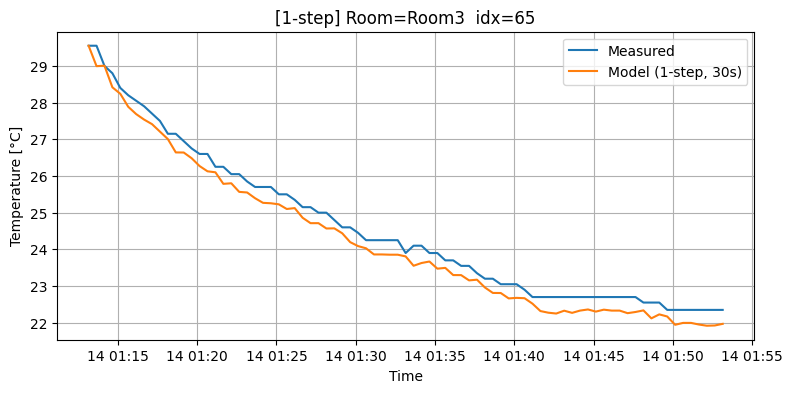

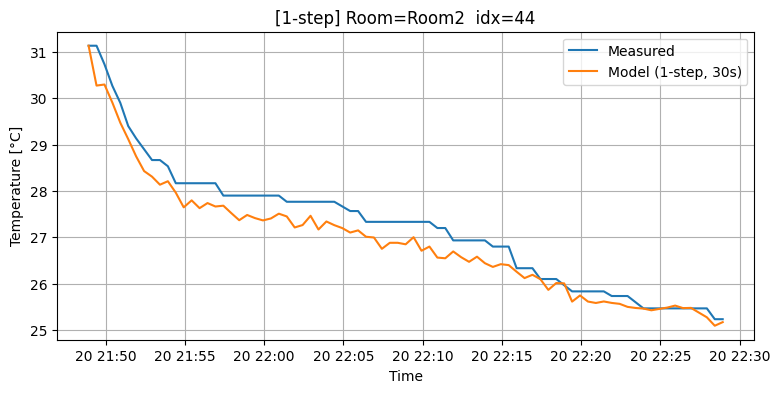

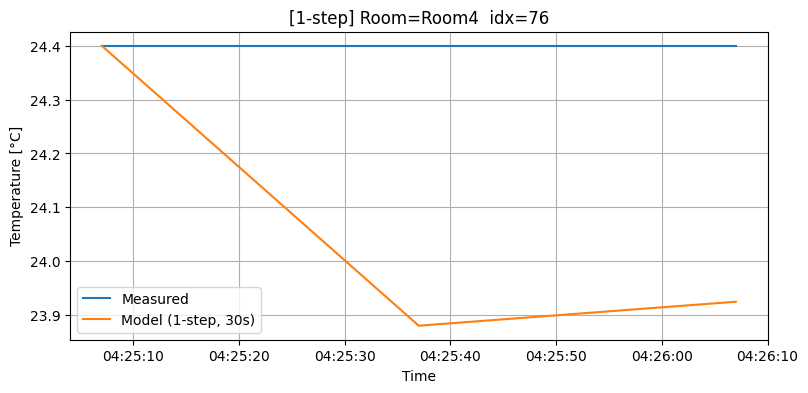

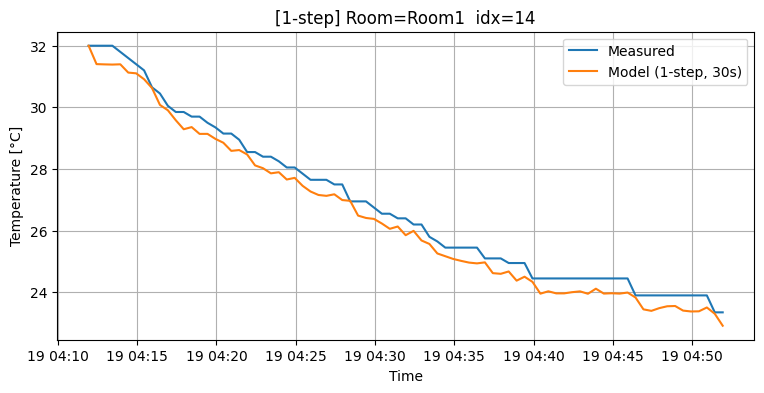

In [27]:
import matplotlib.pyplot as plt

def plot_window_1step(idx):
    s = next(s for s in series_1s if s["idx"] == idx)
    t = s["time"]; Tm = s["T_meas"]; Tp = s["T_pred"]
    plt.figure(figsize=(9,4))
    plt.plot(t, Tm, label="Measured")
    plt.plot(t, Tp, label="Model (1-step, 30s)")
    plt.title(f"[1-step] Room={s['room']}  idx={idx}")
    plt.xlabel("Time"); plt.ylabel("Temperature [°C]")
    plt.grid(True); plt.legend()
    plt.show()

# 예시: 각 방에서 RMSE 가장 낮은 1개 윈도우를 그려보기
best_per_room = (summary_1s.sort_values("rmse_C")
                            .dropna(subset=["rmse_C"])
                            .groupby("room")
                            .head(1)["idx"]
                            .tolist())
print("best_per_room idx:", best_per_room)
for i in best_per_room:
    plot_window_1step(i)

# 또는 특정 인덱스를 수동 플롯
# plot_window_1step(0)

발리드셋 전처리

In [56]:
import re, numpy as np, pandas as pd
from pathlib import Path

TZ = "Asia/Seoul"  # 학습 때 쓰던 값 유지

# ---- 별칭 사전(대소문자/공백/언더스코어 무시하고 매칭) ----
ALIASES = {
    "auto_id": ["auto_id","auto id","autoid","unit_id","id","autoID","AUTO_ID","Auto Id","AutoID"],
    "time":    ["time","Time","TIME","log_time","logtime"],
    "datetime":["datetime","timestamp","date_time","date-time"],
    "Frun":    ["frun","FRUN","fan","fan_run","fan stage","fan_stage","FrunRaw","frun_raw"],
    "Tcon":    ["tcon","Tcon","compressor","comp","compressor_on"],
    "Tbdy":    ["tbdy","Tbdy","tdischarge","discharge_temp","Tout","T_out","Tdischarge","discharge"],
    "Tid":     ["tid","Tid","tin","indoor_temp","T_in","Indoor Temp","indoor"],
    "Tod":     ["tod","Tod","toutdoor","outdoor_temp","T_outdoor","Outdoor Temp","outdoor"],
    "Hid":     ["hid","Hid","humidity","rh","relative_humidity"],
    "Tpip_in": ["tpip_in","Tpip_in","t_pipe_in","tpipin","TPI"],
    "Tpip_outeh": ["tpip_outeh","Tpip_outeh","tpip_out","Tpip_out","t_pipe_out","tpipout","TPO"],
}

REQ = ["auto_id","Frun","Tcon","Tbdy","Tid","Tod"]  # 최소 필요 컬럼

DATE_IN_FILENAME_REGEX = re.compile(r"(20\d{6})")  # YYYYMMDD

def _norm(s: str) -> str:
    return re.sub(r"[^a-z0-9]", "", s.lower())

def rename_with_aliases(df: pd.DataFrame) -> pd.DataFrame:
    # 현재 컬럼을 정규화→원래이름 사전
    cur = {_norm(c): c for c in df.columns}
    ren = {}
    for canon, alist in ALIASES.items():
        for a in alist:
            key = _norm(a)
            if key in cur:
                ren[cur[key]] = canon
                break
    return df.rename(columns=ren)

def extract_date_from_filename(path: Path):
    m = DATE_IN_FILENAME_REGEX.search(path.name)
    return pd.to_datetime(m.group(1), format="%Y%m%d") if m else None

def build_datetime(df: pd.DataFrame, src_path: Path) -> pd.Series:
    # 1) datetime 열 있으면 우선
    if "datetime" in df.columns:
        dt = pd.to_datetime(df["datetime"], errors="coerce")
        return dt.dt.tz_localize(TZ) if dt.dt.tz is None else dt.dt.tz_convert(TZ)
    # 2) date + time
    lc = {c.lower(): c for c in df.columns}
    if "date" in lc and "time" in lc:
        s = df[lc["date"]].astype(str).str.strip() + " " + df[lc["time"]].astype(str).str.strip()
        dt = pd.to_datetime(s, errors="coerce")
        return dt.dt.tz_localize(TZ, nonexistent="shift_forward", ambiguous="NaT")
    # 3) 파일명 날짜 + time
    if "time" in df.columns:
        fdate = extract_date_from_filename(src_path)
        if fdate is not None:
            s = fdate.strftime("%Y-%m-%d") + " " + df["time"].astype(str).str.strip()
            dt = pd.to_datetime(s, errors="coerce")
            return dt.dt.tz_localize(TZ)
    raise ValueError(f"Cannot build datetime for {src_path.name} (no usable time/datetime).")

def load_one_csv_flexible(path: Path) -> pd.DataFrame:
    df0 = pd.read_csv(path, engine="python", on_bad_lines="skip", dtype=str)
    df0.columns = [c.strip() for c in df0.columns]
    df = rename_with_aliases(df0)

    # 필수 컬럼 확인
    missing = [c for c in REQ if c not in df.columns]
    if missing:
        raise ValueError(f"Missing required columns {missing}")

    # datetime 만들기
    df["datetime"] = build_datetime(df, path)

    # 숫자화
    df["auto_id"] = pd.to_numeric(df.get("auto_id"), errors="coerce").astype("Int64")
    for c in ["Frun","Tcon","Tbdy","Tid","Tod","Hid","Tpip_in","Tpip_outeh"]:
        if c in df.columns:
            df[c] = pd.to_numeric(df[c], errors="coerce")

    keep = ["datetime","auto_id","Frun","Tcon","Tbdy","Tid","Tod","Hid","Tpip_in","Tpip_outeh"]
    present = [c for c in keep if c in df.columns]
    df = df[present].dropna(subset=["datetime"]).sort_values(["datetime","auto_id"]).reset_index(drop=True)
    return df

def load_all_csvs_flexible(root_dir: str) -> pd.DataFrame:
    root = Path(root_dir)
    files = sorted(p for p in root.glob("*.csv"))
    if not files:
        raise FileNotFoundError(f"No CSV files under {root_dir}")
    dfs = []
    for p in files:
        try:
            dfs.append(load_one_csv_flexible(p))
        except Exception as e:
            print(f"[WARN] {p.name}: {e}")
    if not dfs:
        raise ValueError("No valid CSVs were loaded.")
    df = (pd.concat(dfs, ignore_index=True)
            .dropna(subset=["datetime"])
            .sort_values(["datetime","auto_id"])
            .reset_index(drop=True))
    return df


In [59]:
VALID_DIR = "/home/deok/Desktop/LOG_SMART_202508_valid"

# 학습 때 쓰던 함수/상수: compute_stage, per_unit_vdot, enrich_units, 
# gb_mean_min1, gb_sum_min1, aggregate_rooms, RAW2STAGE, VDOT_* 들이 이미 선언되어 있다고 가정합니다.

valid_units_raw = load_all_csvs_flexible(VALID_DIR)
valid_units = enrich_units(valid_units_raw)
valid_rooms = aggregate_rooms(valid_units)

print(valid_units.shape, valid_rooms.shape)
valid_rooms.head()


(1519852, 14) (136807, 7)


datetime   room  Tod_room  Tid_room  any_on  mdot_sum_on  \
0 2025-08-27 06:50:51+09:00  Room3      26.5     32.25    True     0.224835   
1 2025-08-27 06:50:56+09:00  Room3      26.5     32.25    True     0.224835   
2 2025-08-27 06:51:01+09:00  Room3      26.5     32.25    True     0.224835   
3 2025-08-27 06:51:06+09:00  Room3      26.5     32.25    True     0.224835   
4 2025-08-27 06:51:11+09:00  Room3      26.5     32.25    True     0.224835   

   mdot_Tdiff_sum  
0       -0.438429  
1       -0.438429  
2       -0.438429  
3       -0.438429  
4       -0.438429

In [28]:
import numpy as np, pandas as pd

# 안전한 epoch(sec) 변환
def to_epoch_sec(ts):
    dt = pd.to_datetime(ts, utc=True)
    if isinstance(dt, (pd.Series, pd.Index, np.ndarray)):
        return pd.to_datetime(dt).astype("int64") // 10**9
    else:
        return int(pd.to_datetime(dt).value // 10**9)

# 5초 간격 연속 구간(세션) ID 부여
def group_contiguous_5s(dts):
    t = to_epoch_sec(dts).values
    dt = np.diff(t, prepend=t[0])
    return np.cumsum(dt != 5)

# 방별 세션 시작점부터 최대 roll_min(분)까지 30초 그리드 윈도우 구성
def make_rollout_windows_from_rooms(df_rooms, roll_min=40):
    ROLL_SEC = roll_min * 60
    wins = []
    for room, g in df_rooms.groupby("room"):
        g = g.sort_values("datetime").copy()
        sid = group_contiguous_5s(g["datetime"])
        for _, seg in g.groupby(sid):
            if seg.empty:
                continue
            t0    = to_epoch_sec(seg["datetime"].iloc[0])
            t_end = to_epoch_sec(seg["datetime"].iloc[-1])
            t_stop = min(t0 + ROLL_SEC, t_end)
            t_grid = np.arange(t0, t_stop + 1e-6, DELTA, dtype=float)
            if len(t_grid) < 2:
                continue

            tg   = to_epoch_sec(seg["datetime"]).values.astype(float)
            T    = seg["Tid_room"].values.astype(float)
            Tod  = seg["Tod_room"].values.astype(float)
            M    = seg["mdot_Tdiff_sum"].values.astype(float)

            # 비교 동일 축: 실측 T를 30초 그리드로 보간
            T_meas = np.interp(t_grid, tg, T, left=np.nan, right=np.nan)

            wins.append({
                "room": room,
                "t_grid": t_grid,   # 30s grid
                "tg": tg,           # 5s grid (보간용)
                "Tod": Tod,
                "M": M,
                "T_meas": T_meas
            })
    return wins

# VALID용 윈도우 생성
roll_windows_valid_1step = make_rollout_windows_from_rooms(valid_rooms, roll_min=40)
print("n_windows (valid, 1-step):", len(roll_windows_valid_1step))


n_windows (valid, 1-step): 53


In [29]:
import torch
import matplotlib.pyplot as plt

# IRK 텐서 상수
def _irk_consts(device, dtype=torch.float32):
    A_t = torch.tensor(A, dtype=dtype, device=device)
    b_t = torch.tensor(b, dtype=dtype, device=device).view(2,1)
    return A_t, b_t

@torch.no_grad()
def rollout_window_1step(model, win):
    """
    1-step(교사강제) 예측:
      매 스텝 초기 상태 T0는 '실측'을 사용하고,
      외생입력(Tod, M)은 실측을 보간해서 사용.
    """
    device = next(model.parameters()).device
    A_t, b_t = _irk_consts(device)

    t_grid = win["t_grid"]
    tg, Tod, M = win["tg"], win["Tod"], win["M"]
    T_meas = win["T_meas"]

    T_pred = np.zeros_like(t_grid, dtype=np.float64)
    T_pred[0] = T_meas[0]  # 첫 스텝은 실측으로 시드

    for k in range(len(t_grid)-1):
        # 1-step: 매 스텝 T0는 실측 사용
        T0_for_step = T_meas[k]

        ts1, ts2 = t_grid[k] + c1*DELTA, t_grid[k] + c2*DELTA
        Tod1 = np.interp(ts1, tg, Tod, left=np.nan, right=np.nan)
        Tod2 = np.interp(ts2, tg, Tod, left=np.nan, right=np.nan)
        M1   = np.interp(ts1, tg, M,   left=np.nan, right=np.nan)
        M2   = np.interp(ts2, tg, M,   left=np.nan, right=np.nan)
        if np.any(np.isnan([Tod1, Tod2, M1, M2, T0_for_step])):
            T_pred[k+1:] = np.nan
            break

        X = torch.tensor([[T0_for_step, Tod1, Tod2, M1, M2]], dtype=torch.float32, device=device)
        # 네트워크는 Y1,Y2,(선택)T1을 출력하지만, 최종 T1은 IRK로 일관 계산
        Y1, Y2, _ = model(X)
        lam1, lam2, lam3, lam4 = model.phys_params()

        F1 = F_of(Y1, X[:,1:2], X[:,3:4], lam1, lam2, lam3, lam4)
        F2 = F_of(Y2, X[:,2:3], X[:,4:5], lam1, lam2, lam3, lam4)
        Fstk = torch.cat([F1, F2], dim=1)
        T1_rk = X[:,0:1] + DELTA * (Fstk @ b_t)

        T_pred[k+1] = float(T1_rk.squeeze().cpu().numpy())

    mask = ~np.isnan(T_pred) & ~np.isnan(T_meas)
    rmse = np.sqrt(np.mean((T_pred[mask] - T_meas[mask])**2)) if mask.any() else np.nan
    return T_pred, rmse

# === 실행: VALID 1-step 요약/평가 ===
model.eval()
rows_v, series_v = [], []
for i, w in enumerate(roll_windows_valid_1step):
    Tp, rmse = rollout_window_1step(model, w)
    rows_v.append({
        "idx": i,
        "room": w["room"],
        "start": pd.to_datetime(w["t_grid"][0], unit="s"),
        "minutes": (len(w["t_grid"])-1)*DELTA/60.0,
        "rmse_C": rmse
    })
    series_v.append({
        "idx": i, "room": w["room"],
        "time": pd.to_datetime(w["t_grid"], unit="s"),
        "T_meas": w["T_meas"], "T_pred": Tp
    })

summary_valid_1s = pd.DataFrame(rows_v).sort_values(["room","start"]).reset_index(drop=True)
print(summary_valid_1s.head(10))
print(summary_valid_1s.groupby("room")["rmse_C"].describe())



   idx   room               start  minutes    rmse_C
0    0  Room1 2025-08-27 03:08:41     40.0  0.529832
1    1  Room1 2025-08-27 22:55:21     40.0  0.460578
2    2  Room1 2025-08-28 01:29:56     40.0  0.489424
3    3  Room1 2025-08-29 01:19:21     40.0  0.418913
4    4  Room1 2025-08-29 03:45:36     40.0  0.491481
5    5  Room1 2025-09-01 00:10:43     40.0  0.467567
6    6  Room1 2025-09-01 21:42:33     40.0  0.585665
7    7  Room1 2025-09-01 23:43:08     40.0  0.604863
8    8  Room1 2025-09-02 21:46:08     40.0  0.621660
9    9  Room1 2025-09-03 07:05:33     19.0  0.454980
       count      mean       std       min       25%       50%       75%  \
room                                                                       
Room1   10.0  0.512496  0.069806  0.418913  0.462325  0.490452  0.571706   
Room2   17.0  0.476315  0.065474  0.362623  0.442506  0.461796  0.486892   
Room3   11.0  0.545516  0.163677  0.396324  0.435659  0.537208  0.544550   
Room4   15.0  0.483306  0.080608  0.2

best_per_room (valid) idx: [48, 21, 37, 3]


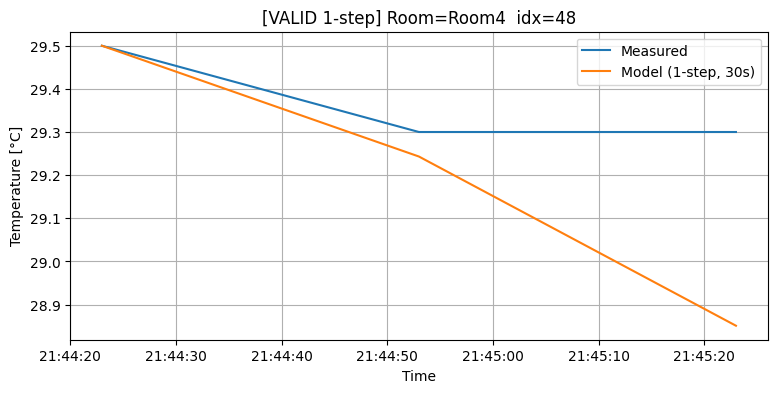

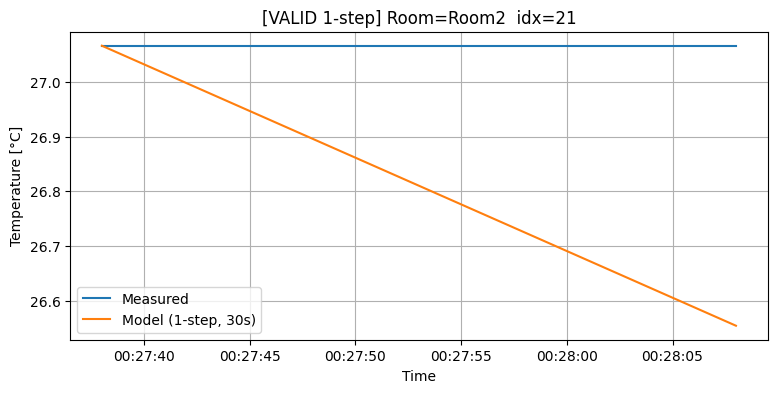

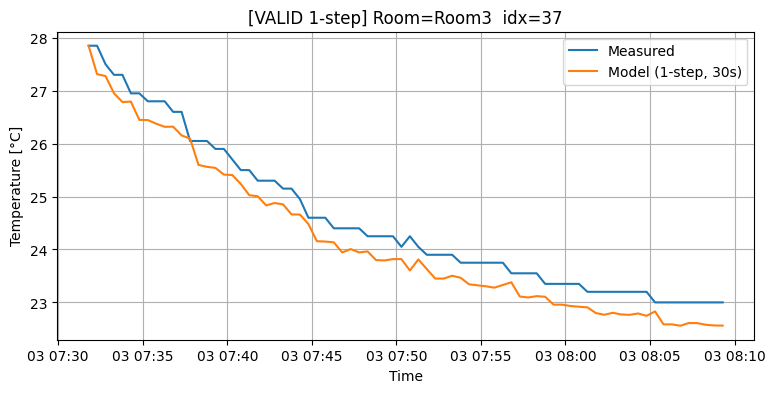

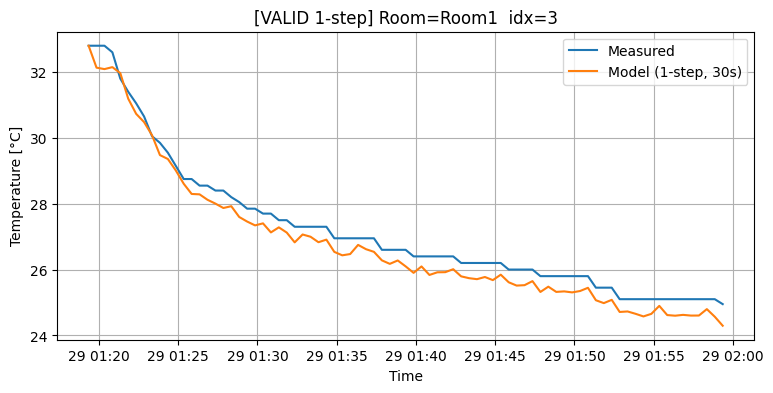

In [30]:
def plot_window_valid_1step(idx):
    s = next(s for s in series_v if s["idx"] == idx)
    t = s["time"]; Tm = s["T_meas"]; Tp = s["T_pred"]
    plt.figure(figsize=(9,4))
    plt.plot(t, Tm, label="Measured")
    plt.plot(t, Tp, label="Model (1-step, 30s)")
    plt.title(f"[VALID 1-step] Room={s['room']}  idx={idx}")
    plt.xlabel("Time"); plt.ylabel("Temperature [°C]")
    plt.grid(True); plt.legend()
    plt.show()

# 각 방에서 RMSE 가장 낮은 1개 윈도우 플롯
best_per_room_v = (summary_valid_1s.sort_values("rmse_C")
                                 .dropna(subset=["rmse_C"])
                                 .groupby("room")
                                 .head(1)["idx"]
                                 .tolist())
print("best_per_room (valid) idx:", best_per_room_v)
for i in best_per_room_v:
    plot_window_valid_1step(i)

# 필요시 임의 인덱스 플롯
# plot_window_valid_1step(0)

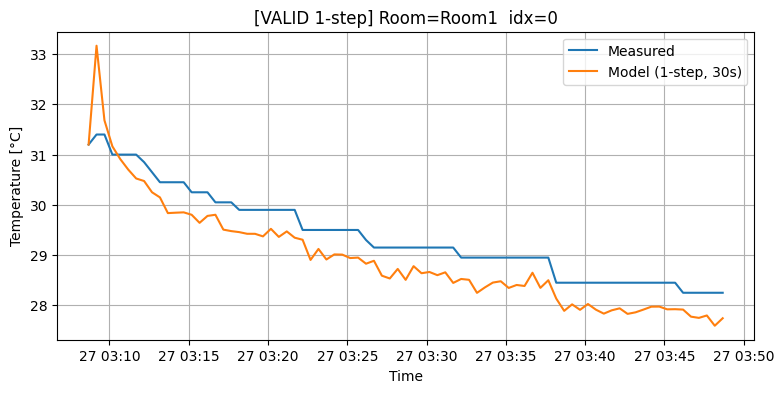

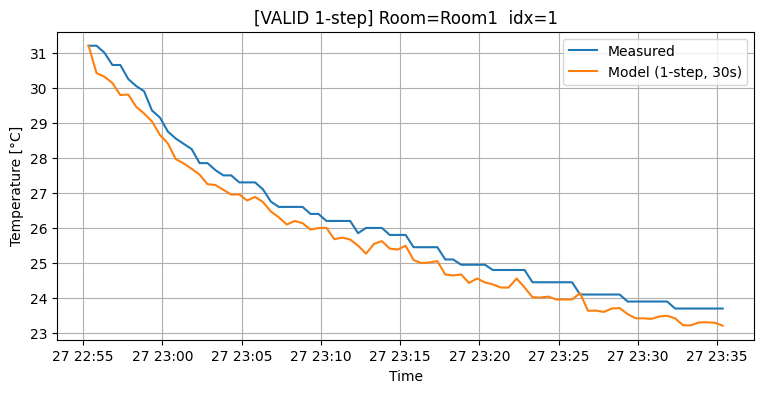

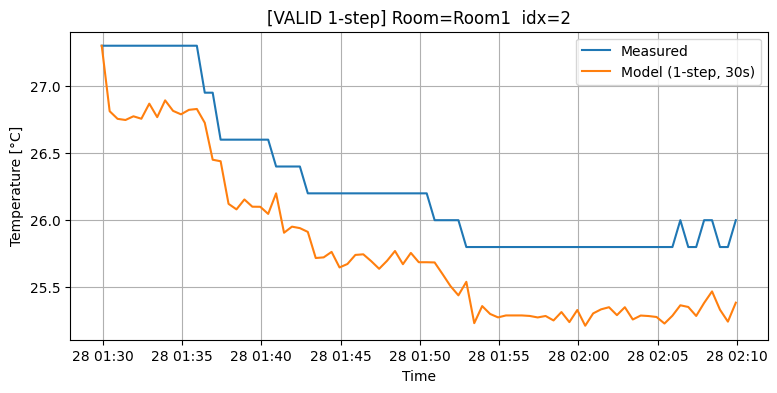

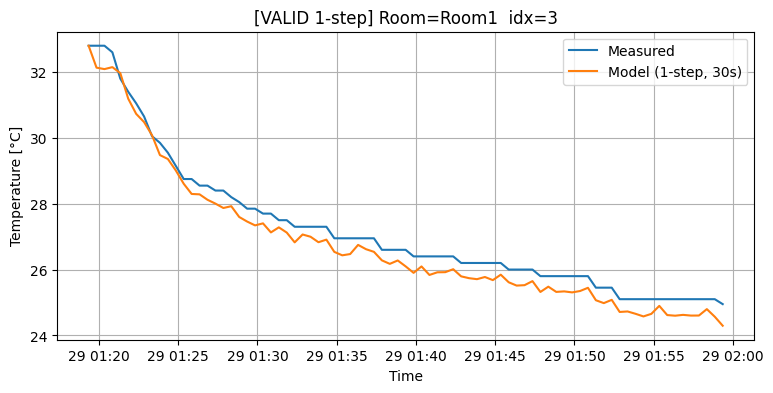

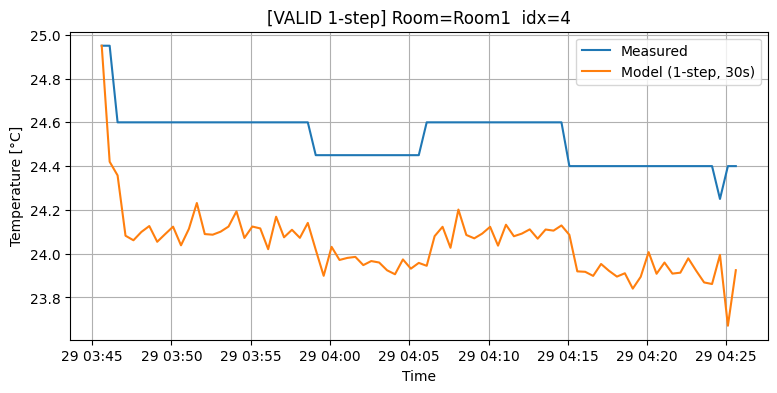

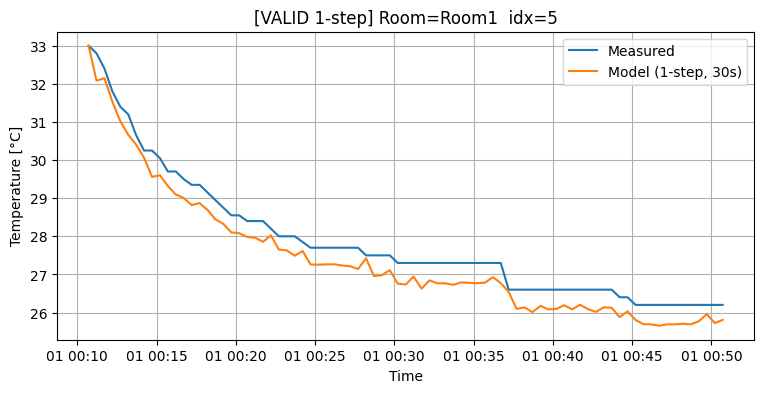

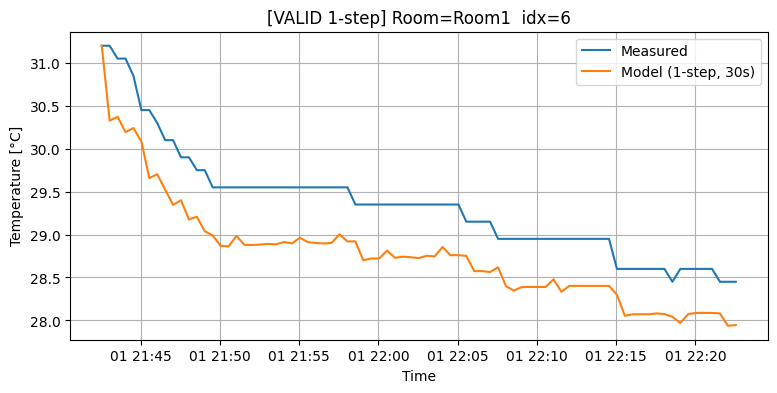

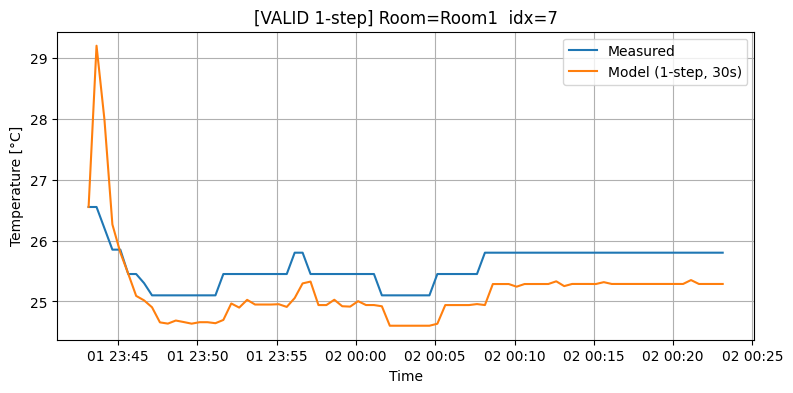

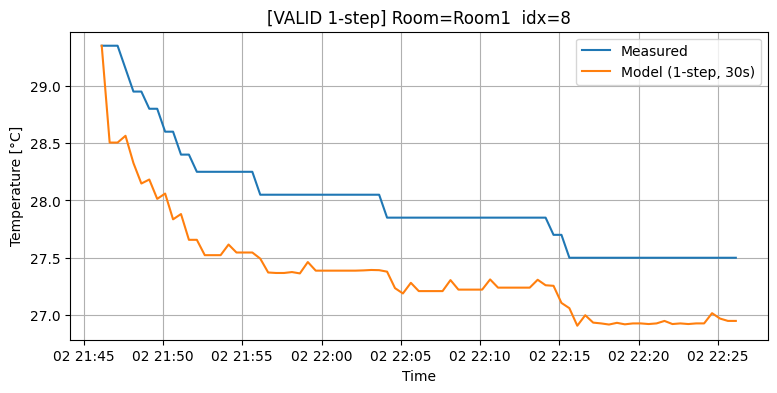

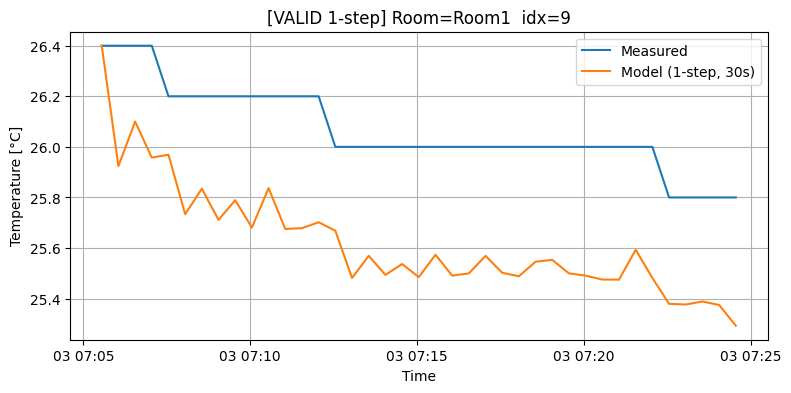

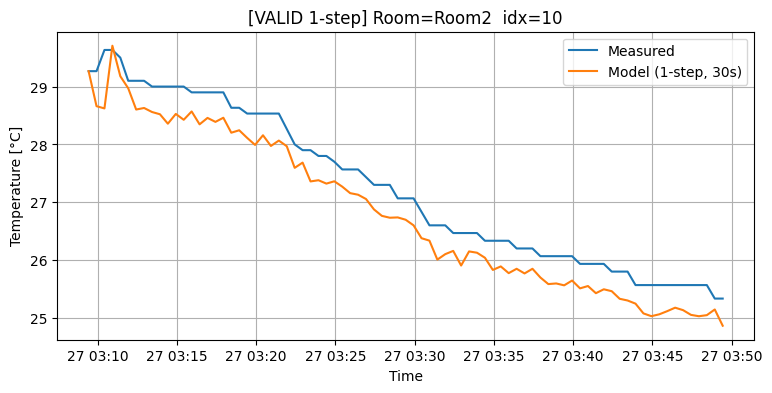

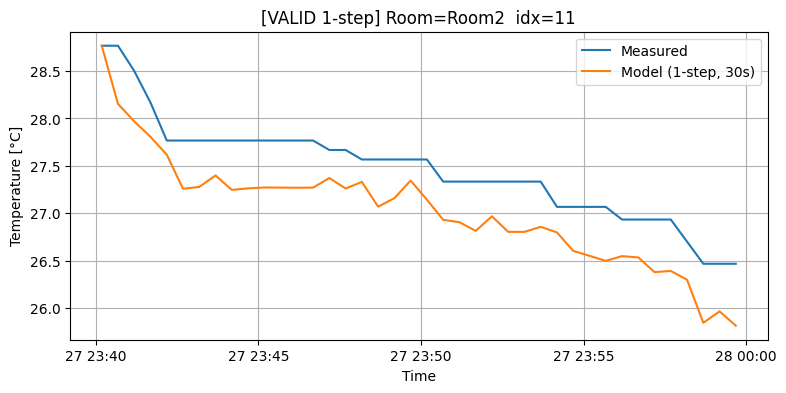

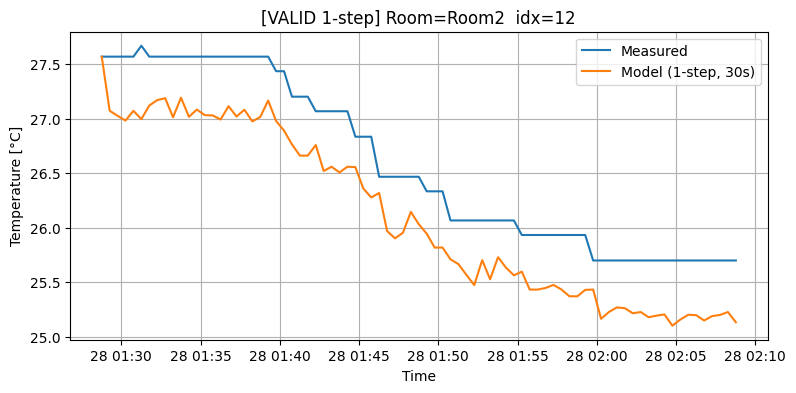

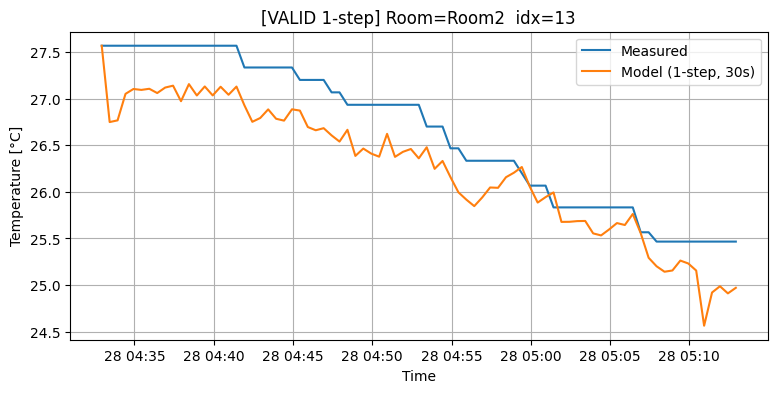

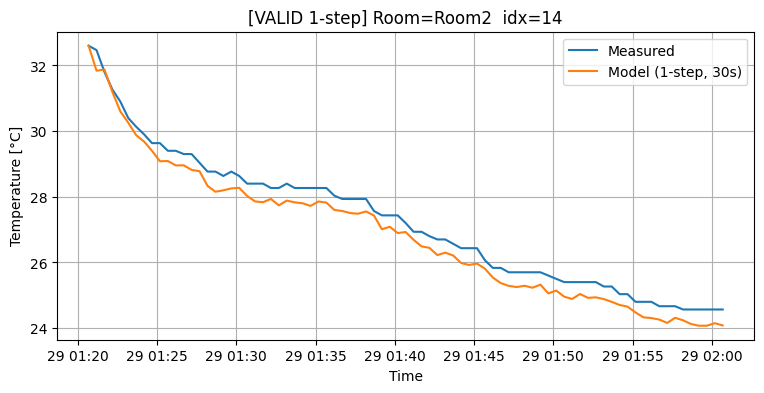

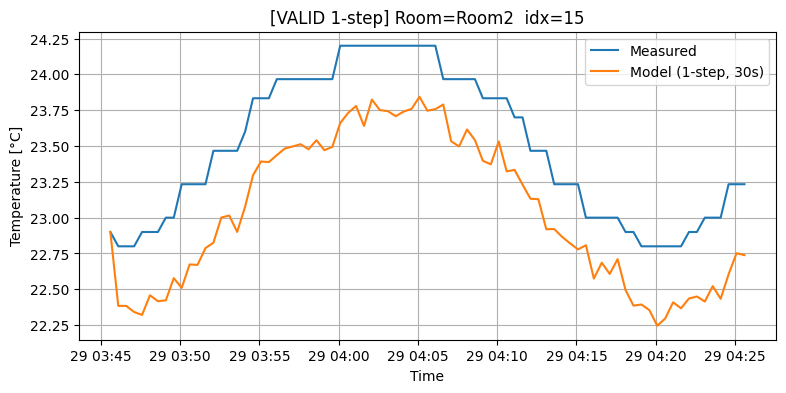

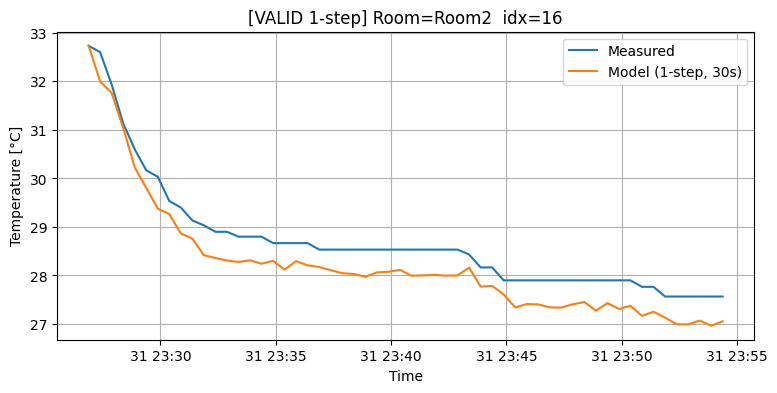

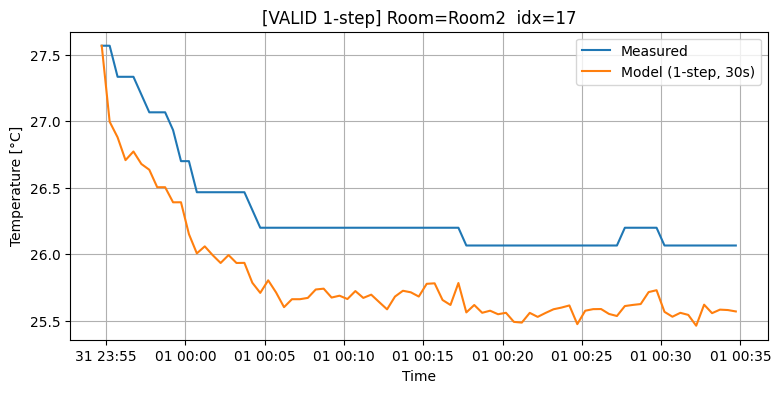

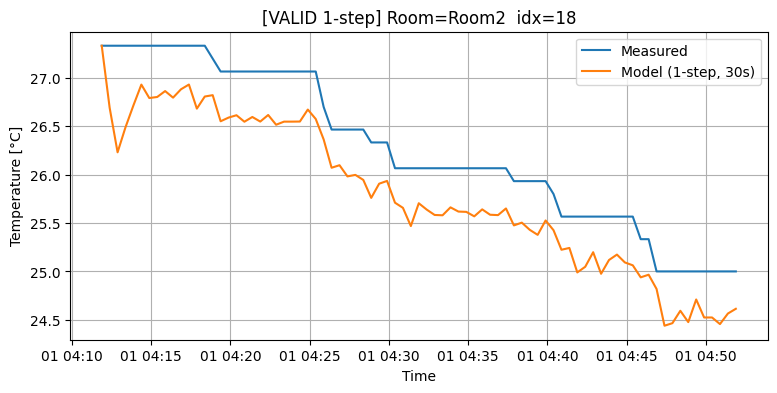

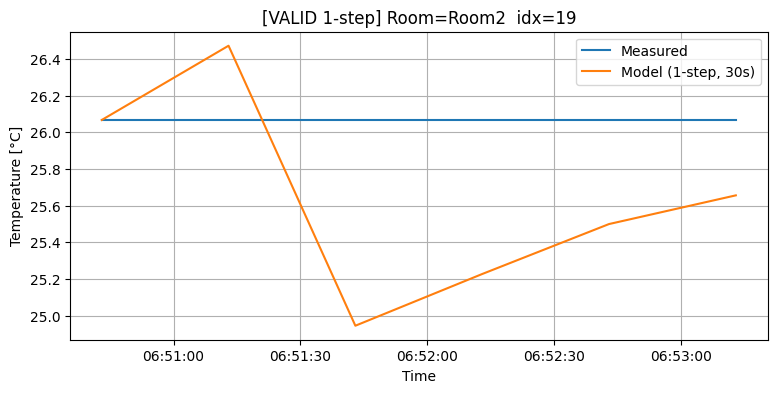

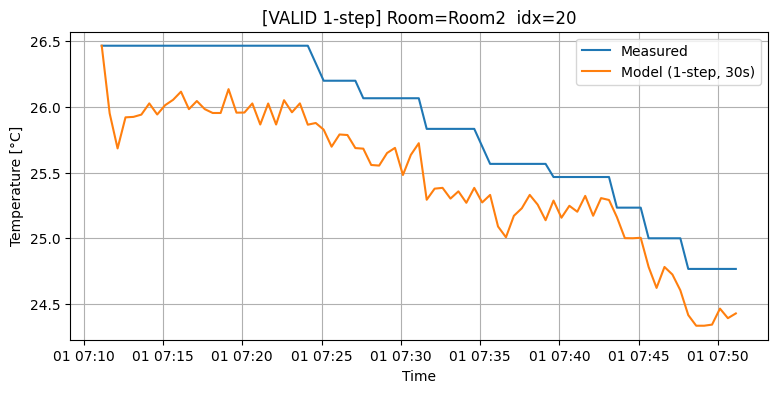

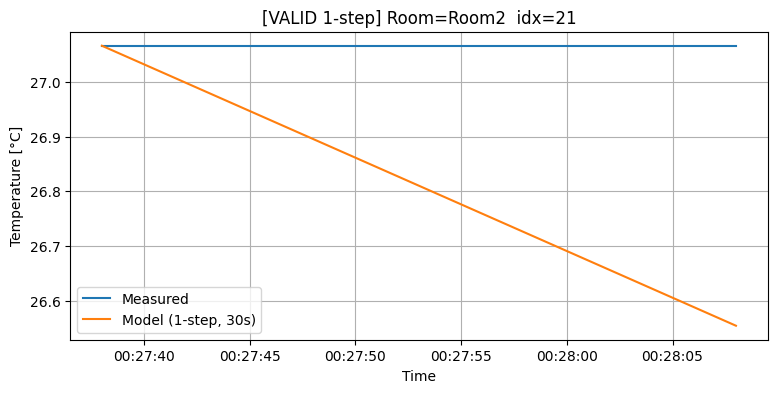

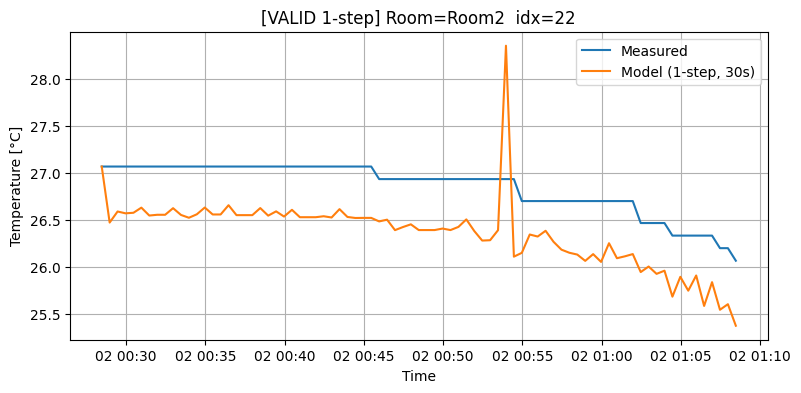

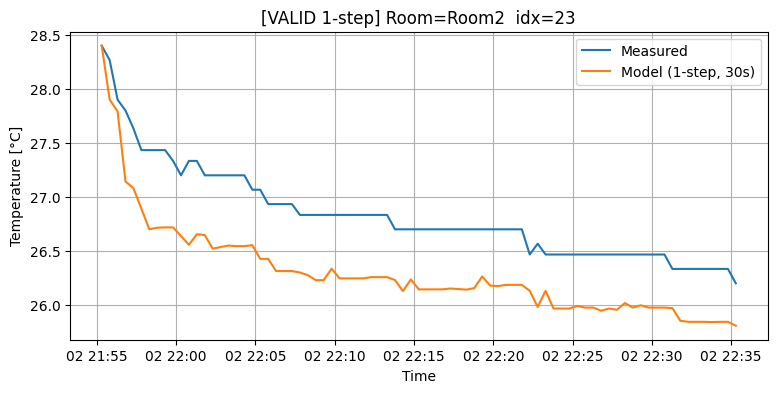

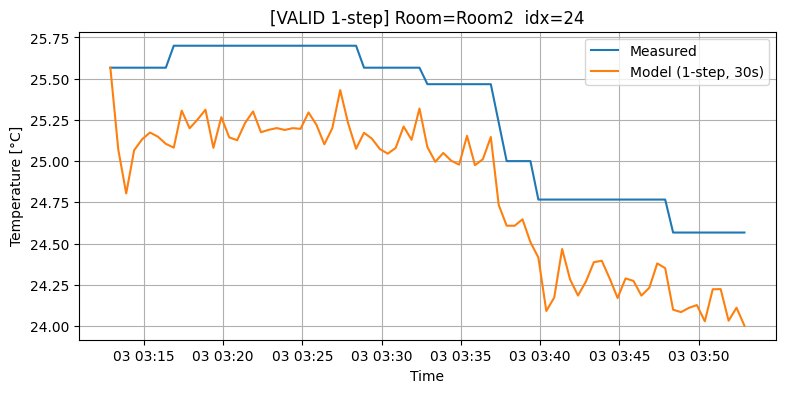

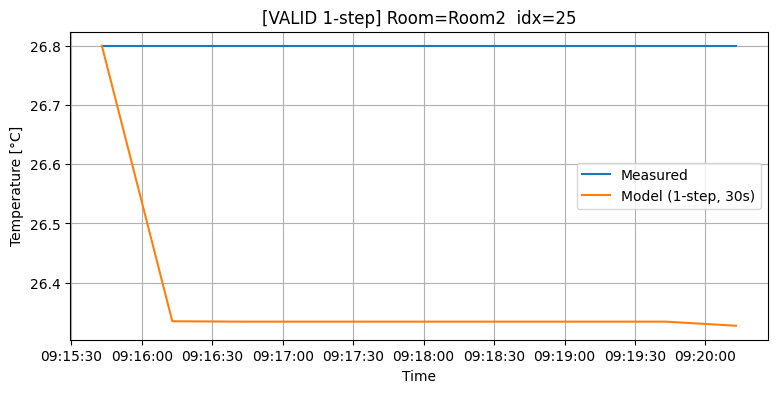

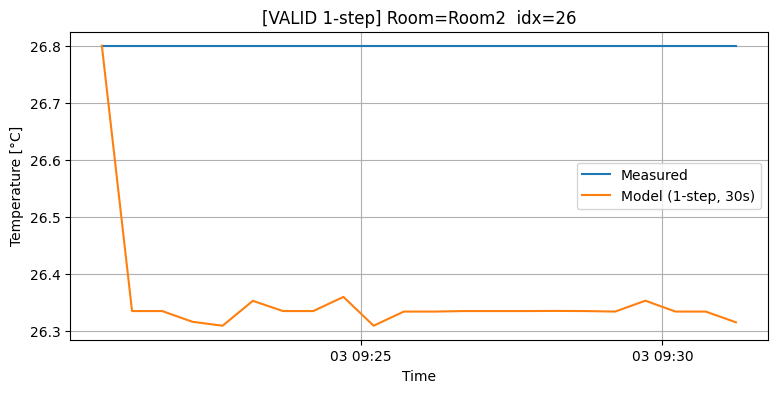

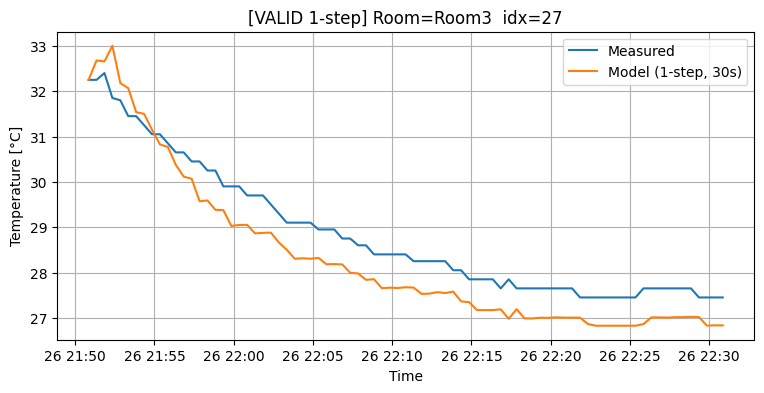

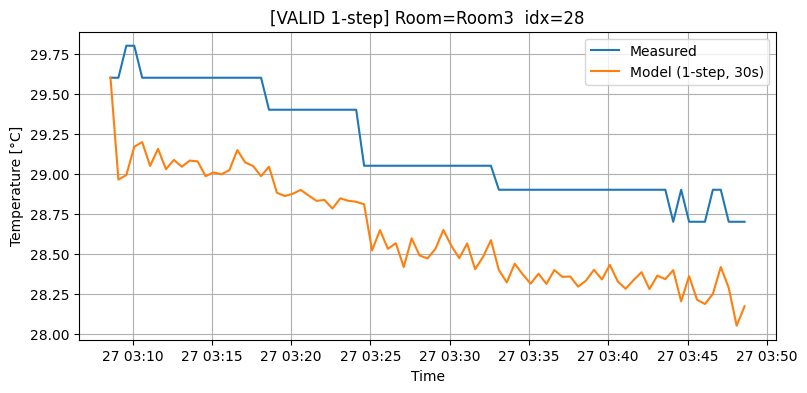

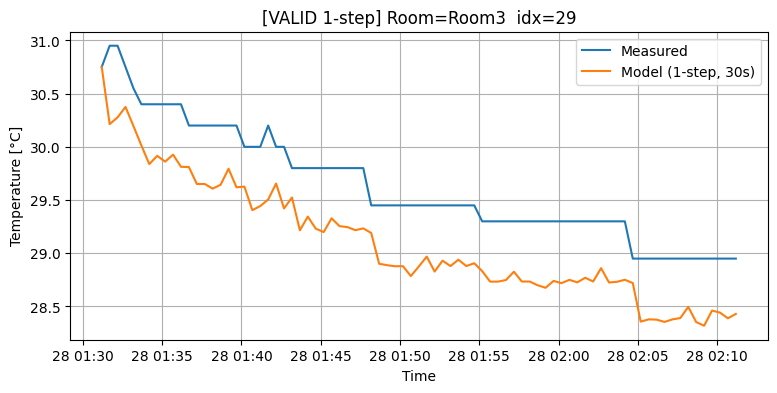

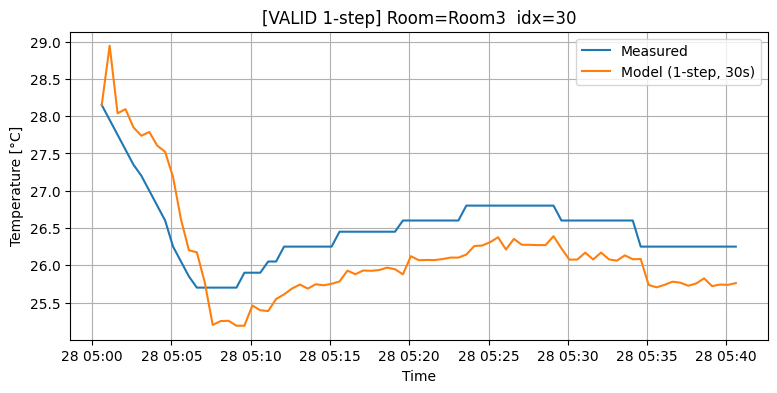

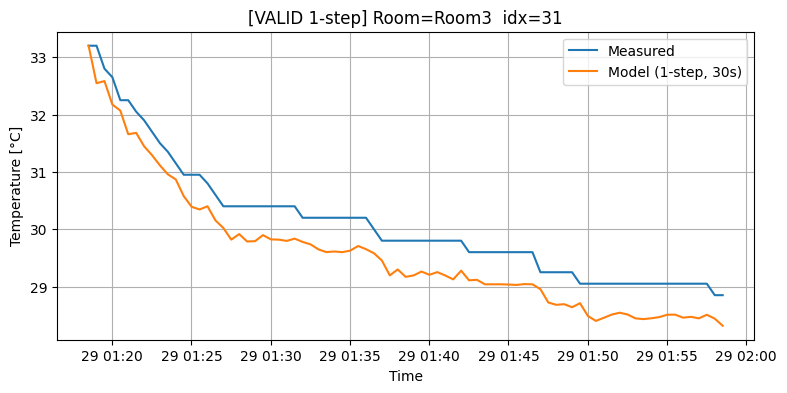

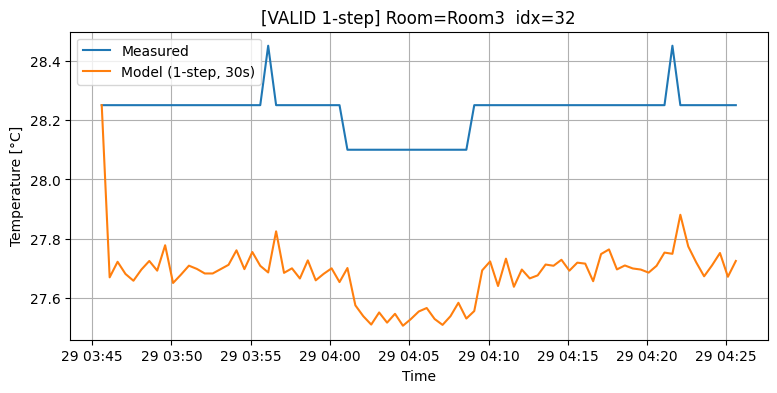

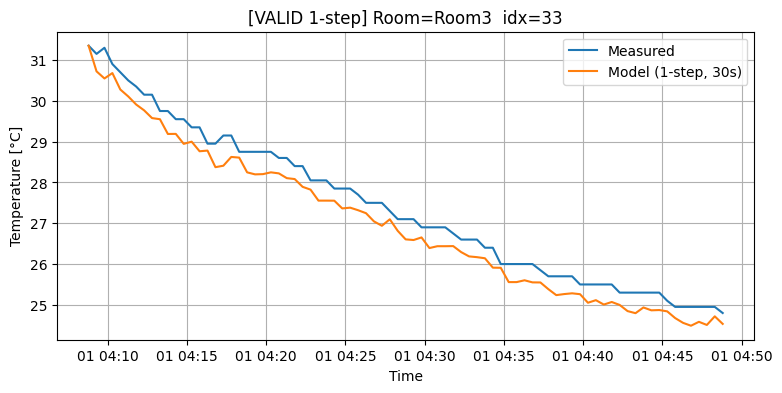

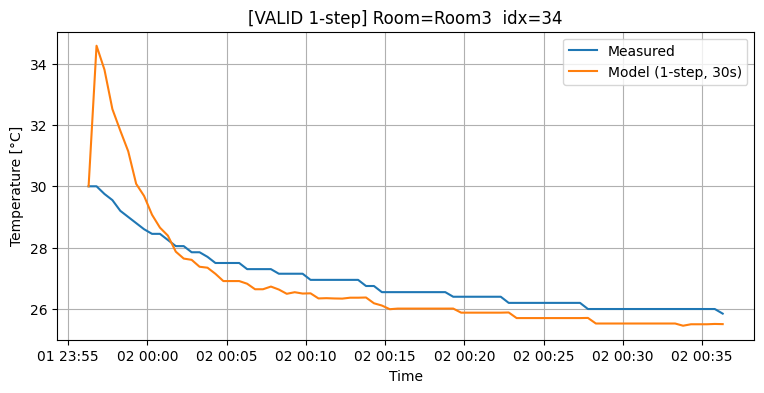

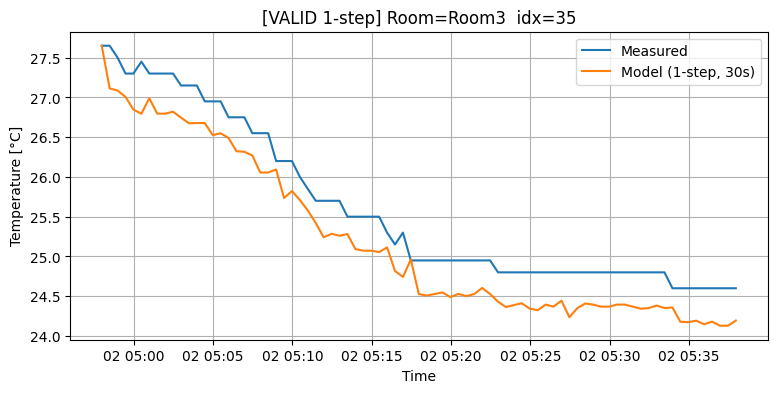

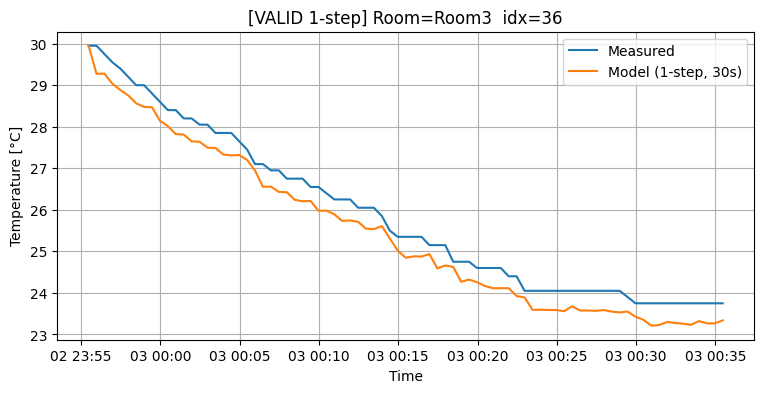

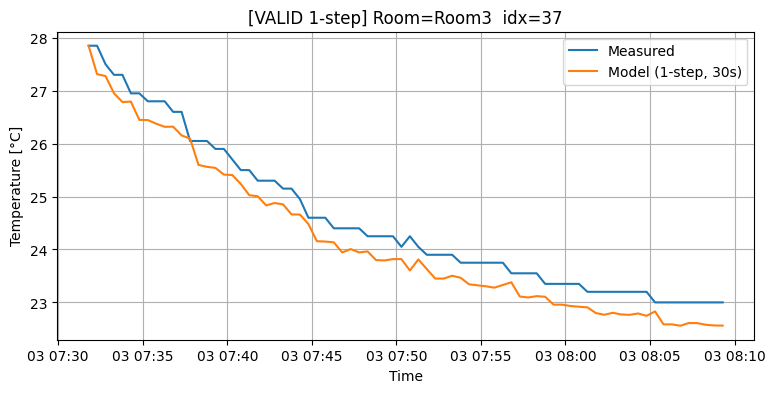

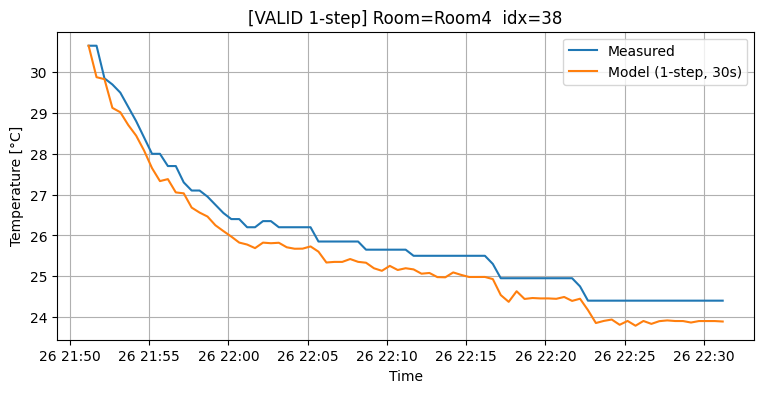

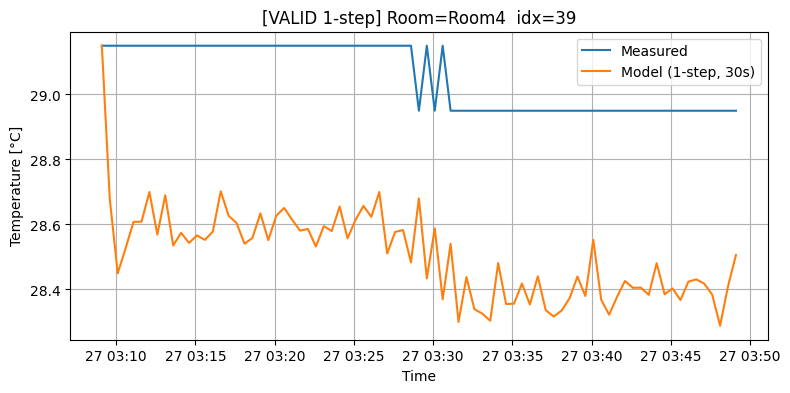

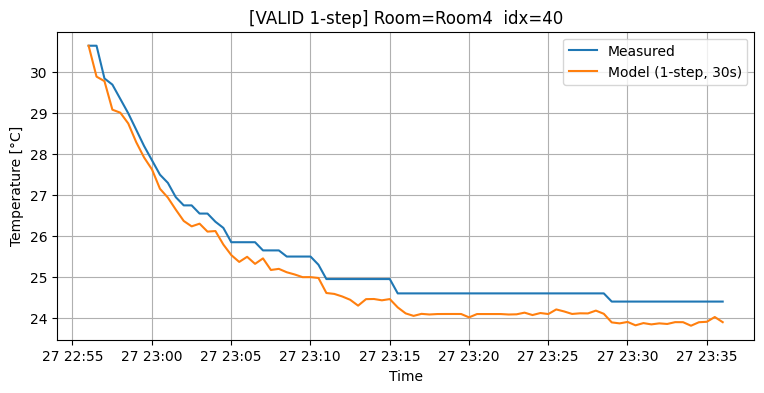

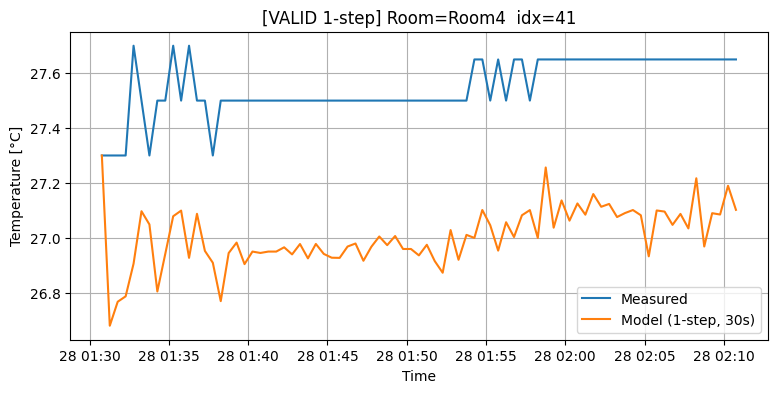

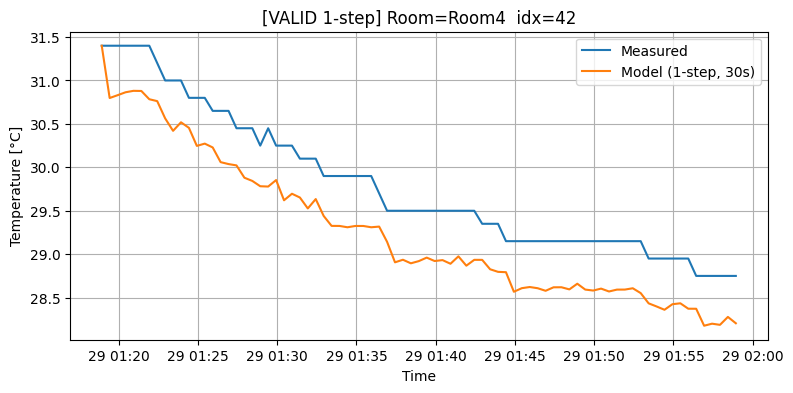

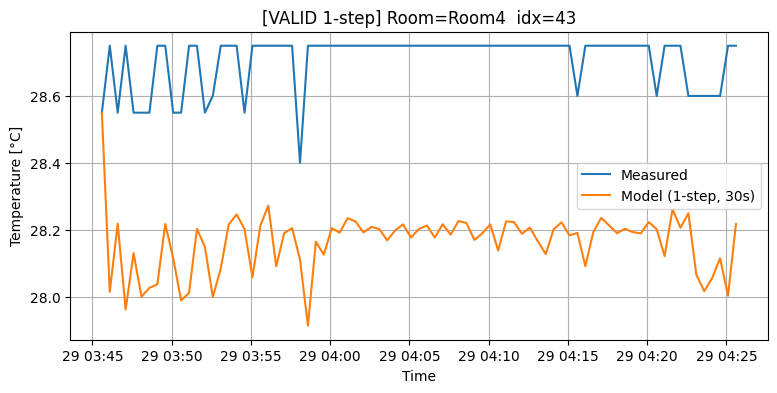

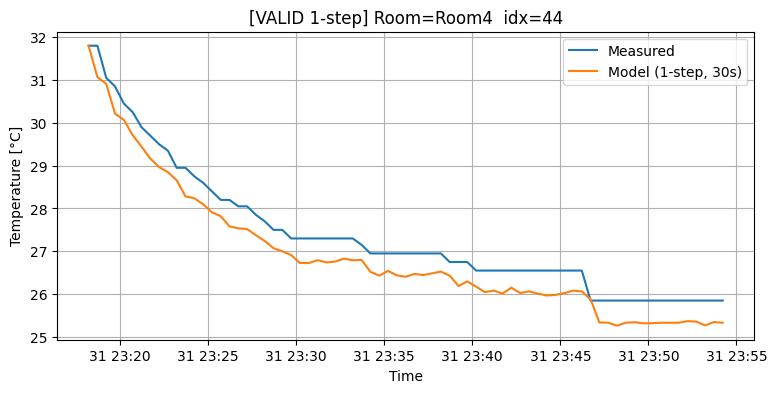

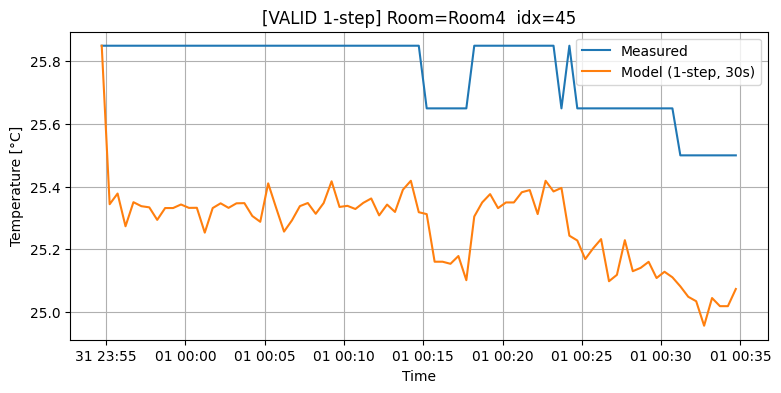

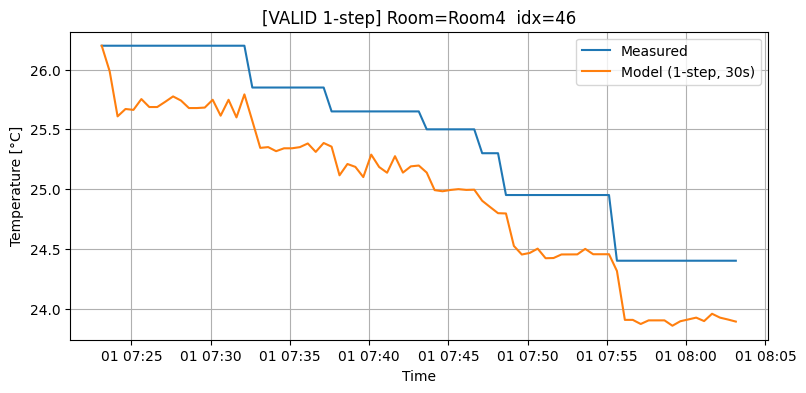

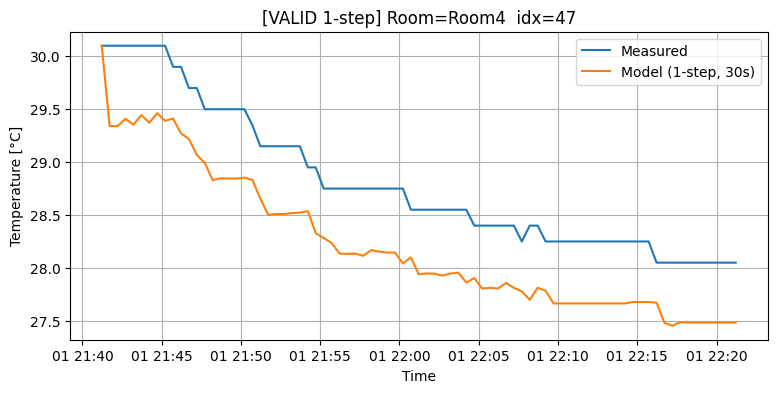

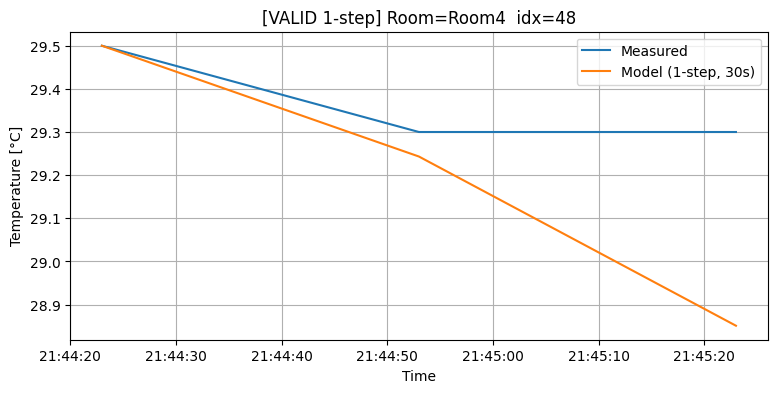

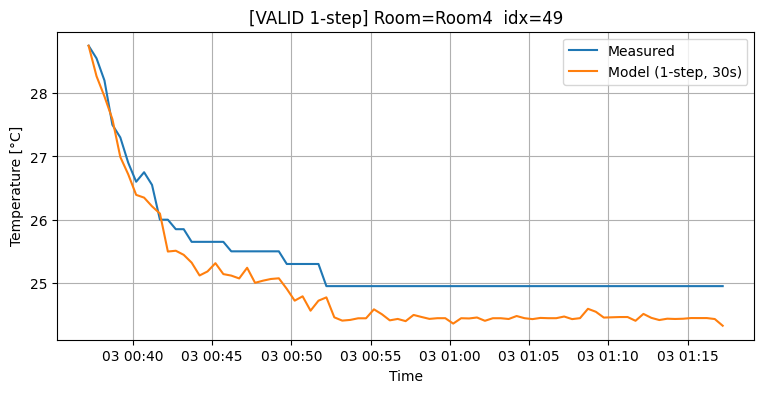

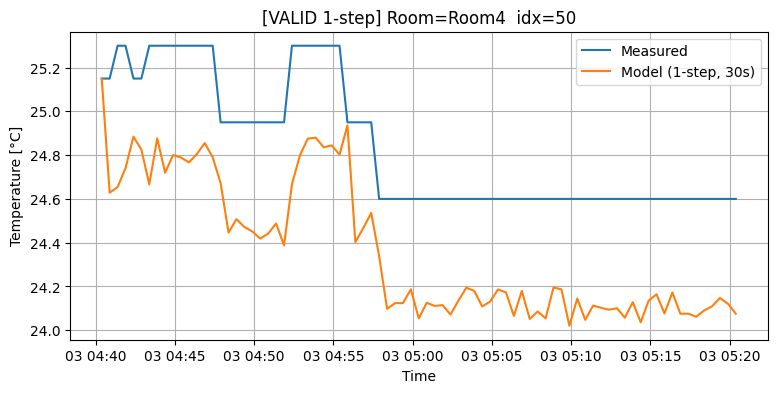

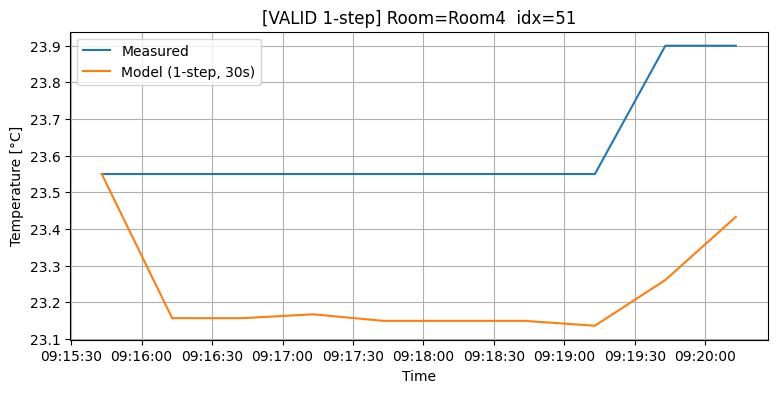

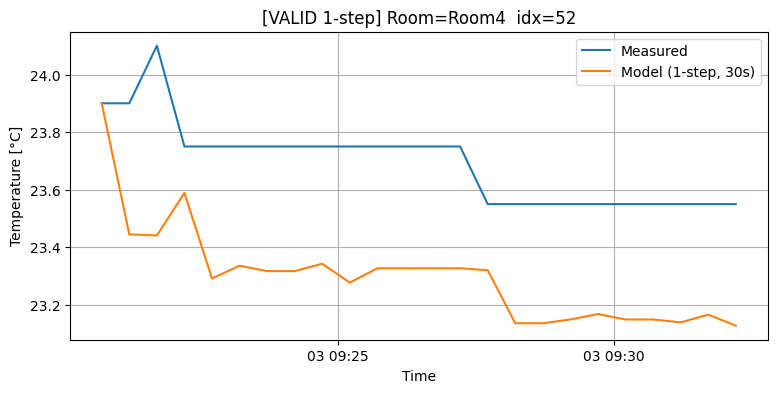

In [31]:
import matplotlib.pyplot as plt

def plot_window_valid_1step(idx):
    s = next(s for s in series_v if s["idx"] == idx)
    t = s["time"]; Tm = s["T_meas"]; Tp = s["T_pred"]
    plt.figure(figsize=(9,4))
    plt.plot(t, Tm, label="Measured")
    plt.plot(t, Tp, label="Model (1-step, 30s)")
    plt.title(f"[VALID 1-step] Room={s['room']}  idx={idx}")
    plt.xlabel("Time"); plt.ylabel("Temperature [°C]")
    plt.grid(True); plt.legend()
    plt.show()

# (A) 전체 윈도우 전부 플롯
for idx in summary_valid_1s["idx"].tolist():
    plot_window_valid_1step(idx)


In [95]:
# ===============================
# ANN 베이스라인: 30s ahead 예측
# 입력: [T0, Tod1, Tod2, M1, M2]
# 출력: T1 (30초 뒤 실내온도)
# ===============================

import numpy as np, pandas as pd, torch, torch.nn as nn
from sklearn.model_selection import train_test_split

# --- IRK 2-stage의 내부 시각 (스테이지 보간용) ---
sqrt3 = np.sqrt(3.0)
c1, c2 = 0.5 - sqrt3/6.0, 0.5 + sqrt3/6.0
DELTA = 30.0  # seconds

# --- 안전한 epoch(sec) 변환 ---
def to_epoch_sec(ts):
    dt = pd.to_datetime(ts, utc=True)
    if isinstance(dt, (pd.Series, pd.Index, np.ndarray)):
        return pd.to_datetime(dt).astype("int64") // 10**9
    else:
        return int(pd.to_datetime(dt).value // 10**9)

# --- 연속 5초 세션 나누기 ---
def group_contiguous_5s(dts):
    t = to_epoch_sec(dts).values
    dt = np.diff(t, prepend=t[0])
    return np.cumsum(dt != 5)

# --- df_rooms -> 학습용 30초 윈도우 (PINN과 동일 feature 구성) ---
def build_windows_from_room_df(df_room: pd.DataFrame):
    d = df_room.sort_values("datetime").copy()
    t = to_epoch_sec(d["datetime"]).values.astype(float)

    dt = np.diff(t, prepend=t[0])
    seq_id = np.cumsum(dt != 5)

    rows = []
    for _, g in d.groupby(seq_id):
        if len(g) < 7:      # 30초 = 6스텝 필요 → 최소 7포인트
            continue
        tg   = to_epoch_sec(g["datetime"]).values.astype(float)
        T    = g["Tid_room"].values.astype(float)
        Tod  = g["Tod_room"].values.astype(float)
        M    = g["mdot_Tdiff_sum"].values.astype(float)

        # i...i+6 (30초) 윈도우 슬라이딩
        for i in range(len(g)-6):
            t0 = tg[i]
            ts1 = t0 + c1*DELTA
            ts2 = t0 + c2*DELTA

            T0   = T[i]
            T1   = T[i+6]  # 라벨
            Tod1 = np.interp(ts1, tg, Tod, left=np.nan, right=np.nan)
            Tod2 = np.interp(ts2, tg, Tod, left=np.nan, right=np.nan)
            M1   = np.interp(ts1, tg, M,   left=np.nan, right=np.nan)
            M2   = np.interp(ts2, tg, M,   left=np.nan, right=np.nan)

            if np.any(np.isnan([T0,T1,Tod1,Tod2,M1,M2])):
                continue
            rows.append([T0, Tod1, Tod2, M1, M2, T1])

    if not rows:
        return pd.DataFrame(columns=["T0","Tod1","Tod2","M1","M2","T1"])
    return pd.DataFrame(rows, columns=["T0","Tod1","Tod2","M1","M2","T1"])

def build_all_windows(df_rooms: pd.DataFrame):
    parts = []
    for room, g in df_rooms.groupby("room"):
        parts.append(build_windows_from_room_df(g))
    return pd.concat(parts, ignore_index=True) if parts else pd.DataFrame(columns=["T0","Tod1","Tod2","M1","M2","T1"])

# --- windows_df 생성 (이미 있으면 재사용) ---
if 'windows_df' not in globals():
    assert set(["datetime","room","Tid_room","Tod_room","mdot_Tdiff_sum"]).issubset(df_rooms.columns), \
        "df_rooms에 필요한 컬럼이 없습니다."
    windows_df = build_all_windows(df_rooms)
print("windows_df:", windows_df.shape, windows_df.head())

# ===============================
# PyTorch ANN 베이스라인
# ===============================

# (선택) 표준화: 입력 X만 스케일링 (y는 온도 단위 유지)
X = windows_df[["T0","Tod1","Tod2","M1","M2"]].values.astype(np.float32)
y = windows_df[["T1"]].values.astype(np.float32)

# train/val 분할
X_tr, X_val, y_tr, y_val = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)

# 간단한 StandardScaler (수동)
x_mean, x_std = X_tr.mean(axis=0), X_tr.std(axis=0) + 1e-8
X_trn = (X_tr - x_mean)/x_std
X_vln = (X_val - x_mean)/x_std

# Dataset/DataLoader
class ArrayDS(torch.utils.data.Dataset):
    def __init__(self, X, y):
        self.X = torch.from_numpy(X.astype(np.float32))
        self.y = torch.from_numpy(y.astype(np.float32))
    def __len__(self): return len(self.X)
    def __getitem__(self, i): return self.X[i], self.y[i]

train_ds = ArrayDS(X_trn, y_tr)
val_ds   = ArrayDS(X_vln, y_val)

train_loader = torch.utils.data.DataLoader(train_ds, batch_size=512, shuffle=True)
val_loader   = torch.utils.data.DataLoader(val_ds,   batch_size=1024, shuffle=False)

# 모델 정의 (MLP)
class ANNBaseline(nn.Module):
    def __init__(self, in_dim=5, hid=8, out_dim=1, p_drop=0.1):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, hid), nn.ReLU(),
            nn.Dropout(p_drop),
            #nn.Linear(hid, hid), nn.ReLU(),
            #nn.Dropout(p_drop),
            nn.Linear(hid, out_dim),
        )
    def forward(self, x): return self.net(x)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
ann = ANNBaseline(in_dim=5, hid=8, out_dim=1, p_drop=0.1).to(device)

# --- 옵티마이저/스케줄러/손실 ---
opt = torch.optim.AdamW(ann.parameters(), lr=2e-3, weight_decay=1e-4)

# ↓ verbose 인자 제거 (구버전 호환)
sched = torch.optim.lr_scheduler.ReduceLROnPlateau(
    opt, mode='min', factor=0.5, patience=5
)
mse = nn.MSELoss()

best_val, best_state = np.inf, None
EPOCHS = 50
prev_lr = opt.param_groups[0]['lr']

for ep in range(1, EPOCHS+1):
    # ---- train ----
    ann.train()
    tr_losses = []
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        opt.zero_grad()
        pred = ann(xb)
        loss = mse(pred, yb)
        loss.backward()
        # (옵션) 그라디언트 클리핑: 폭주 방지
        torch.nn.utils.clip_grad_norm_(ann.parameters(), max_norm=5.0)
        opt.step()
        tr_losses.append(loss.item())

    # ---- validate ----
    ann.eval()
    with torch.no_grad():
        Xv = torch.from_numpy(X_vln).to(device)
        yv = torch.from_numpy(y_val).to(device)
        pv = ann(Xv)
        val_loss = mse(pv, yv).item()

    # ---- scheduler ----
    sched.step(val_loss)
    cur_lr = opt.param_groups[0]['lr']
    lr_msg = f" lr→{cur_lr:.1e}" if cur_lr != prev_lr else ""
    prev_lr = cur_lr

    # ---- save best ----
    if val_loss < best_val - 1e-5:
        best_val = val_loss
        best_state = {k: v.detach().cpu().clone() for k, v in ann.state_dict().items()}

    if ep % 5 == 0 or ep == 1:
        tr_loss = float(np.mean(tr_losses))
        print(f"[{ep:03d}] train MSE={tr_loss:.4f} | val MSE={val_loss:.4f}{lr_msg}")

# best 가중치 로드
if best_state is not None:
    ann.load_state_dict(best_state)

# 최종 RMSE 보고
ann.eval()
with torch.no_grad():
    # Train RMSE
    ptr = ann(torch.from_numpy(X_trn).to(device)).cpu().numpy()
    rmse_tr = float(np.sqrt(np.mean((ptr - y_tr)**2)))
    # Val RMSE
    pvl = ann(torch.from_numpy(X_vln).to(device)).cpu().numpy()
    rmse_val = float(np.sqrt(np.mean((pvl - y_val)**2)))
print(f"=> ANN Baseline RMSE | train={rmse_tr:.3f} °C, val={rmse_val:.3f} °C")

# ===============================
# (선택) 1-step 롤아웃 RMSE를 윈도우 단위로 보기
#  - 교사강제: 매 스텝 T0 = 실측 사용
#  - 입력은 항상 X = [T0, Tod1,Tod2, M1,M2] (표준화 적용)
# ===============================
def ann_predict_one_step(T0, Tod1, Tod2, M1, M2):
    x = np.array([[T0, Tod1, Tod2, M1, M2]], dtype=np.float32)
    x = (x - x_mean)/x_std
    with torch.no_grad():
        pred = ann(torch.from_numpy(x).to(device)).cpu().numpy().squeeze()
    return float(pred)

# 샘플로 windows_df 앞 5개 윈도우에서 교사강제 RMSE 확인
def quick_1step_rmse(df_windows, n=5):
    idx = np.random.choice(len(df_windows), size=min(n, len(df_windows)), replace=False)
    errs = []
    for i in idx:
        r = df_windows.iloc[i]
        pred = ann_predict_one_step(r["T0"], r["Tod1"], r["Tod2"], r["M1"], r["M2"])
        errs.append((pred - r["T1"])**2)
    return float(np.sqrt(np.mean(errs))) if errs else np.nan

print("quick 1-step RMSE (sample):", f"{quick_1step_rmse(windows_df, n=50):.3f}", "°C")


windows_df: (322997, 6)       T0       Tod1       Tod2        M1        M2     T1
0  28.75  36.300000  36.080385  2.743304  2.743304  28.75
1  28.75  36.300000  36.000000  2.743304  2.743304  28.75
2  28.75  36.300000  36.000000  2.743304  2.743304  28.75
3  28.75  36.219615  36.000000  2.743304  2.743304  28.75
4  28.75  36.000000  36.073205  2.743304  2.743304  28.75
[001] train MSE=456.7543 | val MSE=163.4980
[005] train MSE=11.5548 | val MSE=0.2696
[010] train MSE=7.5858 | val MSE=0.2034
[015] train MSE=4.5391 | val MSE=0.0971
[020] train MSE=2.3303 | val MSE=0.0610
[025] train MSE=0.9441 | val MSE=0.0252
[030] train MSE=0.4439 | val MSE=0.1187
[035] train MSE=0.4344 | val MSE=0.1347
[040] train MSE=0.4328 | val MSE=0.1344
[045] train MSE=0.4357 | val MSE=0.1345
[050] train MSE=0.4355 | val MSE=0.1346
=> ANN Baseline RMSE | train=0.158 °C, val=0.159 °C
quick 1-step RMSE (sample): 0.149 °C


In [96]:
import numpy as np, pandas as pd, torch
import matplotlib.pyplot as plt

# --- 고정 상수 (PINN과 동일) ---
sqrt3 = np.sqrt(3.0)
c1, c2 = 0.5 - sqrt3/6.0, 0.5 + sqrt3/6.0
DELTA = 30.0  # seconds

# --- 전제 체크 ---
assert 'ann' in globals(), "학습된 ANN 모델(ann)이 필요합니다."
assert 'x_mean' in globals() and 'x_std' in globals(), "학습셋에서 계산한 x_mean/x_std가 필요합니다."
assert isinstance(x_mean, np.ndarray) and isinstance(x_std, np.ndarray) and x_mean.shape==(5,) and x_std.shape==(5,)

# --- 안전한 epoch(sec) 변환 & 세션 분할 ---
def to_epoch_sec(ts):
    dt = pd.to_datetime(ts, utc=True)
    if isinstance(dt, (pd.Series, pd.Index, np.ndarray)):
        return pd.to_datetime(dt).astype("int64") // 10**9
    else:
        return int(pd.to_datetime(dt).value // 10**9)

def group_contiguous_5s(dts):
    t = to_epoch_sec(dts).values
    dt = np.diff(t, prepend=t[0])
    return np.cumsum(dt != 5)

# --- VALID 윈도우(방별/세션별, 최대 40분, 30초 그리드) 생성 ---
def make_rollout_windows_from_rooms(df_rooms, roll_min=40):
    ROLL_SEC = roll_min * 60
    wins = []
    for room, g in df_rooms.groupby("room"):
        g = g.sort_values("datetime").copy()
        sid = group_contiguous_5s(g["datetime"])
        for _, seg in g.groupby(sid):
            if seg.empty: 
                continue
            t0    = to_epoch_sec(seg["datetime"].iloc[0])
            t_end = to_epoch_sec(seg["datetime"].iloc[-1])
            t_stop = min(t0 + ROLL_SEC, t_end)
            t_grid = np.arange(t0, t_stop + 1e-6, DELTA, dtype=float)
            if len(t_grid) < 2:
                continue

            tg   = to_epoch_sec(seg["datetime"]).values.astype(float)
            T    = seg["Tid_room"].values.astype(float)
            Tod  = seg["Tod_room"].values.astype(float)
            M    = seg["mdot_Tdiff_sum"].values.astype(float)

            # 비교 동일 축: 실측 T를 30초 그리드로 보간
            T_meas = np.interp(t_grid, tg, T, left=np.nan, right=np.nan)

            wins.append({
                "room": room,
                "t_grid": t_grid,  # 30s grid
                "tg": tg,          # 5s grid (보간용)
                "Tod": Tod,
                "M": M,
                "T_meas": T_meas
            })
    return wins

# VALID 윈도우 만들기
roll_windows_valid_ann_1s = make_rollout_windows_from_rooms(valid_rooms, roll_min=40)
print("n_windows (valid, 1-step, ANN):", len(roll_windows_valid_ann_1s))

def ann_predict_one_step(T0, Tod1, Tod2, M1, M2):
    # 모델 디바이스 확인
    device = next(ann.parameters()).device

    x = np.array([[T0, Tod1, Tod2, M1, M2]], dtype=np.float32)
    xz = (x - x_mean) / (x_std + 1e-8)

    ann.eval()
    with torch.no_grad():
        xt = torch.from_numpy(xz).to(device)   # ← 입력을 모델 디바이스로 이동
        pred = ann(xt).detach().cpu().numpy().squeeze()
    return float(pred)


# --- 1-step(교사강제) 롤아웃: 매 스텝 T0=실측, 입력은 스테이지 보간 ---
@torch.no_grad()
def rollout_window_1step_ann(win):
    t_grid = win["t_grid"]
    tg, Tod, M = win["tg"], win["Tod"], win["M"]
    T_meas = win["T_meas"]

    T_pred = np.zeros_like(t_grid, dtype=np.float64)
    T_pred[0] = T_meas[0]  # 첫 스텝은 실측으로 시드

    for k in range(len(t_grid)-1):
        T0 = T_meas[k]  # 교사강제: 현재 스텝 시작 온도는 실측

        ts1, ts2 = t_grid[k] + c1*DELTA, t_grid[k] + c2*DELTA
        Tod1 = np.interp(ts1, tg, Tod, left=np.nan, right=np.nan)
        Tod2 = np.interp(ts2, tg, Tod, left=np.nan, right=np.nan)
        M1   = np.interp(ts1, tg, M,   left=np.nan, right=np.nan)
        M2   = np.interp(ts2, tg, M,   left=np.nan, right=np.nan)
        if np.any(np.isnan([T0, Tod1, Tod2, M1, M2])):
            T_pred[k+1:] = np.nan
            break

        T_pred[k+1] = ann_predict_one_step(T0, Tod1, Tod2, M1, M2)

    mask = ~np.isnan(T_pred) & ~np.isnan(T_meas)
    rmse = np.sqrt(np.mean((T_pred[mask] - T_meas[mask])**2)) if mask.any() else np.nan
    return T_pred, rmse

# --- 모든 윈도우 평가 & 요약표 생성 ---
rows_v_ann, series_v_ann = [], []
for i, w in enumerate(roll_windows_valid_ann_1s):
    Tp, rmse = rollout_window_1step_ann(w)
    rows_v_ann.append({
        "idx": i,
        "room": w["room"],
        "start": pd.to_datetime(w["t_grid"][0], unit="s"),
        "minutes": (len(w["t_grid"])-1) * DELTA / 60.0,
        "rmse_C": rmse
    })
    series_v_ann.append({
        "idx": i, "room": w["room"],
        "time": pd.to_datetime(w["t_grid"], unit="s"),
        "T_meas": w["T_meas"], "T_pred": Tp
    })

summary_valid_ann_1s = (pd.DataFrame(rows_v_ann)
                        .sort_values(["room","start"])
                        .reset_index(drop=True))

print(summary_valid_ann_1s.head(10))
print(summary_valid_ann_1s.groupby("room")["rmse_C"].describe())


n_windows (valid, 1-step, ANN): 53
   idx   room               start  minutes    rmse_C
0    0  Room1 2025-08-27 03:08:41     40.0  0.207236
1    1  Room1 2025-08-27 22:55:21     40.0  0.134108
2    2  Room1 2025-08-28 01:29:56     40.0  0.144145
3    3  Room1 2025-08-29 01:19:21     40.0  0.160970
4    4  Room1 2025-08-29 03:45:36     40.0  0.097924
5    5  Room1 2025-09-01 00:10:43     40.0  0.165723
6    6  Room1 2025-09-01 21:42:33     40.0  0.209657
7    7  Room1 2025-09-01 23:43:08     40.0  0.164268
8    8  Room1 2025-09-02 21:46:08     40.0  0.180125
9    9  Room1 2025-09-03 07:05:33     19.0  0.126204
       count      mean       std       min       25%       50%       75%  \
room                                                                       
Room1   10.0  0.159036  0.035059  0.097924  0.136618  0.162619  0.176524   
Room2   17.0  0.152173  0.019664  0.114352  0.141066  0.153112  0.160812   
Room3   11.0  0.161395  0.045301  0.108778  0.118898  0.153707  0.195421   
Ro

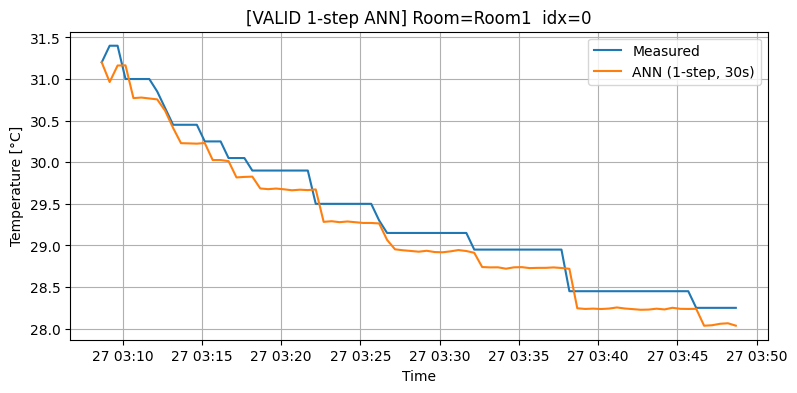

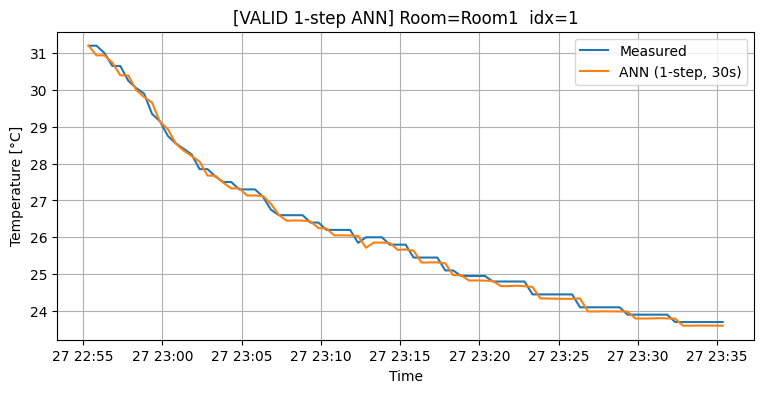

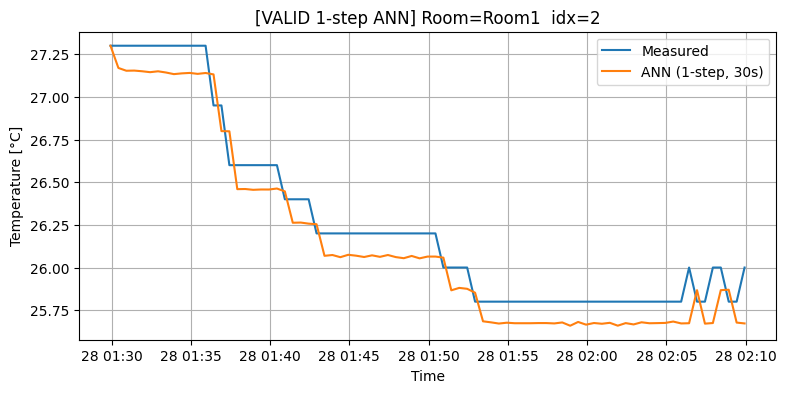

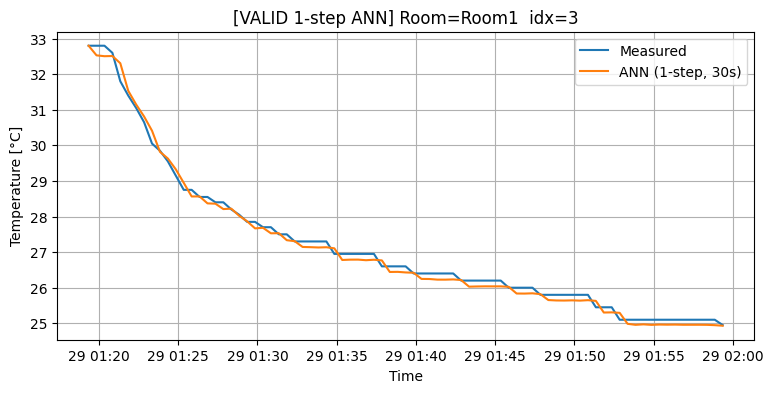

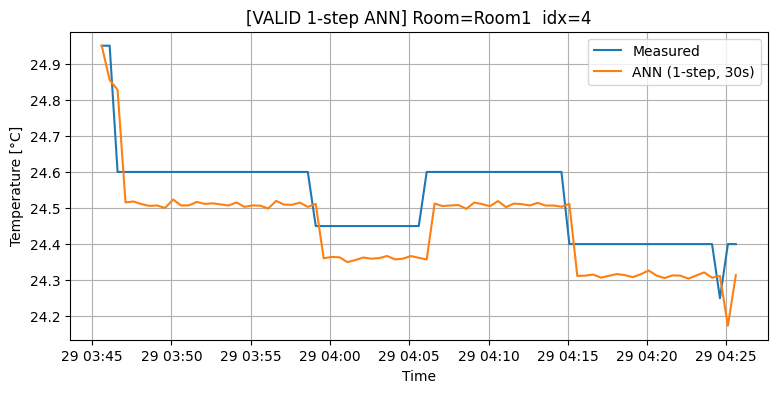

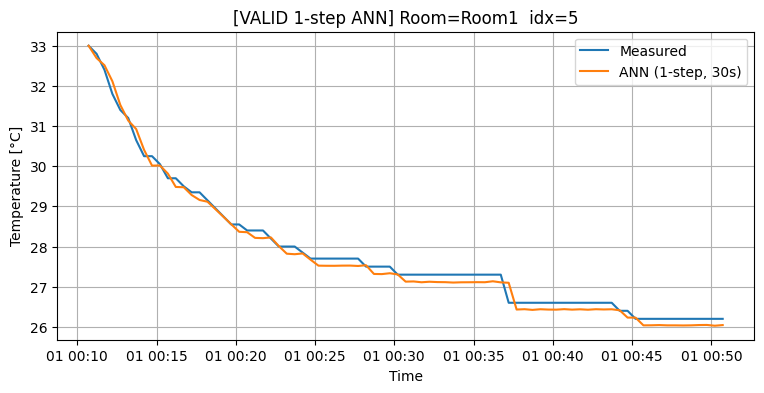

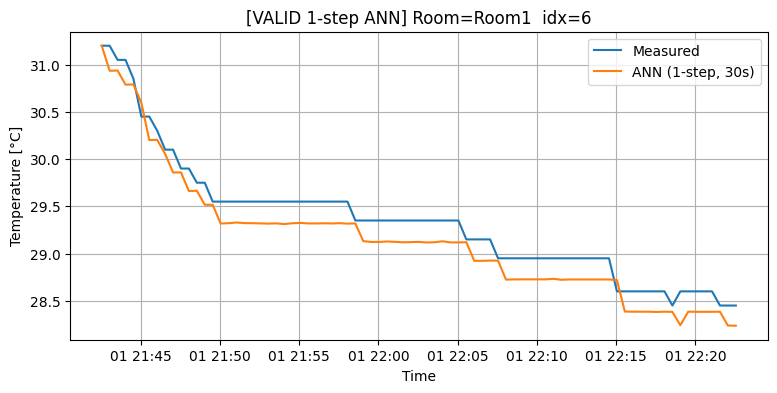

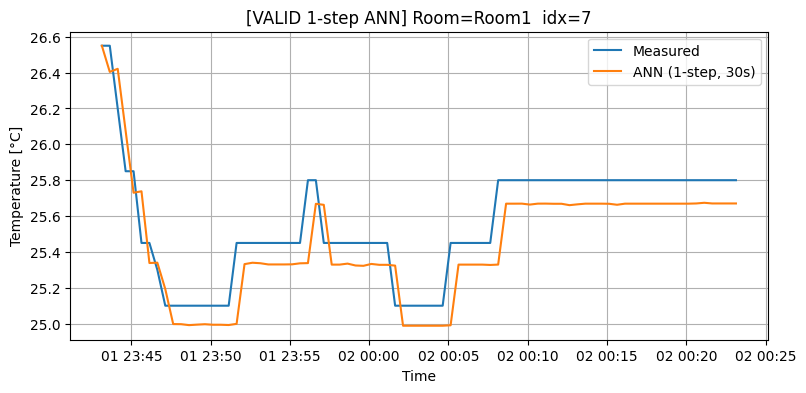

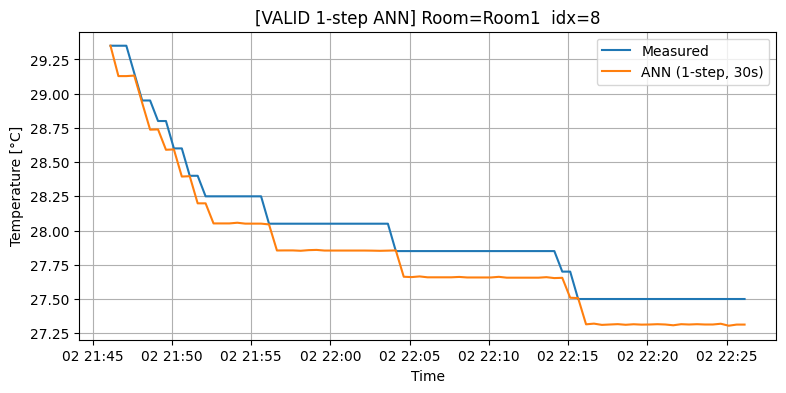

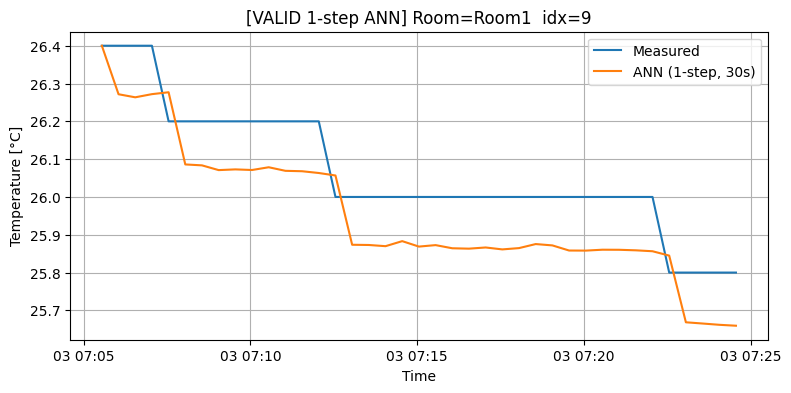

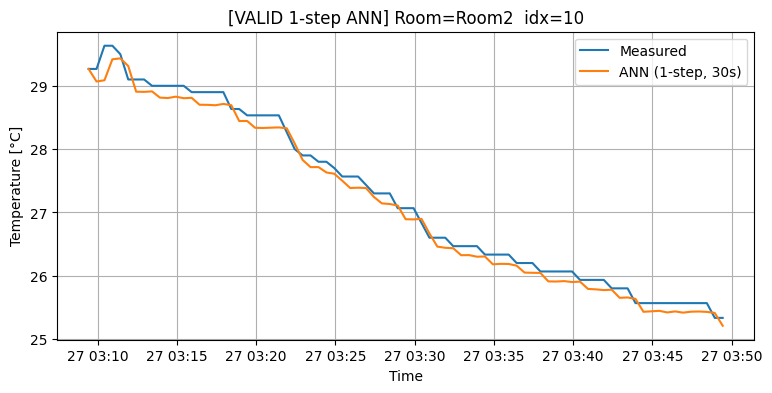

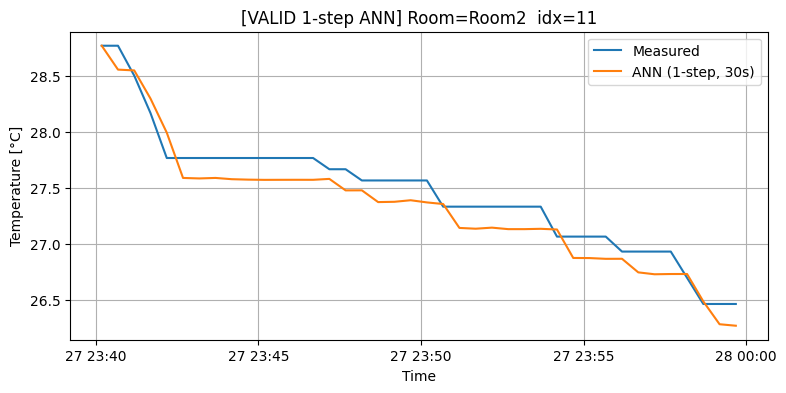

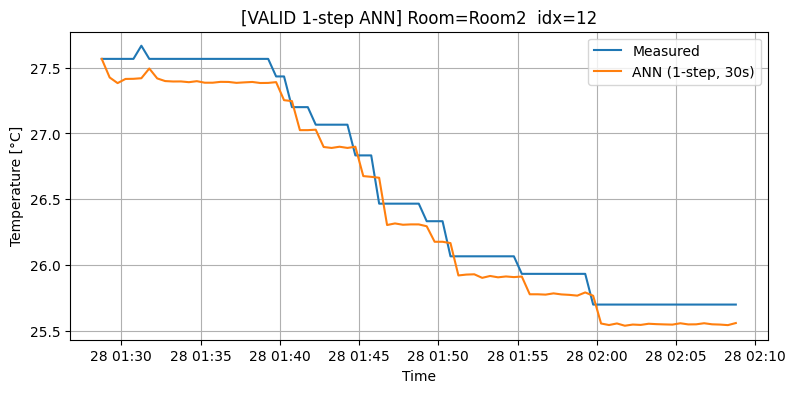

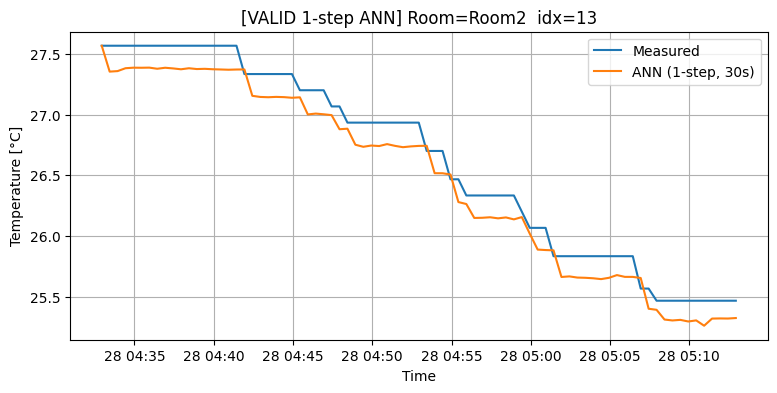

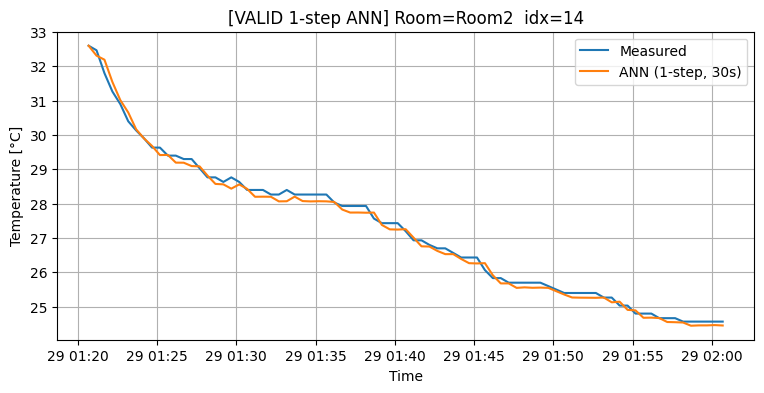

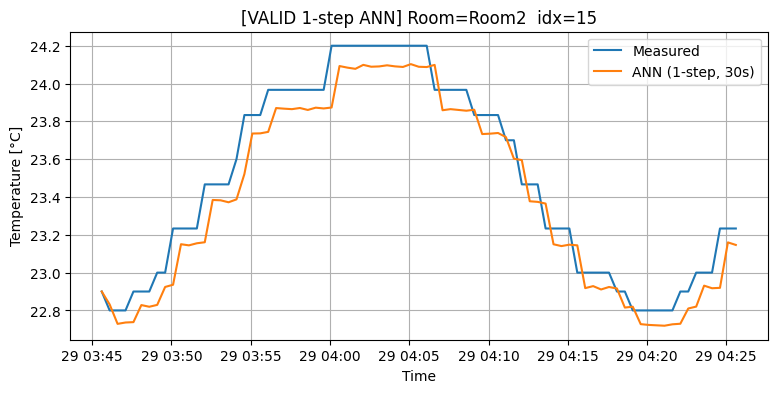

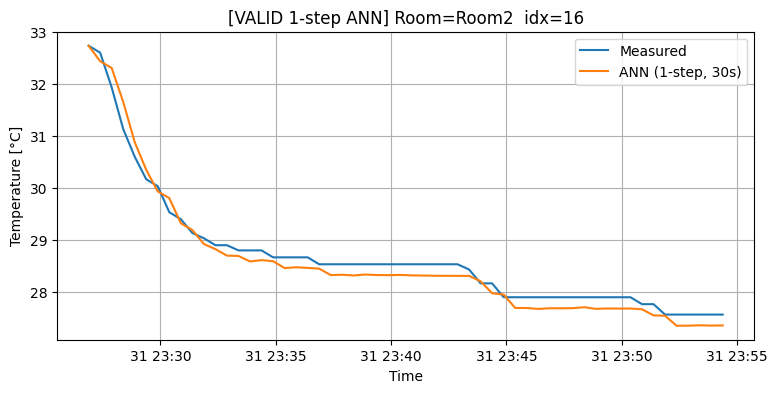

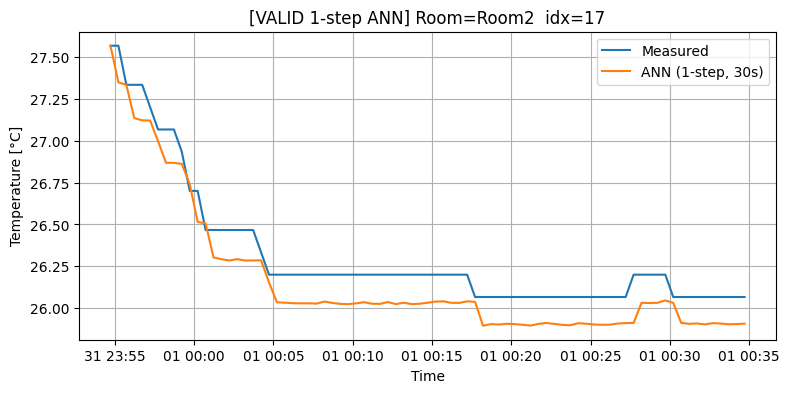

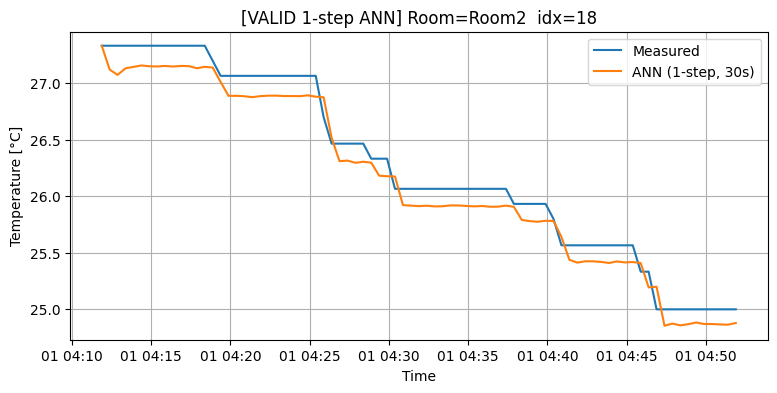

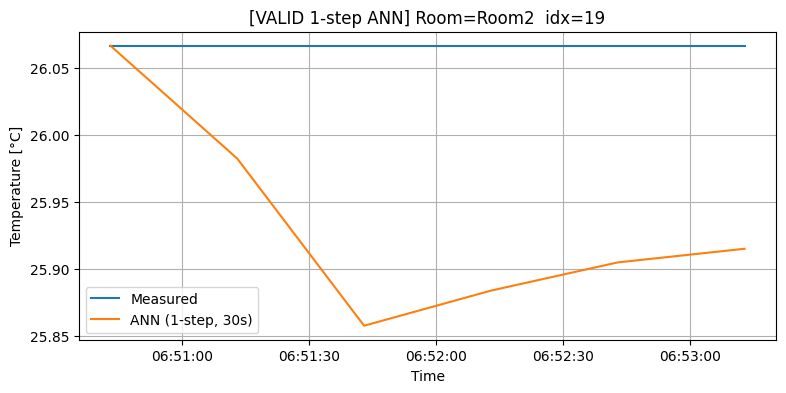

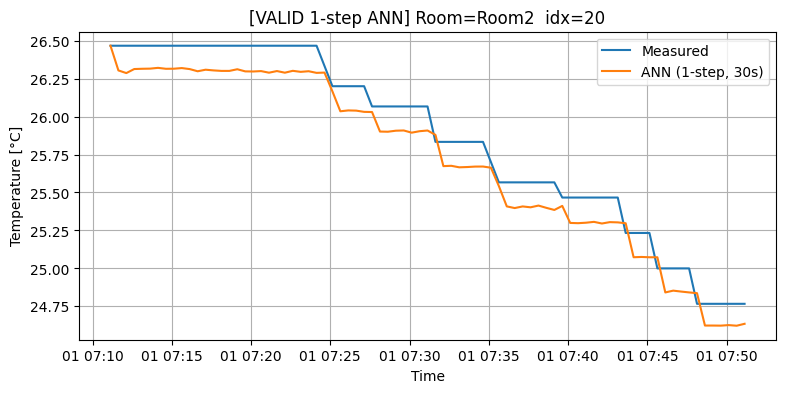

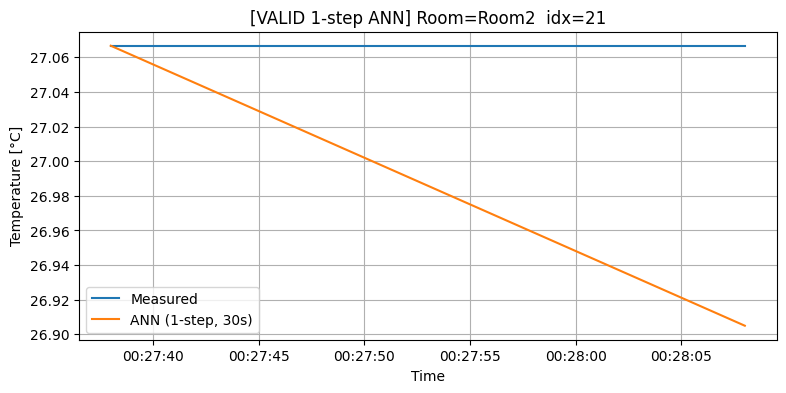

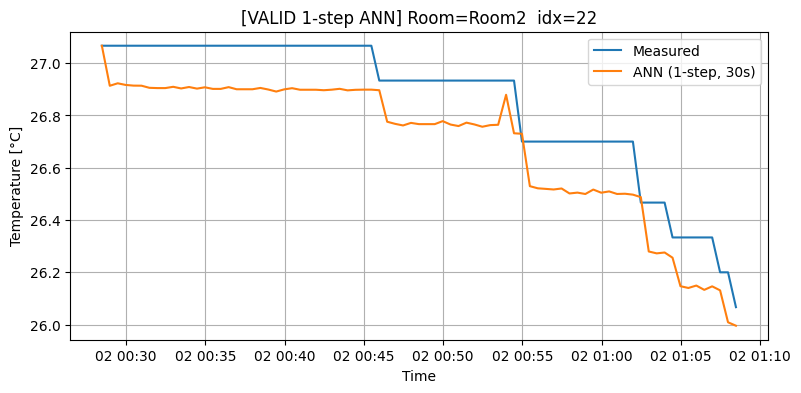

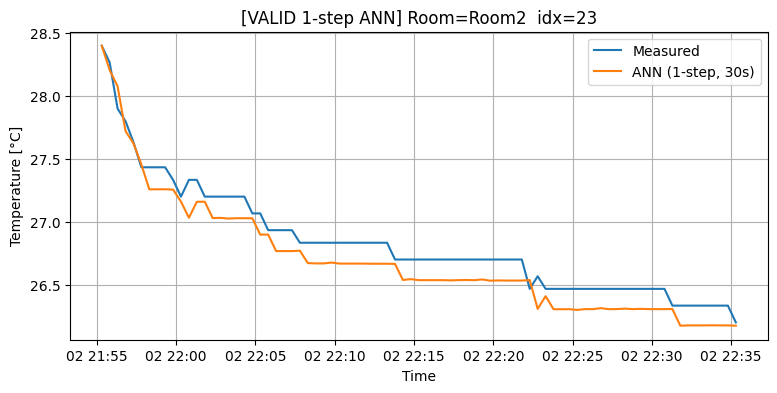

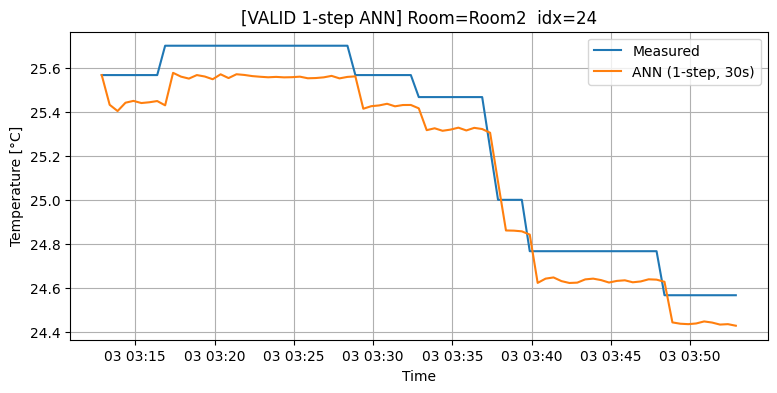

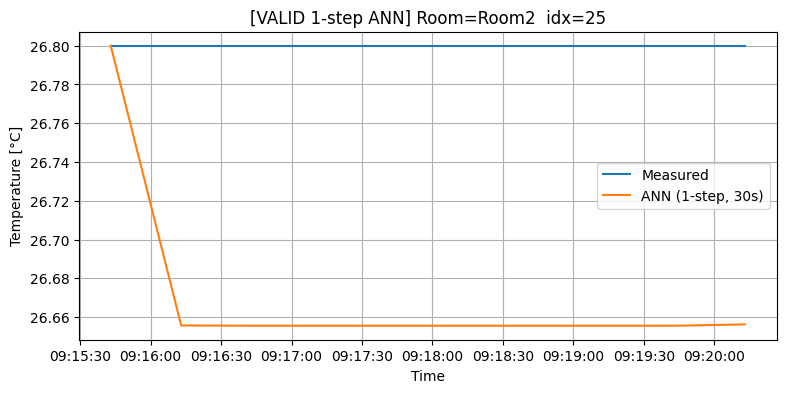

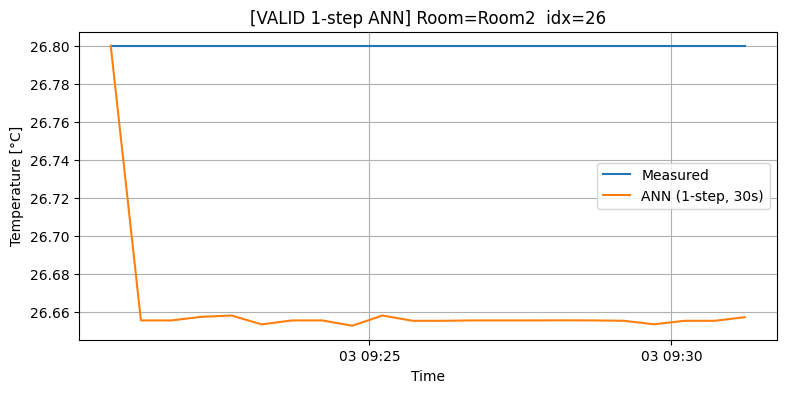

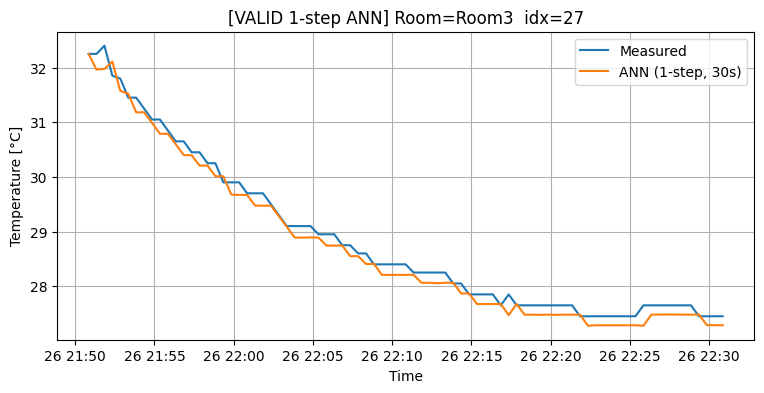

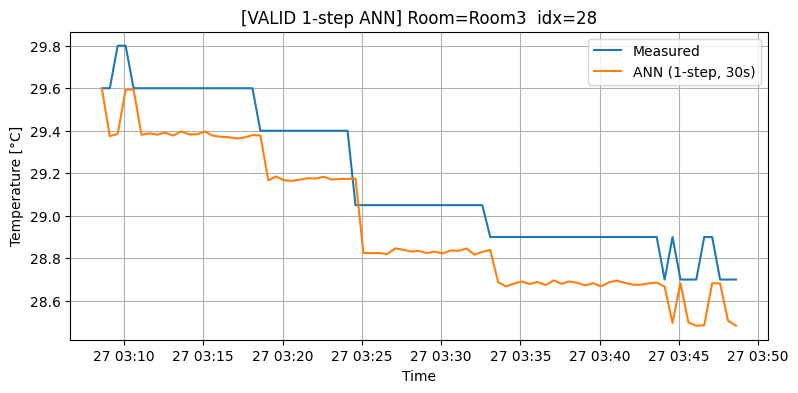

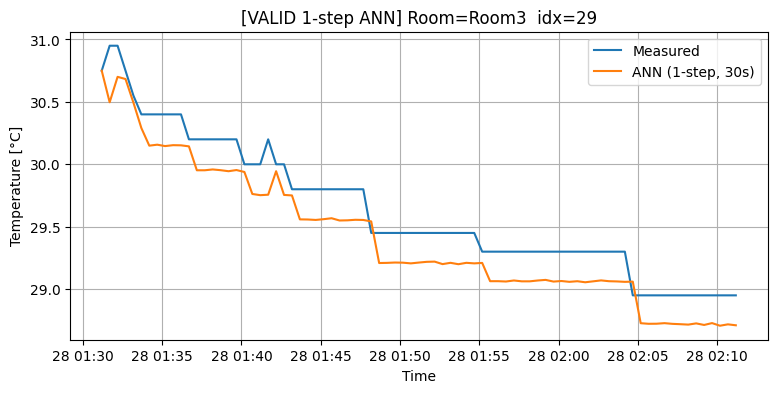

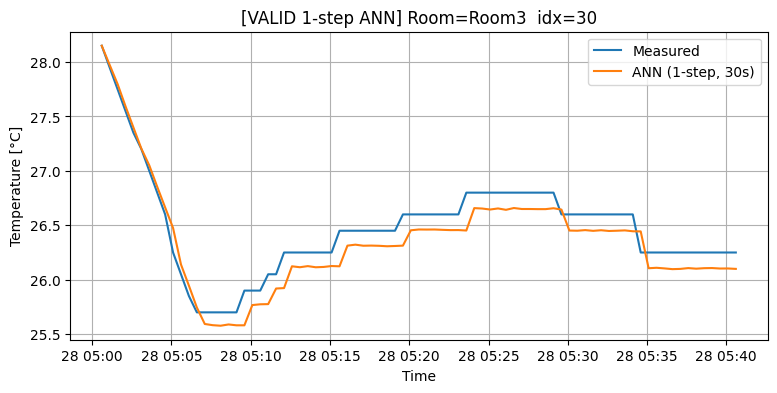

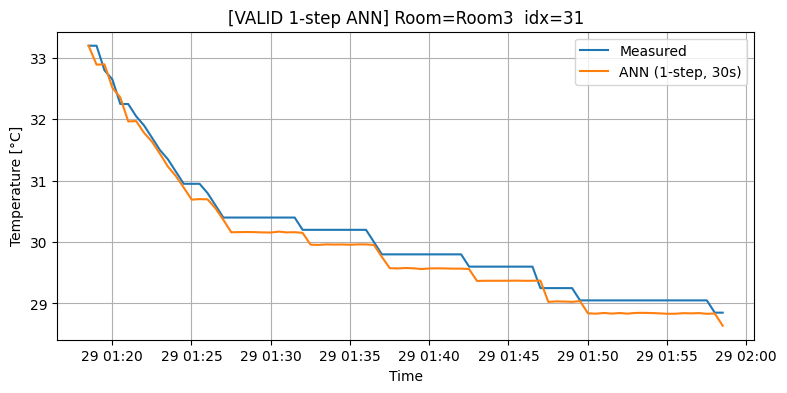

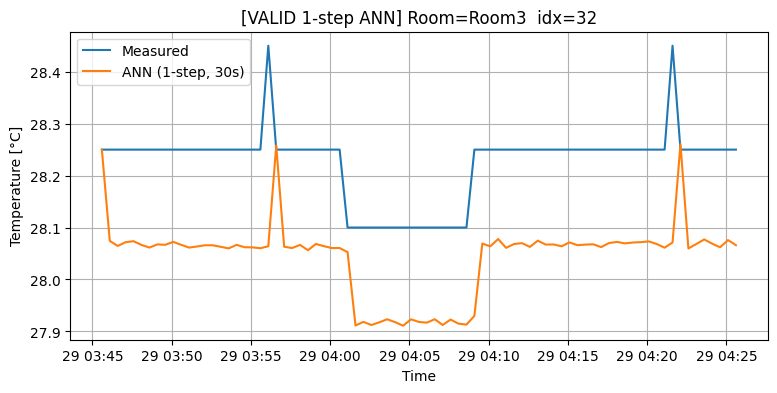

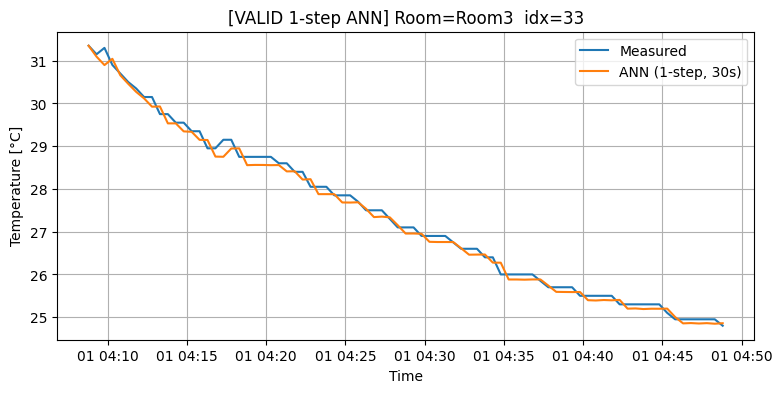

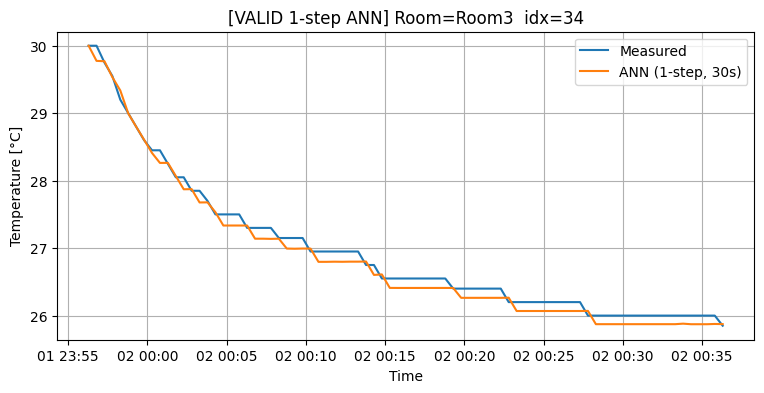

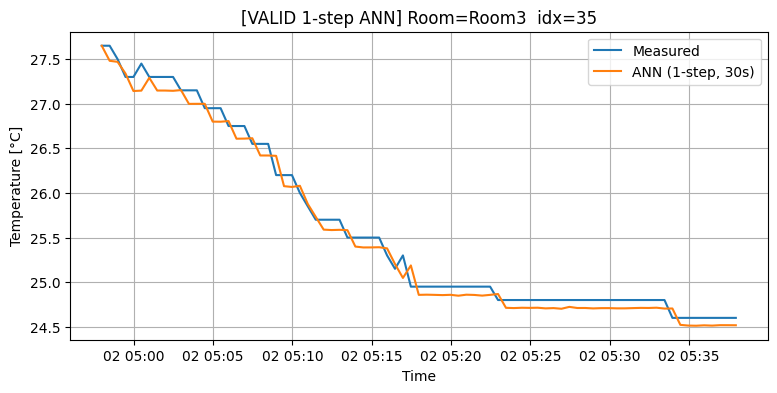

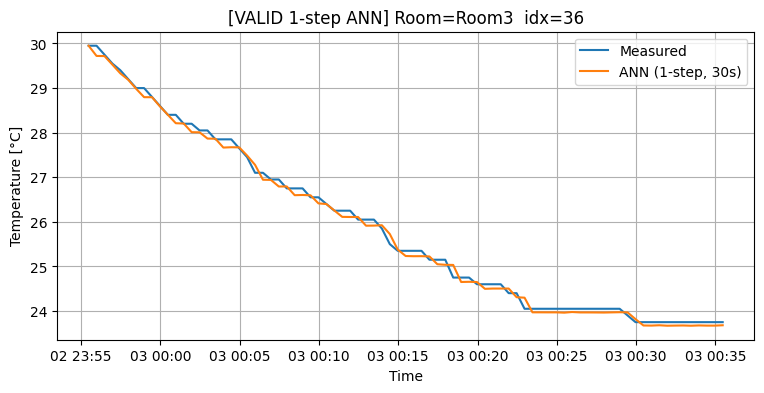

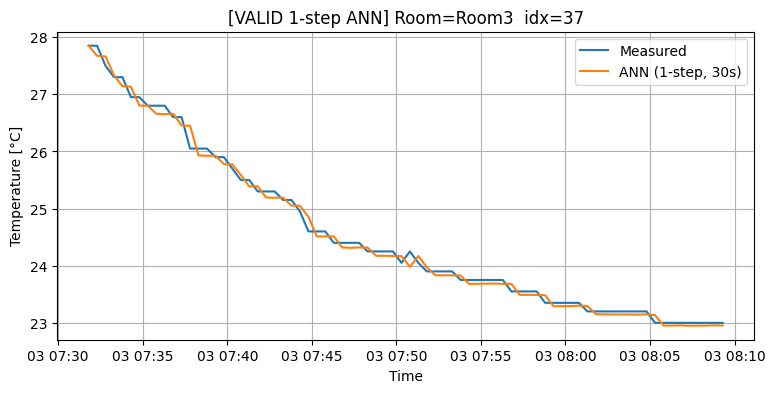

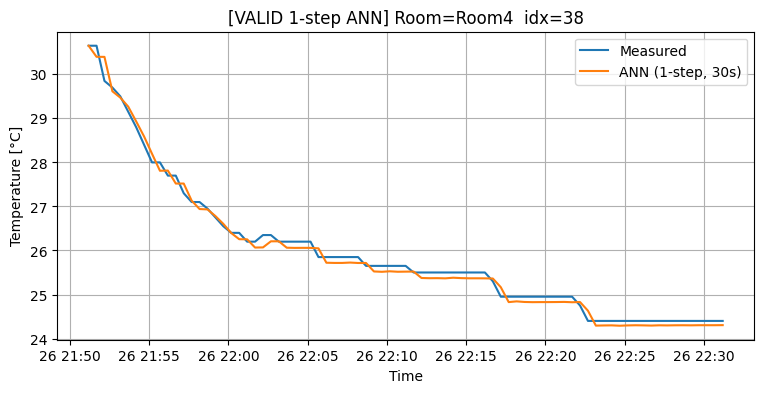

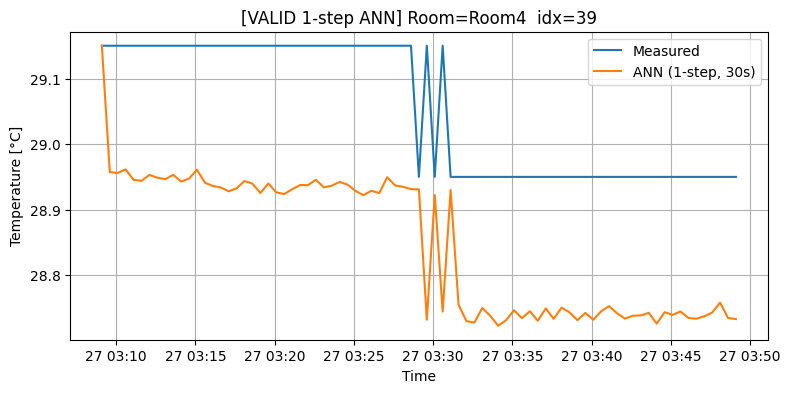

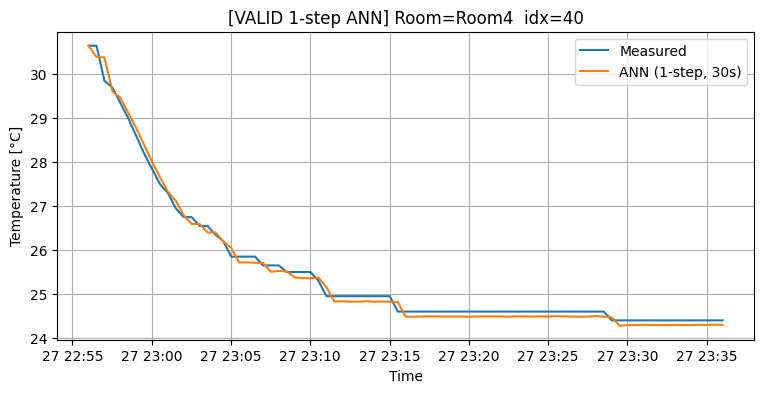

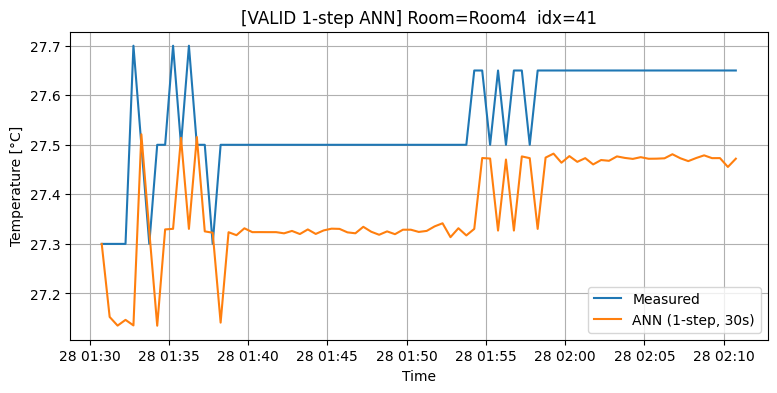

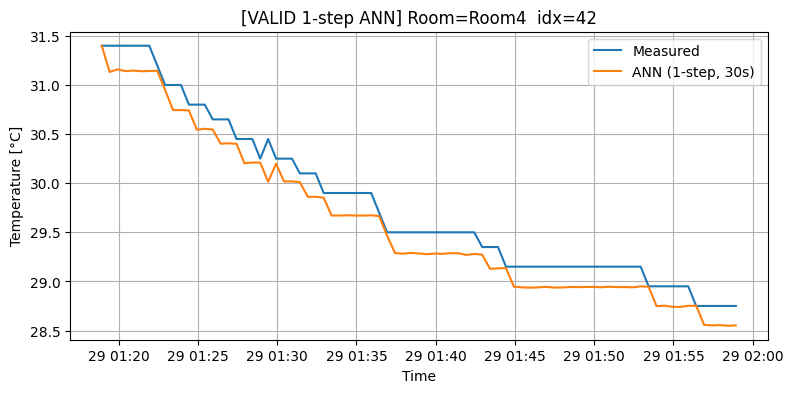

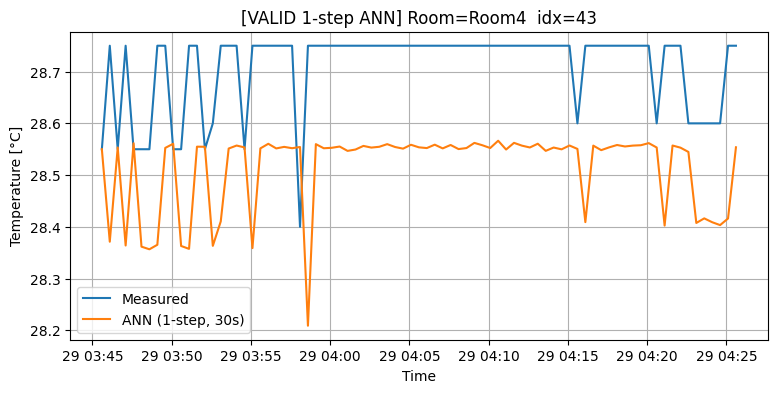

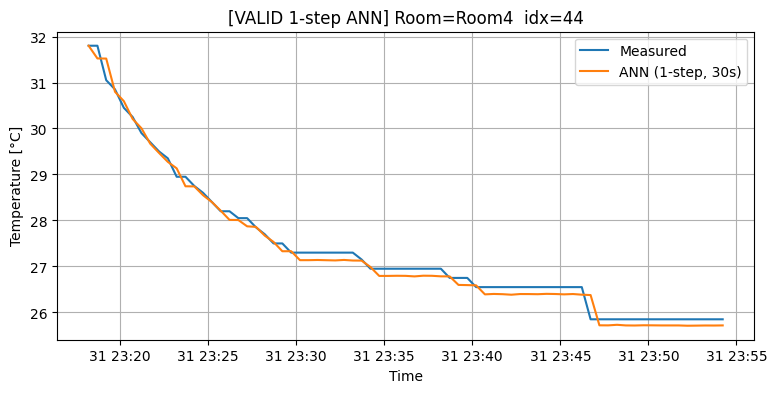

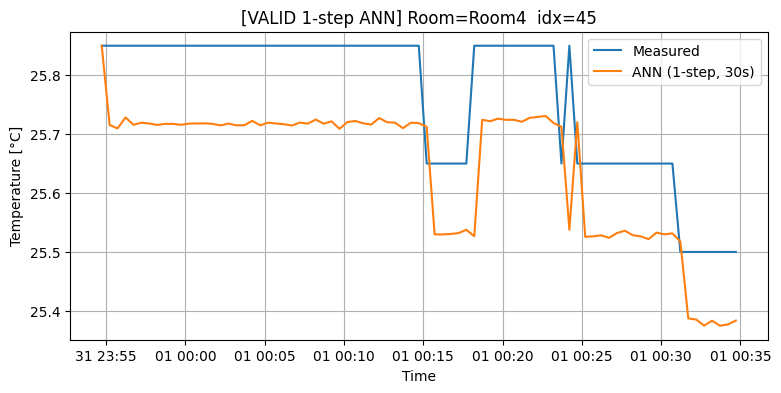

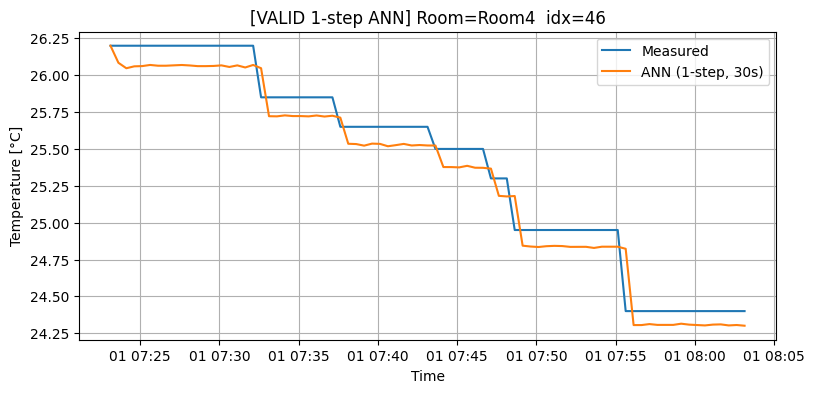

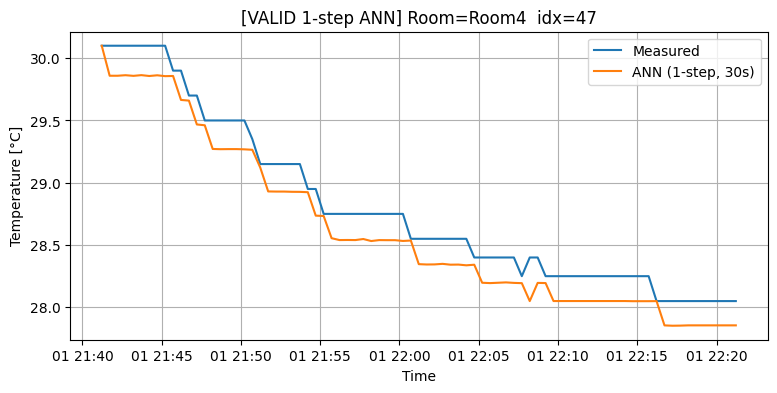

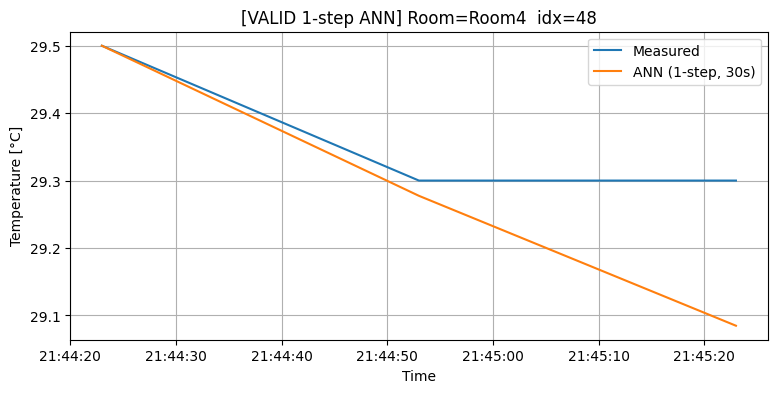

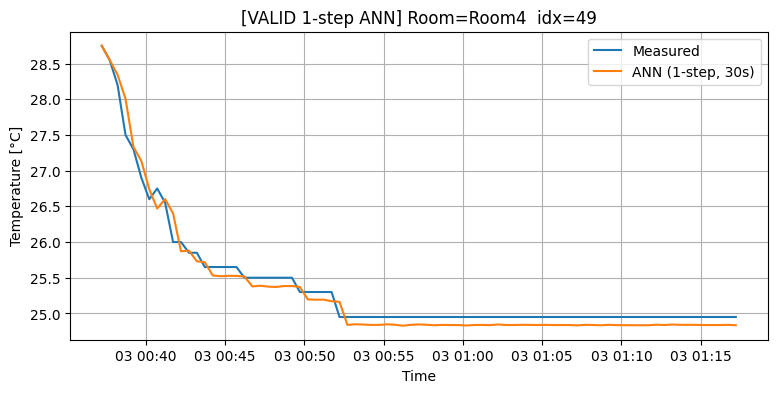

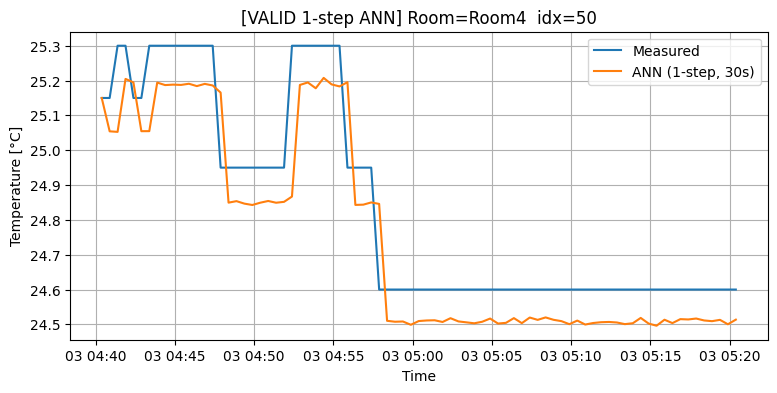

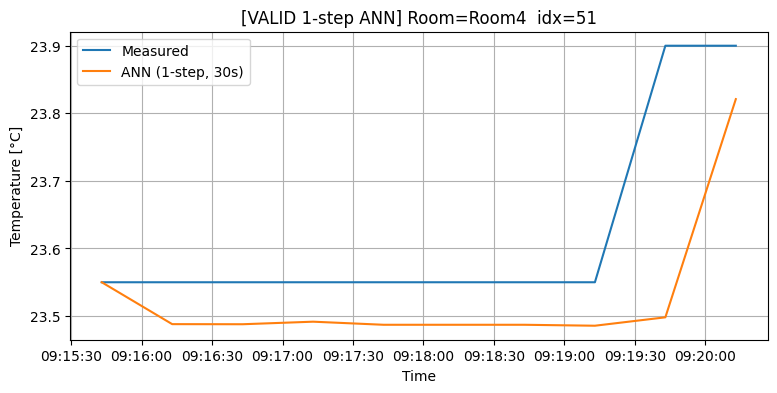

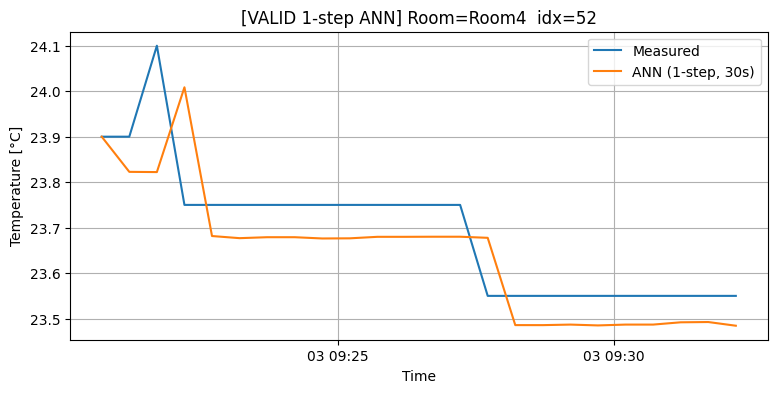

In [97]:
def plot_window_valid_ann_1s(idx):
    s = next(s for s in series_v_ann if s["idx"] == idx)
    t = s["time"]; Tm = s["T_meas"]; Tp = s["T_pred"]
    plt.figure(figsize=(9,4))
    plt.plot(t, Tm, label="Measured")
    plt.plot(t, Tp, label="ANN (1-step, 30s)")
    plt.title(f"[VALID 1-step ANN] Room={s['room']}  idx={idx}")
    plt.xlabel("Time"); plt.ylabel("Temperature [°C]")
    plt.grid(True); plt.legend()
    plt.show()

# 전체/방별 플롯
for idx in summary_valid_ann_1s["idx"].tolist():
    plot_window_valid_ann_1s(idx)

# PNG 저장
from pathlib import Path
def save_all_valid_ann_plots(out_dir="valid_1step_ann_plots"):
    Path(out_dir).mkdir(parents=True, exist_ok=True)
    for idx in summary_valid_ann_1s["idx"].tolist():
        s = next(s for s in series_v_ann if s["idx"] == idx)
        t = s["time"]; Tm = s["T_meas"]; Tp = s["T_pred"]
        plt.figure(figsize=(9,4))
        plt.plot(t, Tm, label="Measured")
        plt.plot(t, Tp, label="ANN (1-step, 30s)")
        plt.title(f"[VALID 1-step ANN] Room={s['room']}  idx={idx}")
        plt.xlabel("Time"); plt.ylabel("Temperature [°C]")
        plt.grid(True); plt.legend()
        fname = f"{out_dir}/valid_ann_1step_room-{s['room']}_idx-{idx}.png"
        plt.savefig(fname, bbox_inches="tight")
        plt.close()
    print(f"[OK] Saved → {out_dir}")


기본 PINN: 미분방정식의 해 Tid와 미지의 파라미터 식별

In [64]:
import numpy as np, pandas as pd

# --- 상수/매핑 ---
AIR_DENSITY = 1.2  # kg/m^3
RAW2STAGE   = {5:1, 1:2, 2:3, 3:4}  # 로그상의 풍량 단계(raw) -> 1~4 단계
VDOT_DEFAULT = {4:30.89363, 3:27.977, 2:23.72948, 1:21.26592}      # m^3/min
VDOT_AUTO2   = {4:18.97226, 3:16.31048, 2:13.25226, 1:11.24177}    # unit 2 전용
VDOT_AUTO10  = {4:18.49087, 3:15.74414, 2:13.25226, 1:11.24177}    # unit 10 전용

# 방/유닛 구성
ROOMS = {
    "Room1": [8, 3, 5],
    "Room2": [4, 1, 6],
    "Room3": [2, 7],
    "Room4": [9, 10, 11],
}
EXCLUDE_TID_IDS = [5, 9]  # 방 평균 Tid에서 제외

# --- 유틸: groupby 안전 평균/합 (모두 NaN이면 NaN) ---
def gb_mean_min1(gb_series: pd.core.groupby.SeriesGroupBy) -> pd.Series:
    return gb_series.apply(lambda s: s.mean(skipna=True) if s.notna().any() else np.nan)

def gb_sum_min1(gb_series: pd.core.groupby.SeriesGroupBy) -> pd.Series:
    return gb_series.apply(lambda s: s.sum(skipna=True) if s.notna().any() else np.nan)

# --- 단계 산출 ---
def compute_stage(frun: pd.Series) -> pd.Series:
    # frun이 숫자/문자 섞여 있어도 처리
    x = pd.to_numeric(frun, errors="coerce")
    st = x.map(RAW2STAGE)  # 5->1, 1->2, 2->3, 3->4
    # 그 외 값(0, NaN 등)은 0(풍량 없음)로
    st = st.fillna(0).astype(int)
    return st

# --- 유닛별 부피유량 (m^3/min) ---
def per_unit_vdot(df: pd.DataFrame) -> pd.Series:
    def table_for_unit(uid: int):
        if uid == 2:  return VDOT_AUTO2
        if uid == 10: return VDOT_AUTO10
        return VDOT_DEFAULT

    uids   = pd.to_numeric(df.get("auto_id"), errors="coerce")
    stages = df.get("stage")
    out = []
    for uid, st in zip(uids, stages):
        if pd.isna(uid) or pd.isna(st) or int(st) == 0:
            out.append(0.0)
            continue
        tbl = table_for_unit(int(uid))
        out.append(float(tbl.get(int(st), 0.0)))
    return pd.Series(out, index=df.index, dtype=float)

# --- 유닛 레벨 파생값 생성 ---
def enrich_units_leakfree(df_units_raw: pd.DataFrame) -> pd.DataFrame:
    d = df_units_raw.copy()

    # 필수 컬럼 존재 체크(없으면 생성)
    for col in ["Frun","Tcon","Tbdy","Tid","Tod","auto_id","datetime"]:
        if col not in d.columns: d[col] = np.nan

    # datetime 정규화(UTC 여부 불문, 일단 tz-naive로 둠)
    d["datetime"] = pd.to_datetime(d["datetime"], errors="coerce")

    # 풍량 단계 -> stage(1~4), 나머지 0
    d["stage"] = compute_stage(d["Frun"])

    # 부피유량/질량유량
    d["vdot_m3_min"] = per_unit_vdot(d)
    d["mdot_kg_s"]   = AIR_DENSITY * (d["vdot_m3_min"] / 60.0)

    # ON/OFF 판정: Tcon != 0 and Frun != 0
    tcon_nz = pd.to_numeric(d["Tcon"], errors="coerce").fillna(0.0)
    frun_nz = pd.to_numeric(d["Frun"], errors="coerce").fillna(0.0)
    d["is_on"] = (tcon_nz != 0) & (frun_nz != 0)

    # 정렬
    d = d.sort_values(["datetime","auto_id"]).reset_index(drop=True)
    return d

# --- 방단위 집계(누수 방지: Σmdot, Σmdot*Tbdy 만 사용; Tid는 평균에만 사용) ---
def aggregate_rooms_leakfree(df_units: pd.DataFrame) -> pd.DataFrame:
    recs = []
    d = df_units.copy()

    # auto_id -> room 매핑
    uid2room = {uid: r for r, ids in ROOMS.items() for uid in ids}
    d["room"] = d["auto_id"].map(uid2room)

    for room, g in d.dropna(subset=["room"]).groupby("room"):
        g = g.sort_values("datetime").copy()

        # 방 평균 Tod (모든 유닛 평균)
        Tod_room = gb_mean_min1(g.groupby("datetime")["Tod"])

        # 방 평균 Tid (5,9 제외 유닛만)
        valid_ids = [uid for uid in ROOMS[room] if uid not in EXCLUDE_TID_IDS]
        tid_sub = g[g["auto_id"].isin(valid_ids)]
        Tid_room = gb_mean_min1(tid_sub.groupby("datetime")["Tid"])

        # any_on (방 내 하나라도 ON)
        any_on = g.groupby("datetime")["is_on"].any()

        # ON 유닛만으로 Σmdot, Σ(md*Tbdy)
        on_rows = g[g["is_on"]].copy()
        S_mdot_sum   = gb_sum_min1(on_rows.groupby("datetime")["mdot_kg_s"])
        # Tbdy가 NaN이면 0 기여
        on_rows["mdot_Tbdy"] = on_rows["mdot_kg_s"] * pd.to_numeric(on_rows["Tbdy"], errors="coerce").fillna(0.0)
        S_mdotTb_sum = gb_sum_min1(on_rows.groupby("datetime")["mdot_Tbdy"])

        room_df = pd.DataFrame({
            "datetime": Tod_room.index,
            "room": room,
            "Tod_room": Tod_room.values,
            "Tid_room": Tid_room.reindex(Tod_room.index).values,
            "any_on": any_on.reindex(Tod_room.index).values,
            "S_mdot_sum": S_mdot_sum.reindex(Tod_room.index).values,
            "S_mdotTb_sum": S_mdotTb_sum.reindex(Tod_room.index).values,
        })

        # 방 내 전부 OFF인 시각은 제외(훈련/평가에 의미 없음)
        room_df = room_df[room_df["any_on"].fillna(False)]
        recs.append(room_df)

    if not recs:
        return pd.DataFrame(columns=["datetime","room","Tod_room","Tid_room","any_on","S_mdot_sum","S_mdotTb_sum"])

    out = (pd.concat(recs, ignore_index=True)
             .sort_values(["datetime","room"])
             .reset_index(drop=True))
    return out

# ==== 사용 예시 ====
# 1) 학습셋
# df_units_raw = load_all_csvs_schema_fixed("/home/deok/Desktop/LOG_SMART_202508", tz="Asia/Seoul")
# df_units = enrich_units_leakfree(df_units_raw)
# df_rooms_LF = aggregate_rooms_leakfree(df_units)
# print(df_rooms_LF.shape); df_rooms_LF.head()

# 2) 검증셋
# valid_units_raw = load_all_csvs_schema_fixed("/home/deok/Desktop/LOG_SMART_202508_valid", tz="Asia/Seoul")
# valid_units = enrich_units_leakfree(valid_units_raw)
# valid_rooms_LF = aggregate_rooms_leakfree(valid_units)
# print(valid_rooms_LF.shape); valid_rooms_LF.head()


In [65]:
# =========================
# 누수 방지 입력 전처리 실행 스크립트
# - 학습/검증 디렉터리에서 CSV 로드
# - 유닛 단계/유량 → 질량유량 계산
# - 방 단위 집계: Tid 평균(5,9 제외), Tod 평균, any_on,
#                 S_mdot_sum=Σ mdot_i, S_mdotTb_sum=Σ (mdot_i*Tbdy_i)
# - 결과를 CSV로 저장
# =========================

import pandas as pd
from pathlib import Path

# --- 디렉터리 설정 ---
TRAIN_DIR = "/home/deok/Desktop/LOG_SMART_202508"
VALID_DIR = "/home/deok/Desktop/LOG_SMART_202508_valid"

# --- 로더 호환 호출 (tz 인자 유무 대응) ---
def load_dir_compat(dir_path: str, tz="Asia/Seoul") -> pd.DataFrame:
    assert Path(dir_path).exists(), f"디렉터리 없음: {dir_path}"
    try:
        df = load_all_csvs_schema_fixed(dir_path, tz=tz)
    except TypeError:
        df = load_all_csvs_schema_fixed(dir_path)
    return df

# --- 전처리 파이프라인 실행 ---
def run_pipeline_leakfree(source_dir: str, out_prefix: str):
    print(f"[LOAD] {source_dir}")
    df_units_raw = load_dir_compat(source_dir)

    print(f"[ENRICH] units -> stages/flows/mdot/is_on …")
    df_units = enrich_units_leakfree(df_units_raw)

    print(f"[AGG] rooms leak-free features …")
    df_rooms_LF = aggregate_rooms_leakfree(df_units)

    # 정리/저장
    df_units_out  = df_units.sort_values(["datetime","auto_id"]).reset_index(drop=True)
    df_rooms_out  = df_rooms_LF.sort_values(["datetime","room"]).reset_index(drop=True)

    units_csv = f"{out_prefix}_units_enriched.csv"
    rooms_csv = f"{out_prefix}_rooms_leakfree.csv"

    df_units_out.to_csv(units_csv, index=False)
    df_rooms_out.to_csv(rooms_csv, index=False)

    # 요약 출력
    def _rng(s):
        return f"{pd.to_datetime(s.min())} → {pd.to_datetime(s.max())}" if len(s) else "N/A"
    print(f"[DONE] units: {df_units_out.shape}, rooms: {df_rooms_out.shape}")
    if not df_rooms_out.empty:
        print(f"[TIME RANGE] { _rng(df_rooms_out['datetime']) }")
        print(df_rooms_out.groupby('room')[['Tid_room','Tod_room','S_mdot_sum','S_mdotTb_sum']].count()\
              .rename(columns={'Tid_room':'n_Tid','Tod_room':'n_Tod','S_mdot_sum':'n_Smdot','S_mdotTb_sum':'n_SmdotTb'}))

    return df_units_out, df_rooms_out, units_csv, rooms_csv

# === 실행 ===
train_units, train_rooms_LF, train_units_csv, train_rooms_csv = run_pipeline_leakfree(TRAIN_DIR, out_prefix="train")
print(f"[SAVED] {train_units_csv}\n[SAVED] {train_rooms_csv}")

valid_units, valid_rooms_LF, valid_units_csv, valid_rooms_csv = run_pipeline_leakfree(VALID_DIR, out_prefix="valid")
print(f"[SAVED] {valid_units_csv}\n[SAVED] {valid_rooms_csv}")

# 참고: 이후 모델 입력 매핑
#  - T_od(t)         ← train_rooms_LF['Tod_room']
#  - S_{mdot}(t)     ← train_rooms_LF['S_mdot_sum']
#  - S_{mdotTb}(t)   ← train_rooms_LF['S_mdotTb_sum']
#  - 상태 T(t)       ← train_rooms_LF['Tid_room'] (초기조건/관측용; 입력 피처로 쓰지 말 것)


[LOAD] /home/deok/Desktop/LOG_SMART_202508
[ENRICH] units -> stages/flows/mdot/is_on …
[AGG] rooms leak-free features …
[DONE] units: (4798801, 14), rooms: (323655, 7)
[TIME RANGE] 2025-08-01 13:25:07+09:00 → 2025-08-26 18:52:01+09:00
       n_Tid  n_Tod  n_Smdot  n_SmdotTb
room                                   
Room1  78395  78395    78395      78395
Room2  82743  82743    82743      82743
Room3  78294  78294    78294      78294
Room4  84223  84223    84223      84223
[SAVED] train_units_enriched.csv
[SAVED] train_rooms_leakfree.csv
[LOAD] /home/deok/Desktop/LOG_SMART_202508_valid
[ENRICH] units -> stages/flows/mdot/is_on …
[AGG] rooms leak-free features …
[DONE] units: (1519852, 14), rooms: (136807, 7)
[TIME RANGE] 2025-08-27 06:50:51+09:00 → 2025-09-03 18:32:23+09:00
       n_Tid  n_Tod  n_Smdot  n_SmdotTb
room                                   
Room1  31241  31241    31241      31241
Room2  34736  34736    34736      34736
Room3  31703  31703    31703      31703
Room4  39127  3912

In [75]:
# ===========================================
# 방별 개별 PINN(A안) 학습 스크립트
# 전제:
#   - train_rooms_LF (필드: datetime, room, Tid_room, Tod_room, S_mdot_sum, S_mdotTb_sum)
#   - (선택) valid_rooms_LF
# ===========================================
import numpy as np, pandas as pd, torch, torch.nn as nn
from torch.utils.data import Dataset, DataLoader

# ---------- 유틸: 시간축/세션 ----------
def to_epoch_sec(ts):
    dt = pd.to_datetime(ts, utc=True)
    if isinstance(dt, (pd.Series, pd.Index, np.ndarray)):
        return pd.to_datetime(dt).astype("int64") // 10**9
    else:
        return int(pd.to_datetime(dt).value // 10**9)

def group_contiguous_5s(dts):
    t = to_epoch_sec(dts).values
    dt = np.diff(t, prepend=t[0])
    return np.cumsum(dt != 5)

def make_pinn_table_room(df_rooms_LF: pd.DataFrame, room_name: str) -> pd.DataFrame:
    g = df_rooms_LF[df_rooms_LF["room"] == room_name].copy()
    if g.empty:
        return pd.DataFrame(columns=["room","session","t_min","Tid","Tod","Smdot","SmdotTb"])
    g = g.sort_values("datetime")
    sid = group_contiguous_5s(g["datetime"])
    recs = []
    for s, seg in g.groupby(sid):
        if len(seg) < 2: 
            continue
        t_abs = to_epoch_sec(seg["datetime"]).values.astype(float)
        t0 = t_abs[0]
        tau_min = (t_abs - t0) / 60.0  # 분
        recs.append(pd.DataFrame({
            "room": room_name,
            "session": f"{room_name}_{s}",
            "t_min": tau_min,
            "Tid": seg["Tid_room"].astype(float).values,
            "Tod": seg["Tod_room"].astype(float).values,
            "Smdot": seg["S_mdot_sum"].astype(float).values,
            "SmdotTb": seg["S_mdotTb_sum"].astype(float).values,
        }))
    out = pd.concat(recs, ignore_index=True) if recs else pd.DataFrame(
        columns=["room","session","t_min","Tid","Tod","Smdot","SmdotTb"]
    )
    return out.dropna(subset=["t_min","Tid","Tod","Smdot","SmdotTb"]).reset_index(drop=True)

# ---------- Dataset ----------
class PINNDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.from_numpy(X.astype(np.float32))
        self.y = torch.from_numpy(y.astype(np.float32))
    def __len__(self): return len(self.X)
    def __getitem__(self, i): return self.X[i], self.y[i]

# ---------- 모델(방별 독립) ----------
class MLP(nn.Module):
    def __init__(self, in_dim=4, hid=128, out_dim=1):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, hid), nn.Tanh(),
            nn.Linear(hid, hid),    nn.Tanh(),
            nn.Linear(hid, out_dim),
        )
    def forward(self, x): return self.net(x)

class RoomPINN(nn.Module):
    def __init__(self, in_dim=4, hid=128):
        super().__init__()
        self.func = MLP(in_dim, hid, out_dim=1)
        # λ 재매개변수화(부호 보장)
        self.r1 = nn.Parameter(torch.tensor(0.0))  # λ1 (자유)
        self.r2 = nn.Parameter(torch.tensor(0.0))  # λ2 -> -softplus <0
        self.r3 = nn.Parameter(torch.tensor(0.0))  # λ3 (자유)
        self.r4 = nn.Parameter(torch.tensor(0.0))  # λ4 -> +softplus >0
        self.eps = 1e-6
    def lambdas(self):
        lam1 = self.r1
        lam2 = -nn.functional.softplus(self.r2)
        lam3 = self.r3
        lam4 =  nn.functional.softplus(self.r4) + self.eps
        return lam1, lam2, lam3, lam4
    def forward(self, x):  # \hat T_\phi(t,u)
        return self.func(x)

# ---------- 학습 루틴(단일 방) ----------
def train_one_room(room_name: str,
                   df_train_rooms: pd.DataFrame,
                   df_valid_rooms: pd.DataFrame=None,
                   batch_size=4096, epochs=80,
                   w_data=1.0, w_phys=1.0, hid=128, lr=2e-3, weight_decay=1e-4,
                   device=None):
    device = device or (torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu"))

    # 테이블 생성
    tab_tr = make_pinn_table_room(df_train_rooms, room_name)
    assert len(tab_tr), f"[{room_name}] 학습 데이터 없음"
    X_tr = tab_tr[["t_min","Tod","Smdot","SmdotTb"]].values.astype(np.float32)
    y_tr = tab_tr[["Tid"]].values.astype(np.float32)

    # z-score(방별로 독립 통계 사용)
    x_mean = X_tr.mean(axis=0); x_std = X_tr.std(axis=0) + 1e-8
    z = lambda X: (X - x_mean) / x_std
    Xtr = z(X_tr)

    # valid (있으면)
    Xva = yva = None
    if df_valid_rooms is not None and not df_valid_rooms.empty:
        tab_va = make_pinn_table_room(df_valid_rooms, room_name)
        if len(tab_va):
            Xva = z(tab_va[["t_min","Tod","Smdot","SmdotTb"]].values.astype(np.float32))
            yva = tab_va[["Tid"]].values.astype(np.float32)

    # DataLoader
    train_loader = DataLoader(PINNDataset(Xtr,y_tr), batch_size=batch_size, shuffle=True)
    valid_loader = DataLoader(PINNDataset(Xva,yva), batch_size=8192, shuffle=False) if Xva is not None else None

    # 모델/옵티마이저
    model = RoomPINN(in_dim=4, hid=hid).to(device)
    opt = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
    mse = nn.MSELoss()

    # 체인룰 보정(시간 성분 z→raw)
    x_mean_t = torch.from_numpy(x_mean.astype(np.float32)).to(device)
    x_std_t  = torch.from_numpy(x_std.astype(np.float32)).to(device)
    sigma_t_t = x_std_t[0:1].view(1,1)

    def physics_residual(x_z, T_hat):
        x_raw = x_z * x_std_t + x_mean_t
        Tod     = x_raw[:,1:2]
        Smdot   = x_raw[:,2:3]
        SmdotTb = x_raw[:,3:4]
        lam1, lam2, lam3, lam4 = model.lambdas()
        f_phys = lam1*Tod + (lam2 - lam4*Smdot)*T_hat + lam3 + lam4*SmdotTb
        return f_phys

    @torch.no_grad()
    def eval_loader(loader):
        if loader is None: return np.nan
        model.eval()
        ev, n = 0.0, 0
        for xb, yb in loader:
            xb, yb = xb.to(device), yb.to(device)
            Th = model(xb)
            ev += mse(Th, yb).item() * xb.size(0)
            n += xb.size(0)
        rmse = float(np.sqrt(ev / max(n,1)))
        return rmse

    best_rmse = np.inf; best_state = None
    for ep in range(1, epochs+1):
        # train
        model.train()
        tr_loss, n = 0.0, 0
        for xb, yb in train_loader:
            xb = xb.to(device).requires_grad_(True)
            yb = yb.to(device)

            opt.zero_grad()
            T_hat = model(xb)

            grads = torch.autograd.grad(
                outputs=T_hat, inputs=xb,
                grad_outputs=torch.ones_like(T_hat),
                create_graph=True, retain_graph=True, only_inputs=True
            )[0]
            dTdt = grads[:,0:1] / (sigma_t_t + 1e-8)

            f_phys = physics_residual(xb, T_hat)
            R = dTdt - f_phys

            loss = w_data*mse(T_hat, yb) + w_phys*mse(R, torch.zeros_like(R))
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 5.0)
            opt.step()

            bs = xb.size(0); tr_loss += loss.item()*bs; n += bs
        tr_loss /= max(n,1)

        # valid RMSE(데이터 오차)
        vl_rmse = eval_loader(valid_loader)

        if vl_rmse < best_rmse - 1e-5:
            best_rmse = vl_rmse
            best_state = {k: v.detach().cpu().clone() for k,v in model.state_dict().items()}

        if ep % 5 == 0 or ep == 1:
            lam1, lam2, lam3, lam4 = [float(x.detach().cpu()) for x in model.lambdas()]
            msg = f"[{room_name}][{ep:03d}] train L={tr_loss:.4f}"
            if not np.isnan(vl_rmse): msg += f" | val RMSE={vl_rmse:.4f}"
            msg += f" | λ1={lam1:.3f}, λ2={lam2:.3f}, λ3={lam3:.3f}, λ4={lam4:.3f}"
            print(msg)

    if best_state is not None:
        model.load_state_dict(best_state)

    # 최종 요약
    lam1, lam2, lam3, lam4 = [float(x.detach().cpu()) for x in model.lambdas()]
    print(f"[{room_name}] DONE | best val RMSE={best_rmse:.4f} | "
          f"λ1={lam1:.6f}, λ2={lam2:.6f}, λ3={lam3:.6f}, λ4={lam4:.6f}")

    return {
        "model": model,
        "x_mean": x_mean, "x_std": x_std,
        "best_val_rmse": best_rmse,
        "lambdas": (lam1, lam2, lam3, lam4),
    }

# ---------- 전체 방 학습 실행 ----------
assert 'train_rooms_LF' in globals(), "train_rooms_LF가 필요함"
rooms = sorted(train_rooms_LF['room'].unique().tolist())
print("Rooms to train:", rooms)

room_artifacts = {}
for r in rooms:
    df_va = valid_rooms_LF if 'valid_rooms_LF' in globals() else None
    art = train_one_room(
        room_name=r,
        df_train_rooms=train_rooms_LF,
        df_valid_rooms=df_va,
        batch_size=4096, epochs=80,
        w_data=1.0, w_phys=1.0, hid=128, lr=2e-3, weight_decay=1e-4
    )
    room_artifacts[r] = art

# room_artifacts['Room1']['model']  # 개별 방 모델
# room_artifacts['Room1']['x_mean'], room_artifacts['Room1']['x_std']  # 방별 스케일러
# room_artifacts['Room1']['lambdas']  # 방별 λ


Rooms to train: ['Room1', 'Room2', 'Room3', 'Room4']
[Room1][001] train L=631.2506 | val RMSE=19.1807 | λ1=-0.039, λ2=-0.711, λ3=-0.039, λ4=0.675
[Room1][005] train L=121.0303 | val RMSE=8.5587 | λ1=0.093, λ2=-0.627, λ3=0.093, λ4=0.695
[Room1][010] train L=28.3147 | val RMSE=3.6790 | λ1=0.304, λ2=-0.523, λ3=0.305, λ4=0.707
[Room1][015] train L=1.2692 | val RMSE=1.2667 | λ1=0.427, λ2=-0.457, λ3=0.457, λ4=0.673
[Room1][020] train L=1.0272 | val RMSE=1.3027 | λ1=0.403, λ2=-0.426, λ3=0.515, λ4=0.716
[Room1][025] train L=0.9399 | val RMSE=1.3163 | λ1=0.379, λ2=-0.397, λ3=0.574, λ4=0.738
[Room1][030] train L=0.8748 | val RMSE=1.3340 | λ1=0.357, λ2=-0.371, λ3=0.634, λ4=0.736
[Room1][035] train L=0.8143 | val RMSE=1.3840 | λ1=0.333, λ2=-0.348, λ3=0.691, λ4=0.713
[Room1][040] train L=0.7550 | val RMSE=1.3890 | λ1=0.309, λ2=-0.326, λ3=0.749, λ4=0.674
[Room1][045] train L=0.6953 | val RMSE=1.4292 | λ1=0.285, λ2=-0.305, λ3=0.808, λ4=0.626
[Room1][050] train L=0.6339 | val RMSE=1.4686 | λ1=0.261, λ

[TRAIN] windows=113, evaluated=113
       count      mean       std       min       25%       50%       75%  \
room                                                                       
Room1   27.0  1.392988  1.289817  0.001758  0.162337  0.898069  2.659874   
Room2   30.0  1.014846  0.957449  0.000102  0.302489  0.653065  1.491968   
Room3   27.0  1.877476  1.805062  0.002600  0.321465  1.550682  2.989033   
Room4   29.0  0.590990  0.568993  0.000178  0.310360  0.401680  0.617390   

            max  
room             
Room1  3.821320  
Room2  3.324923  
Room3  5.636793  
Room4  2.595655  
picked indices: [7, 9, 22, 28, 36, 52, 60, 66, 76, 98, 99, 104]


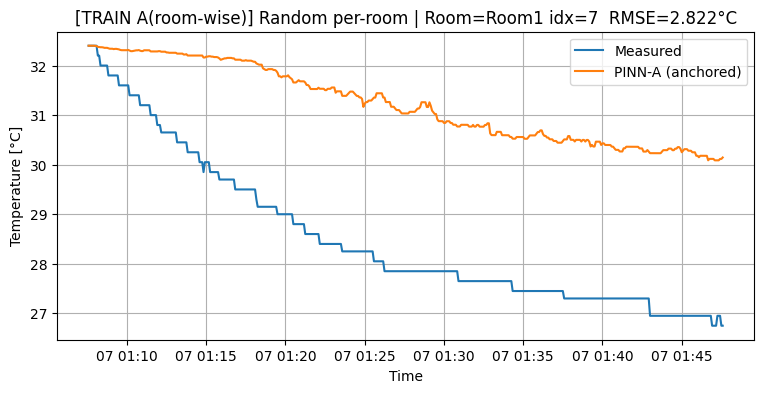

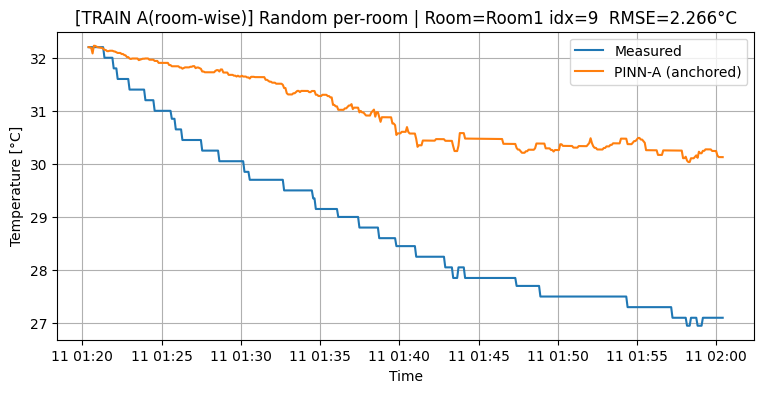

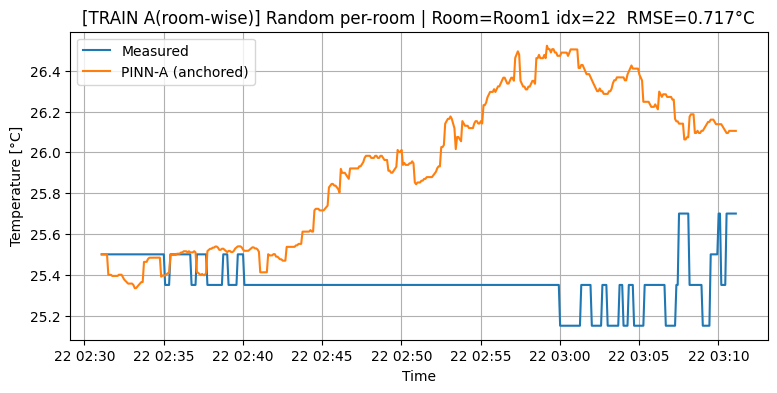

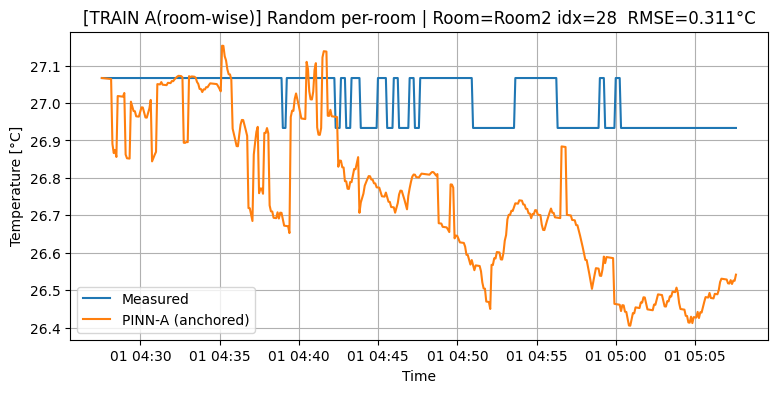

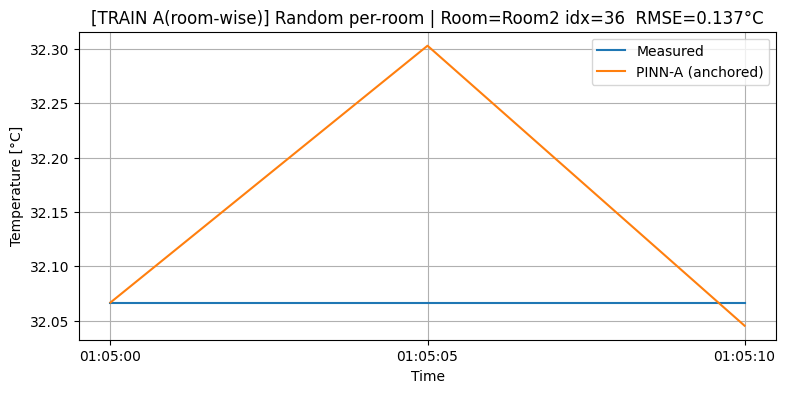

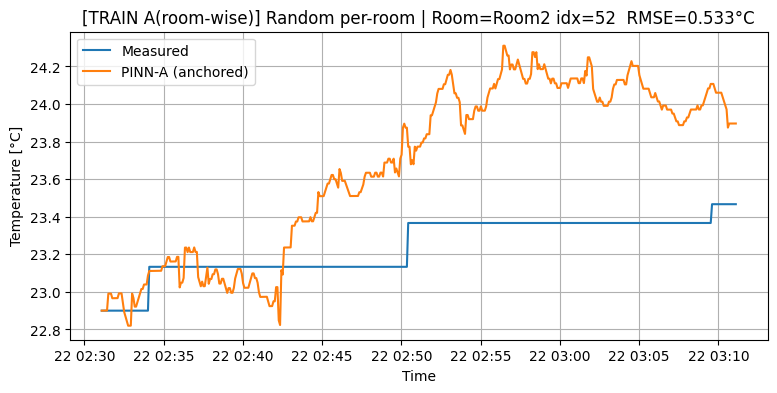

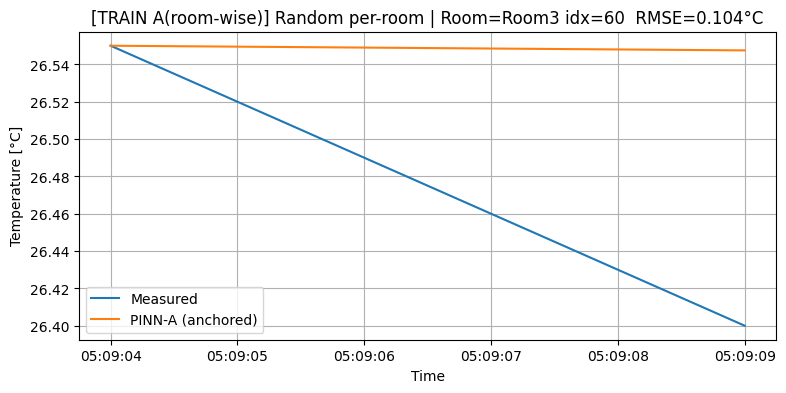

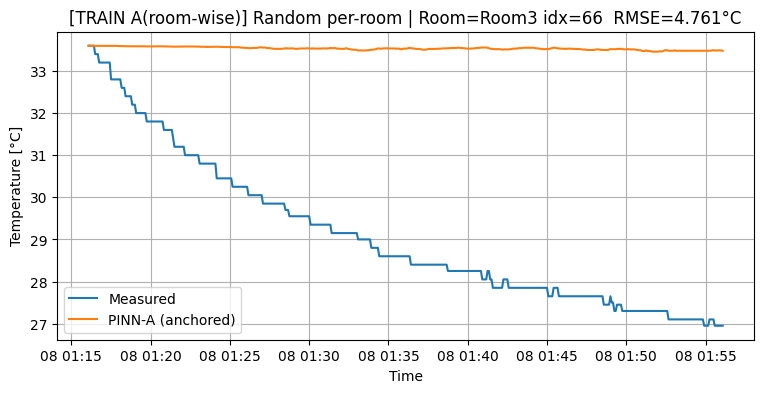

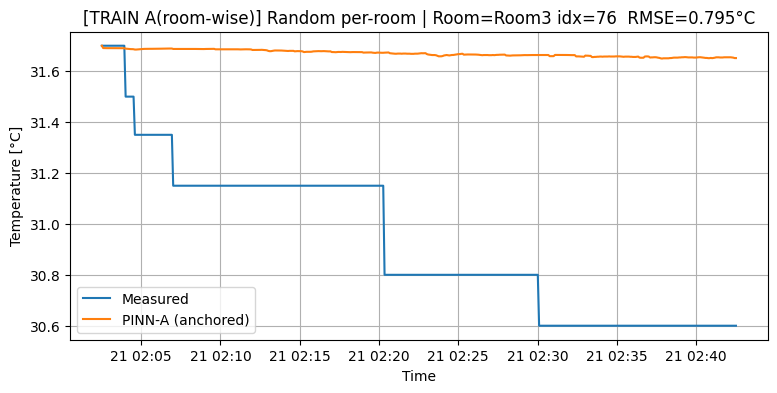

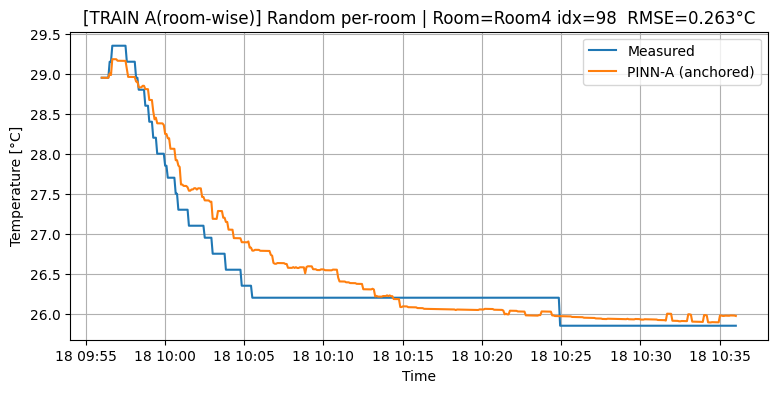

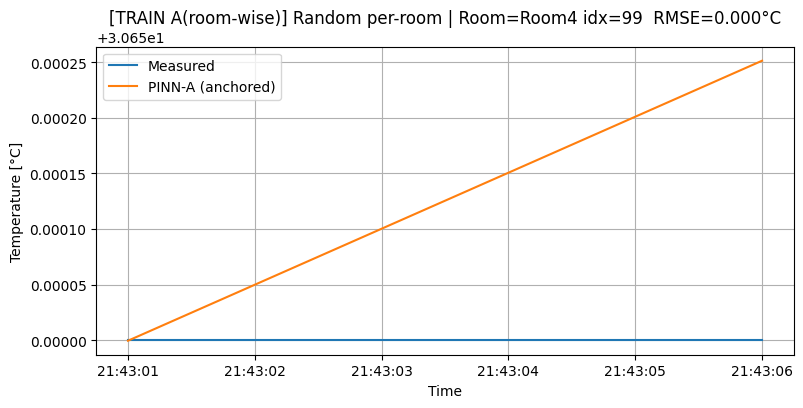

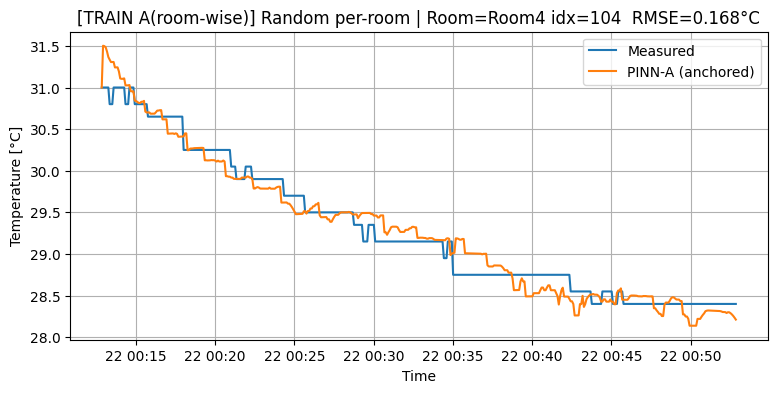

best/median/worst per room: [4, 10, 15, 34, 46, 47, 61, 63, 68, 86, 99, 112]


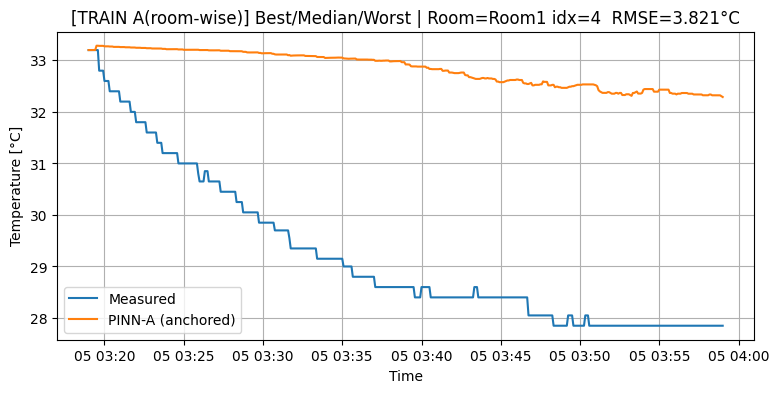

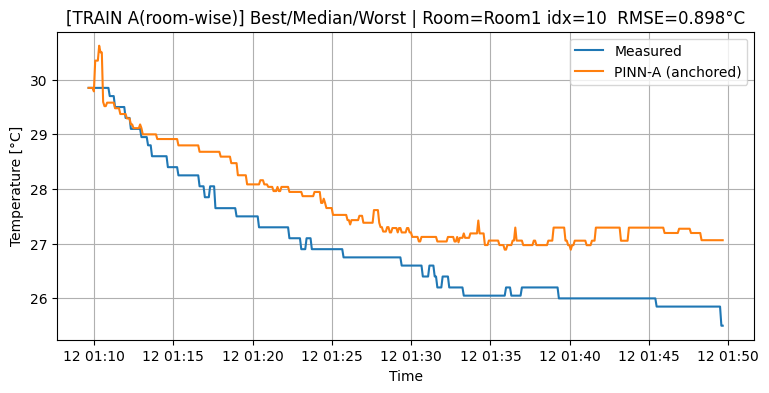

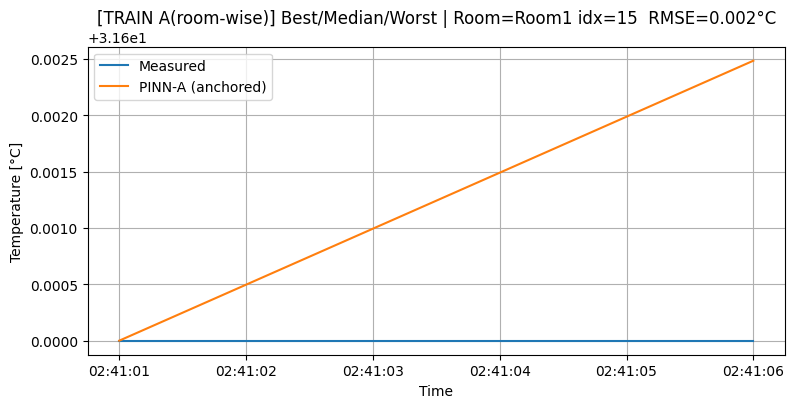

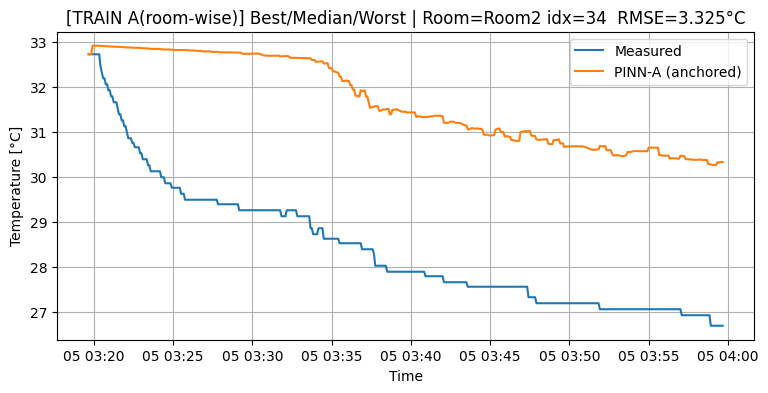

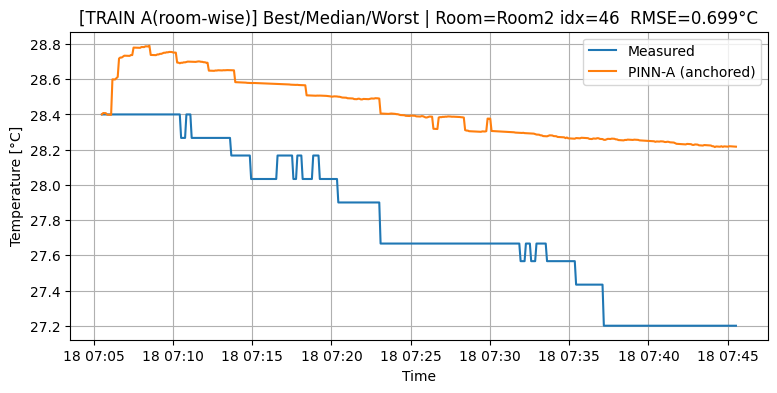

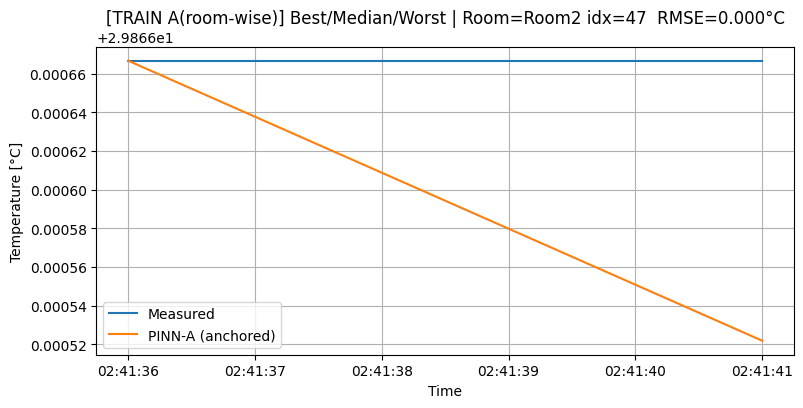

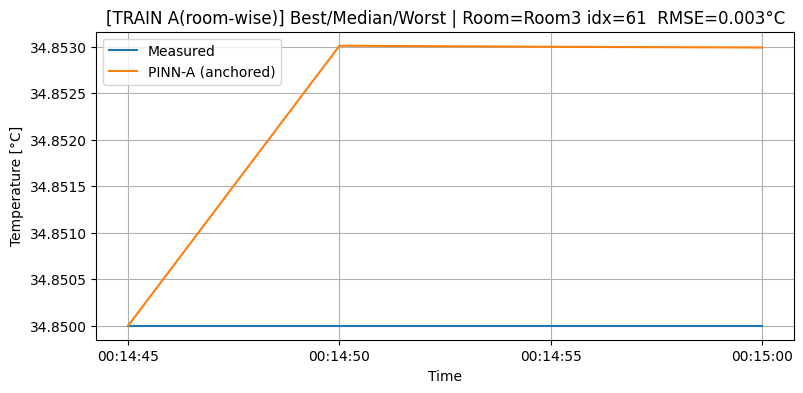

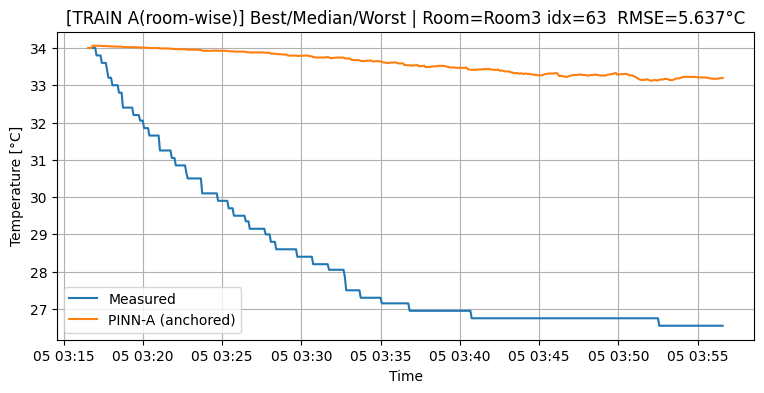

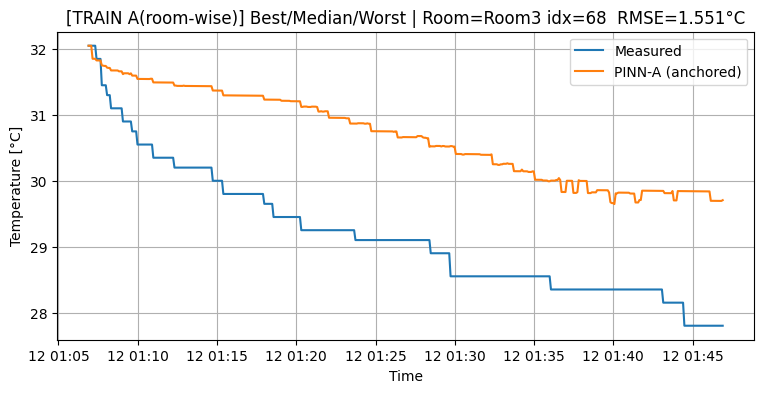

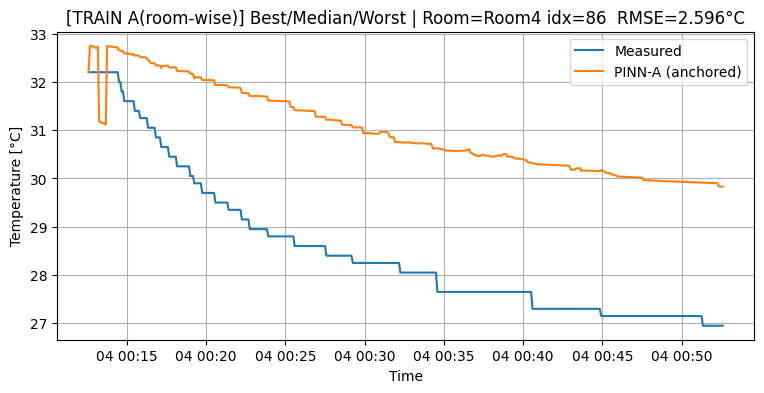

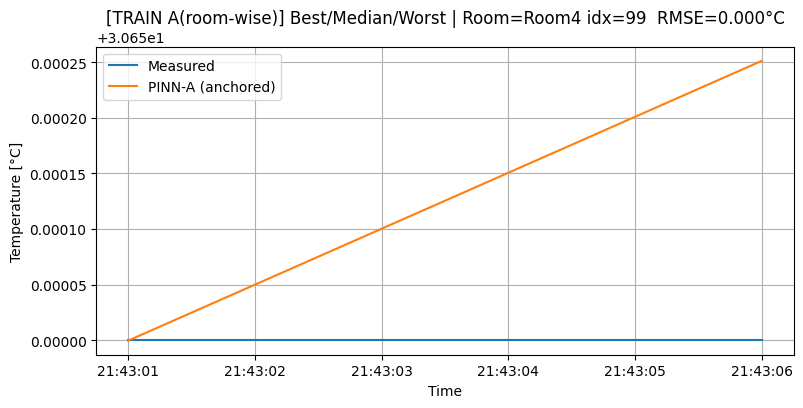

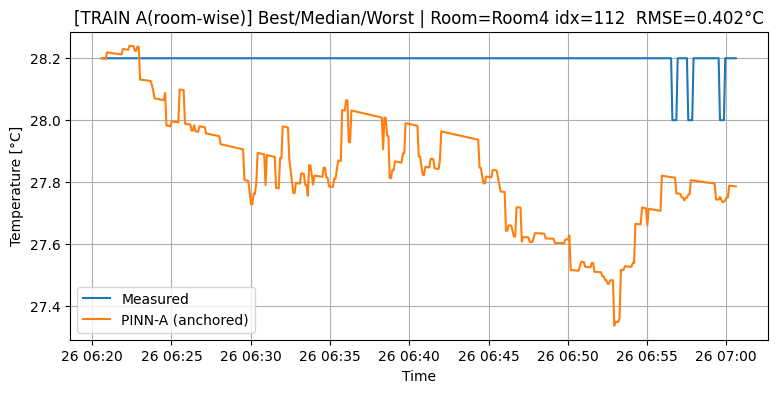

In [81]:
# ============================================================
# 방별 학습된 PINN(A안)으로 TRAIN 세트 40분 윈도우 예측 vs 실측 플롯
# 전제:
#   - train_rooms_LF  : 누수방지 전처리 결과 (datetime, room, Tid_room, Tod_room, S_mdot_sum, S_mdotTb_sum)
#   - room_artifacts  : 방별 학습 결과 dict (키: room명)
#       room_artifacts[r] = {"model": model_r, "x_mean": x_mean_r, "x_std": x_std_r, ...}
# ============================================================
import numpy as np, pandas as pd, torch
import matplotlib.pyplot as plt

# --- 체크 ---
assert 'train_rooms_LF' in globals(), "train_rooms_LF가 필요합니다."
assert 'room_artifacts' in globals() and len(room_artifacts), "room_artifacts(방별 모델)가 필요합니다."

# --- 유틸 ---
def to_epoch_sec(ts):
    dt = pd.to_datetime(ts, utc=True)
    if isinstance(dt, (pd.Series, pd.Index, np.ndarray)):
        return pd.to_datetime(dt).astype("int64") // 10**9
    else:
        return int(pd.to_datetime(dt).value // 10**9)

def group_contiguous_5s(dts):
    t = to_epoch_sec(dts).values
    dt = np.diff(t, prepend=t[0])
    return np.cumsum(dt != 5)

def make_windows_per_room(df_rooms: pd.DataFrame, roll_min=40):
    """방별 ON 세션에서 최대 roll_min분 윈도우 생성"""
    ROLL_SEC = roll_min * 60
    wins = []
    for room, g in df_rooms.groupby("room"):
        g = g.sort_values("datetime").copy()
        sid = group_contiguous_5s(g["datetime"])
        for _, seg in g.groupby(sid):
            if seg.empty: 
                continue
            t_abs = to_epoch_sec(seg["datetime"]).values.astype(float)
            t0, t_end = t_abs[0], t_abs[-1]
            t_stop = min(t0 + ROLL_SEC, t_end)
            seg = seg.loc[t_abs <= t_stop].copy()
            if len(seg) < 2:
                continue

            t_abs = to_epoch_sec(seg["datetime"]).values.astype(float)
            t_min = (t_abs - t_abs[0]) / 60.0
            Tid   = seg["Tid_room"].astype(float).values
            Tod   = seg["Tod_room"].astype(float).values
            Smdot = seg["S_mdot_sum"].astype(float).values
            SmdotTb = seg["S_mdotTb_sum"].astype(float).values

            ok = ~(np.isnan(t_min) | np.isnan(Tid) | np.isnan(Tod) | np.isnan(Smdot) | np.isnan(SmdotTb))
            if ok.sum() < 2:
                continue

            wins.append({
                "room": room,
                "start": pd.to_datetime(t0, unit="s"),
                "t_min": t_min[ok],
                "Tid": Tid[ok],
                "Tod": Tod[ok],
                "Smdot": Smdot[ok],
                "SmdotTb": SmdotTb[ok],
            })
    return wins

@torch.no_grad()
def predict_window_roomA(art, win, anchor=True):
    """
    방별 모델로 \hat T_phi(t,u) 질의.
    anchor=True → 첫 점 실측과 일치하도록 상수 오프셋만 적용(초기조건만 사용).
    """
    model = art["model"]
    x_mean = art["x_mean"].astype(np.float32)
    x_std  = art["x_std"].astype(np.float32)

    device = next(model.parameters()).device
    X = np.column_stack([win["t_min"], win["Tod"], win["Smdot"], win["SmdotTb"]]).astype(np.float32)
    Xz = (X - x_mean) / (x_std + 1e-8)

    model.eval()
    Xt = torch.from_numpy(Xz).to(device)
    That = model(Xt).detach().cpu().numpy().reshape(-1)

    Tpred = That.copy()
    if anchor:
        Tpred += float(win["Tid"][0] - That[0])

    rmse = float(np.sqrt(np.mean((Tpred - win["Tid"])**2)))
    return Tpred, rmse

def evaluate_train_per_room(room_artifacts, df_rooms, roll_min=40):
    wins = make_windows_per_room(df_rooms, roll_min=roll_min)
    rows, series = [], []
    missing_rooms = set()

    for i, w in enumerate(wins):
        r = w["room"]
        art = room_artifacts.get(r, None)
        if art is None:
            missing_rooms.add(r)
            continue
        Tp, rmse = predict_window_roomA(art, w, anchor=True)
        rows.append({
            "idx": i, "room": r, "start": w["start"],
            "minutes": (w["t_min"][-1] - w["t_min"][0]),
            "rmse_C": rmse
        })
        series.append({
            "idx": i, "room": r, "time_min": w["t_min"],
            "T_meas": w["Tid"], "T_pred": Tp, "start": w["start"]
        })

    summary = (pd.DataFrame(rows).sort_values(["room","start"]).reset_index(drop=True)
               if rows else pd.DataFrame(columns=["idx","room","start","minutes","rmse_C"]))
    if missing_rooms:
        print(f"[WARN] room_artifacts에 없는 방이 있어 스킵됨: {sorted(missing_rooms)}")
    print(f"[TRAIN] windows={len(wins)}, evaluated={len(rows)}")
    if len(summary):
        print(summary.groupby("room")["rmse_C"].describe())
    return summary, series

def sample_windows_per_room(summary_df: pd.DataFrame, k_per_room=3, seed=2025):
    rng = np.random.default_rng(seed)
    picked = []
    for room, g in summary_df.groupby("room"):
        idxs = g["idx"].tolist()
        rng.shuffle(idxs)
        picked += idxs[:min(k_per_room, len(idxs))]
    picked.sort()
    return picked

def plot_windows_train(series_list, summary_df, idx_list, title_prefix="[TRAIN A(room-wise)] Random"):
    by_idx = {s["idx"]: s for s in series_list}
    for idx in idx_list:
        s = by_idx.get(idx)
        if s is None: 
            print(f"[WARN] idx {idx} not found; skip"); 
            continue
        t = s["time_min"]
        ts = pd.to_datetime(s["start"]) + pd.to_timedelta(t, unit="m")
        Tm, Tp = s["T_meas"], s["T_pred"]
        rmse = float(summary_df.loc[summary_df["idx"]==idx, "rmse_C"].iloc[0])

        plt.figure(figsize=(9,4))
        plt.plot(ts, Tm, label="Measured")
        plt.plot(ts, Tp, label="PINN-A (anchored)")
        plt.title(f"{title_prefix} | Room={s['room']} idx={idx}  RMSE={rmse:.3f}°C")
        plt.xlabel("Time"); plt.ylabel("Temperature [°C]")
        plt.grid(True); plt.legend()
        plt.show()

# --- 실행: 평가/플롯 ---
summary_tr_roomA, series_tr_roomA = evaluate_train_per_room(room_artifacts, train_rooms_LF, roll_min=40)

# 방별로 랜덤 k개씩 플롯(예: k=3)
idxs = sample_windows_per_room(summary_tr_roomA, k_per_room=3, seed=39)
print("picked indices:", idxs)
plot_windows_train(series_tr_roomA, summary_tr_roomA, idxs, title_prefix="[TRAIN A(room-wise)] Random per-room")

# (옵션) 베스트/미디언/워스트도 보고 싶으면 방별로 뽑아보기
def pick_bmw_per_room(summary_df):
    picked = []
    for room, g in summary_df.groupby("room"):
        g = g.sort_values("rmse_C")
        best = g.iloc[0:1]["idx"].tolist()
        med  = g.iloc[[len(g)//2]]["idx"].tolist()
        worst= g.iloc[-1:]["idx"].tolist()
        picked += best + med + worst
    return sorted(set(picked))

bmw = pick_bmw_per_room(summary_tr_roomA)
print("best/median/worst per room:", bmw)
plot_windows_train(series_tr_roomA, summary_tr_roomA, bmw, title_prefix="[TRAIN A(room-wise)] Best/Median/Worst")


In [108]:
# ============================================================
# 목적: ANN 입력/라벨 생성 (인과·누수방지)
#  - 입력 X(t0): [T0, Tod0, Smdot0, Tbdy0]
#     * T0      = 방 평균 실내온도(5,9번 제외)
#     * Tod0    = 방 평균 외기온도
#     * Smdot0  = 방 내 ON 유닛들의 질량유량 합 (Σ mdot_i)
#     * Tbdy0   = 방 유량가중 토출온도 = (Σ mdot_i * Tbdy_i) / (Σ mdot_i)
#  - 타깃 y: T1 = 30초 뒤 방 실내온도
# 전제: 당신이 올린 상단 설정(ROOMS, RAW2STAGE, VDOT_* 등)과
#       load_one_csv_schema_fixed, load_all_csvs_schema_fixed, enrich_units 정의가 이미 있음.
# ============================================================
import numpy as np
import pandas as pd

TZ = "Asia/Seoul"
EPS = 1e-8

# ---------- 누수방지 방-집계 ----------
def gb_mean_safe(g: pd.core.groupby.SeriesGroupBy) -> pd.Series:
    return g.apply(lambda s: s.mean(skipna=True) if s.notna().any() else np.nan)

def gb_sum_safe(g: pd.core.groupby.SeriesGroupBy) -> pd.Series:
    return g.apply(lambda s: s.sum(skipna=True) if s.notna().any() else np.nan)

def make_rooms_leakfree_for_ann(df_units: pd.DataFrame) -> pd.DataFrame:
    """
    출력 컬럼:
      datetime, room, T0(=Tid_room), Tod0(=Tod_room),
      Smdot0(=Σ mdot_i over ON), Tbdy0(=Σ mdot_i*Tbdy_i / Σ mdot_i)
    조건:
      - any_on=True(방에 최소 1대 ON)만 남김
      - T0 평균에서 auto_id {5,9} 제외
    """
    d = df_units.copy()

    records = []
    for room, unit_ids in ROOMS.items():
        sub = d[d["auto_id"].isin(unit_ids)].copy()
        if sub.empty:
            continue

        # 방 평균 외기온도
        tod_room = gb_mean_safe(sub.groupby("datetime")["Tod"])

        # 방 평균 실내온도(5,9 제외)
        valid_ids = [uid for uid in unit_ids if uid not in EXCLUDE_TID_IDS]
        sub_tid = sub[sub["auto_id"].isin(valid_ids)]
        tid_room = gb_mean_safe(sub_tid.groupby("datetime")["Tid"])

        # ON 유닛만 사용해 Σ mdot, Σ mdot*Tbdy
        on_rows = sub[sub["is_on"]].copy()
        smdot_sum = gb_sum_safe(on_rows.groupby("datetime")["mdot_kg_s"])

        on_rows["mdotTb"] = on_rows["mdot_kg_s"] * on_rows["Tbdy"]
        smdotTb_sum = gb_sum_safe(on_rows.groupby("datetime")["mdotTb"])

        # any_on 판단
        any_on = sub.groupby("datetime")["is_on"].any()

        df_room = pd.DataFrame({
            "datetime": tid_room.index,
            "room": room,
            "T0": tid_room.values,                   # 방 실내온도(평균)
            "Tod0": tod_room.reindex(tid_room.index).values,
            "Smdot0": smdot_sum.reindex(tid_room.index).values,
            "SmdotTb0": smdotTb_sum.reindex(tid_room.index).values,
            "any_on": any_on.reindex(tid_room.index).values,
        })

        # 유량가중 토출온도
        df_room["Tbdy0"] = df_room["SmdotTb0"] / (df_room["Smdot0"] + EPS)

        # any_on=True, Smdot0>0, 필수 값 결측 제거
        df_room = df_room[(df_room["any_on"]==True) & (df_room["Smdot0"]>0)]
        df_room = df_room.drop(columns=["any_on","SmdotTb0"])
        df_room = df_room.dropna(subset=["datetime","T0","Tod0","Smdot0","Tbdy0"])

        records.append(df_room)

    if not records:
        return pd.DataFrame(columns=["datetime","room","T0","Tod0","Smdot0","Tbdy0"])

    rooms_df = (pd.concat(records, ignore_index=True)
                  .sort_values(["datetime","room"])
                  .reset_index(drop=True))

    # 타임존 보정(가능 시)
    try:
        if rooms_df["datetime"].dtype == "datetime64[ns]":
            rooms_df["datetime"] = rooms_df["datetime"].dt.tz_localize(TZ)
    except Exception:
        pass

    return rooms_df

# ---------- 5초 간격 세션 분할 & 30초 ahead 샘플 생성(인과) ----------
def to_epoch_sec(ts):
    dt = pd.to_datetime(ts, utc=True)
    if isinstance(dt, (pd.Series, pd.Index, np.ndarray)):
        return pd.to_datetime(dt).astype("int64") // 10**9
    return int(pd.to_datetime(dt).value // 10**9)

def group_contiguous_5s(dts):
    t = to_epoch_sec(dts).values
    dt = np.diff(t, prepend=t[0])
    return np.cumsum(dt != 5)

def build_windows_ann_causal(df_rooms: pd.DataFrame, delta_sec=30.0):
    """
    X = [T0, Tod0, Smdot0, Tbdy0] at time k
    y = T1 = T0 at time k+6 (정확히 +30s, 5s 샘플 가정)
    """
    rows = []
    for room, g in df_rooms.groupby("room"):
        g = g.sort_values("datetime").copy()
        sid = group_contiguous_5s(g["datetime"])
        for _, seg in g.groupby(sid):
            if len(seg) < 7:
                continue
            T   = seg["T0"].values.astype(float)
            Tod = seg["Tod0"].values.astype(float)
            Sm  = seg["Smdot0"].values.astype(float)
            Tb  = seg["Tbdy0"].values.astype(float)

            # i → i+6 (30초 ahead)
            for i in range(len(seg)-6):
                x = [T[i], Tod[i], Sm[i], Tb[i]]
                y = T[i+6]
                if np.any(np.isnan(x + [y])):
                    continue
                rows.append([room] + x + [y])

    cols = ["room","T0","Tod0","Smdot0","Tbdy0","T1"]
    return pd.DataFrame(rows, columns=cols) if rows else pd.DataFrame(columns=cols)

# ============================================================
# 실행 예시
# (이미 df_units_raw / enrich_units 등을 통해 df_units가 준비되어 있다고 가정)
# ============================================================

# 1) 유닛 레벨에서 mdot, is_on까지 계산돼 있어야 함
# df_units_raw = load_all_csvs_schema_fixed(INPUT_DIR)   # ← 당신 코드 그대로 사용
# df_units      = enrich_units(df_units_raw)              # stage, vdot, mdot_kg_s, is_on 생성

# 2) 방-집계 (누수방지)
df_rooms_LF = make_rooms_leakfree_for_ann(df_units)
print("df_rooms_LF:", df_rooms_LF.shape)
print(df_rooms_LF.head(10))

# 3) 30초 ahead 학습 샘플 생성 (인과)
windows_df = build_windows_ann_causal(df_rooms_LF, delta_sec=30.0)
print("windows_df (for ANN):", windows_df.shape)
print(windows_df.head(10))

# 이제 windows_df로 ANN을 학습하면 됩니다.
# 입력: windows_df[["T0","Tod0","Smdot0","Tbdy0"]]
# 라벨: windows_df[["T1"]]


df_rooms_LF: (323653, 6)
                   datetime   room         T0  Tod0    Smdot0      Tbdy0
0 2025-08-01 13:25:07+09:00  Room1  28.750000  36.3  0.425318  22.299999
1 2025-08-01 13:25:07+09:00  Room2  27.066667  36.3  0.425318  21.000000
2 2025-08-01 13:25:07+09:00  Room3  27.450000  36.3  0.224835  27.999999
3 2025-08-01 13:25:07+09:00  Room4  24.400000  36.3  0.650154  21.429965
4 2025-08-01 13:25:12+09:00  Room1  28.750000  36.3  0.425318  22.299999
5 2025-08-01 13:25:12+09:00  Room2  27.066667  36.3  0.425318  21.000000
6 2025-08-01 13:25:12+09:00  Room3  27.450000  36.3  0.224835  27.999999
7 2025-08-01 13:25:12+09:00  Room4  24.400000  36.3  0.650154  21.429965
8 2025-08-01 13:25:17+09:00  Room1  28.750000  36.3  0.425318  22.299999
9 2025-08-01 13:25:17+09:00  Room2  27.066667  36.3  0.425318  21.000000
windows_df (for ANN): (322997, 6)
    room     T0  Tod0    Smdot0      Tbdy0     T1
0  Room1  28.75  36.3  0.425318  22.299999  28.75
1  Room1  28.75  36.3  0.425318  22.29

In [118]:
# === 스키마 호환 셔틀: rooms_df → (datetime, room, T0, Tod0, Smdot0, SmdotTb0)로 통일 ===
import numpy as np
import pandas as pd

def coerce_rooms_for_ann(rooms_df: pd.DataFrame) -> pd.DataFrame:
    d = rooms_df.copy()
    need_new = {"datetime","room","T0","Tod0","Smdot0"}
    need_old = {"datetime","room","Tid_room","Tod_room","S_mdot_sum"}

    if need_new.issubset(d.columns):
        # 신(新) 스키마: T0, Tod0, Smdot0, (Tbdy0 또는 SmdotTb0)
        if "SmdotTb0" not in d.columns:
            if "Tbdy0" in d.columns:
                d["SmdotTb0"] = d["Smdot0"] * d["Tbdy0"]      # Σ(mdot_i * Tbdy_i)
            elif "S_mdotTb_sum" in d.columns:
                d["SmdotTb0"] = d["S_mdotTb_sum"]
            else:
                raise AssertionError("rooms_df에 SmdotTb0/Tbdy0/S_mdotTb_sum 중 하나가 필요합니다.")
        use = ["datetime","room","T0","Tod0","Smdot0","SmdotTb0"]
        return d[use].reset_index(drop=True)

    elif need_old.issubset(d.columns):
        # 구(旧) 스키마: Tid_room, Tod_room, S_mdot_sum, (S_mdotTb_sum)
        if "S_mdotTb_sum" not in d.columns:
            raise AssertionError("구 스키마 rooms_df에는 S_mdotTb_sum 컬럼이 필요합니다.")
        d2 = pd.DataFrame({
            "datetime":   d["datetime"].values,
            "room":       d["room"].values,
            "T0":         d["Tid_room"].values,
            "Tod0":       d["Tod_room"].values,
            "Smdot0":     d["S_mdot_sum"].values,
            "SmdotTb0":   d["S_mdotTb_sum"].values,
        })
        return d2.reset_index(drop=True)

    else:
        raise AssertionError("rooms_df 컬럼 구성이 예상과 다릅니다. (신: T0/Tod0/Smdot0/… 또는 구: Tid_room/Tod_room/S_mdot_sum/…)")

# === 5초 연속 세션 분할 ===
def to_epoch_sec(ts):
    dt = pd.to_datetime(ts, utc=True)
    if isinstance(dt, (pd.Series, pd.Index, np.ndarray)):
        return pd.to_datetime(dt).astype("int64") // 10**9
    return int(pd.to_datetime(dt).value // 10**9)

def group_contiguous_5s(dts):
    t = to_epoch_sec(dts).values
    dt = np.diff(t, prepend=t[0])
    return np.cumsum(dt != 5)

# === 현재값만으로 30초 ahead 샘플 생성 (인과, 누수방지) ===
def build_windows_causal_from_room_df_UNIFIED(df_room: pd.DataFrame):
    d = df_room.sort_values("datetime").copy()
    tsec = to_epoch_sec(d["datetime"]).values.astype(float)
    seq_id = np.cumsum(np.diff(tsec, prepend=tsec[0]) != 5)

    rows = []
    for _, g in d.groupby(seq_id):
        if len(g) < 7:   # 30초 앞(6스텝) → 최소 7포인트
            continue
        T     = g["T0"].values.astype(float)
        Tod   = g["Tod0"].values.astype(float)
        Smdot = g["Smdot0"].values.astype(float)
        SmdTb = g["SmdotTb0"].values.astype(float)

        for i in range(len(g)-6):
            T0, T1 = T[i], T[i+6]
            x = [T0, Tod[i], Smdot[i], SmdTb[i]]
            if np.any(np.isnan(x + [T1])): 
                continue
            rows.append(x + [T1])

    cols = ["T0","Tod0","Smdot0","SmdotTb0","T1"]
    return pd.DataFrame(rows, columns=cols) if rows else pd.DataFrame(columns=cols)

def build_all_windows_causal_UNIFIED(rooms_df_unified: pd.DataFrame):
    parts = []
    for room, g in rooms_df_unified.groupby("room"):
        parts.append(build_windows_causal_from_room_df_UNIFIED(g))
    return (pd.concat(parts, ignore_index=True)
            if parts else build_windows_causal_from_room_df_UNIFIED(rooms_df_unified.iloc[0:0]))

# === 사용: rooms_df 스키마를 통일 → 윈도우 생성 ===
# rooms_df 후보: df_rooms_LF (신 스키마) 또는 df_rooms (구 스키마)
rooms_df_unified = coerce_rooms_for_ann(rooms_df)
windows_df = build_all_windows_causal_UNIFIED(rooms_df_unified)
print("windows_df (causal, unified):", windows_df.shape)
print(windows_df.head())


windows_df (causal, unified): (322997, 5)
      T0  Tod0    Smdot0  SmdotTb0     T1
0  28.75  36.3  0.425318    9.4846  28.75
1  28.75  36.3  0.425318    9.4846  28.75
2  28.75  36.3  0.425318    9.4846  28.75
3  28.75  36.3  0.425318    9.4846  28.75
4  28.75  36.3  0.425318    9.4846  28.75


In [120]:
# ============================================================
# 인과·누수방지 ANN: 현재값만으로 30초 뒤 실내온도 예측
#  - 입력 X(t0): [T0, Tod0, Smdot0, SmdotTb0]
#  - 타깃 y:     T1 = T(t0+30s)
#  - 여러 대 ON이면 Σ(mdoti), Σ(mdoti * Tbdyi)로 합산 (누수 없음)
#  - df_rooms_LF(신) 또는 df_rooms(구) → 스키마 통일 → 윈도우 생성 → 학습
# ============================================================
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split

# -----------------------------
# 0) 스키마 통일 유틸
# -----------------------------
def coerce_rooms_for_ann(rooms_df: pd.DataFrame) -> pd.DataFrame:
    """
    입력: rooms_df (신 스키마 or 구 스키마)
    출력: (datetime, room, T0, Tod0, Smdot0, SmdotTb0) 컬럼만 가진 DF
    - 신(新): T0, Tod0, Smdot0, (Tbdy0 or SmdotTb0)
    - 구(旧): Tid_room, Tod_room, S_mdot_sum, S_mdotTb_sum
    """
    d = rooms_df.copy()
    need_new = {"datetime","room","T0","Tod0","Smdot0"}
    need_old = {"datetime","room","Tid_room","Tod_room","S_mdot_sum"}

    if need_new.issubset(d.columns):
        if "SmdotTb0" not in d.columns:
            if "Tbdy0" in d.columns:
                d["SmdotTb0"] = d["Smdot0"] * d["Tbdy0"]  # Σ(mdoti * Tbdyi)
            elif "S_mdotTb_sum" in d.columns:
                d["SmdotTb0"] = d["S_mdotTb_sum"]
            else:
                raise AssertionError("rooms_df에 SmdotTb0/Tbdy0/S_mdotTb_sum 중 하나가 필요합니다.")
        use = ["datetime","room","T0","Tod0","Smdot0","SmdotTb0"]
        return d[use].dropna(subset=["datetime"]).reset_index(drop=True)

    elif need_old.issubset(d.columns):
        if "S_mdotTb_sum" not in d.columns:
            raise AssertionError("구 스키마 rooms_df에는 S_mdotTb_sum 컬럼이 필요합니다.")
        d2 = pd.DataFrame({
            "datetime":   d["datetime"].values,
            "room":       d["room"].values,
            "T0":         d["Tid_room"].values,
            "Tod0":       d["Tod_room"].values,
            "Smdot0":     d["S_mdot_sum"].values,
            "SmdotTb0":   d["S_mdotTb_sum"].values,
        })
        return d2.dropna(subset=["datetime"]).reset_index(drop=True)

    else:
        raise AssertionError("rooms_df 컬럼 구성이 예상과 다릅니다. (신: T0/Tod0/Smdot0/… 또는 구: Tid_room/Tod_room/S_mdot_sum/…)")

# -----------------------------
# 1) 5초 연속 세션 분할 & 30초 ahead 샘플
# -----------------------------
DELTA = 30.0  # seconds

def to_epoch_sec(ts):
    dt = pd.to_datetime(ts, utc=True)
    if isinstance(dt, (pd.Series, pd.Index, np.ndarray)):
        return pd.to_datetime(dt).astype("int64") // 10**9
    return int(pd.to_datetime(dt).value // 10**9)

def group_contiguous_5s(dts):
    t = to_epoch_sec(dts).values
    dt = np.diff(t, prepend=t[0])
    return np.cumsum(dt != 5)

def build_windows_causal_from_room_df_UNIFIED(df_room: pd.DataFrame):
    """
    입력: (datetime, room, T0, Tod0, Smdot0, SmdotTb0)
    출력: 윈도우 행들 [T0, Tod0, Smdot0, SmdotTb0, T1], 여기서 T1=T0(+30s)
    """
    d = df_room.sort_values("datetime").copy()
    tsec = to_epoch_sec(d["datetime"]).values.astype(float)
    seq_id = np.cumsum(np.diff(tsec, prepend=tsec[0]) != 5)

    rows = []
    for _, g in d.groupby(seq_id):
        if len(g) < 7:   # 30초 ahead (6스텝) 만들려면 최소 7포인트 필요
            continue
        T     = g["T0"].values.astype(float)
        Tod   = g["Tod0"].values.astype(float)
        Smdot = g["Smdot0"].values.astype(float)
        SmdTb = g["SmdotTb0"].values.astype(float)

        # i → i+6 (정확히 +30s)
        for i in range(len(g)-6):
            T0, T1 = T[i], T[i+6]
            x = [T0, Tod[i], Smdot[i], SmdTb[i]]
            if np.any(np.isnan(x + [T1])): 
                continue
            rows.append(x + [T1])

    cols = ["T0","Tod0","Smdot0","SmdotTb0","T1"]
    return pd.DataFrame(rows, columns=cols) if rows else pd.DataFrame(columns=cols)

def build_all_windows_causal_UNIFIED(rooms_df_unified: pd.DataFrame):
    parts = []
    for room, g in rooms_df_unified.groupby("room"):
        parts.append(build_windows_causal_from_room_df_UNIFIED(g))
    return (pd.concat(parts, ignore_index=True)
            if parts else build_windows_causal_from_room_df_UNIFIED(rooms_df_unified.iloc[0:0]))

# -----------------------------
# 2) rooms_df 선택 → 스키마 통일 → 윈도우 생성
# -----------------------------
if 'df_rooms_LF' in globals():
    rooms_df_src = df_rooms_LF
elif 'df_rooms' in globals():
    rooms_df_src = df_rooms
else:
    raise AssertionError("df_rooms_LF 또는 df_rooms가 메모리에 필요합니다. 전처리부터 실행하세요.")

rooms_df_unified = coerce_rooms_for_ann(rooms_df_src)
print("unified cols:", rooms_df_unified.columns.tolist())

windows_df = build_all_windows_causal_UNIFIED(rooms_df_unified)
print("windows_df:", windows_df.shape)
print(windows_df.head())

assert not windows_df.empty, "윈도우가 비었습니다. any_on/샘플 간격/결측을 확인하세요."

# -----------------------------
# 3) 학습/검증 분할 및 표준화
# -----------------------------
X = windows_df[["T0","Tod0","Smdot0","SmdotTb0"]].values.astype(np.float32)
y = windows_df[["T1"]].values.astype(np.float32)

X_tr, X_val, y_tr, y_val = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)

x_mean, x_std = X_tr.mean(axis=0), X_tr.std(axis=0) + 1e-8
X_trn = (X_tr - x_mean)/x_std
X_vln = (X_val - x_mean)/x_std

class ArrayDS(torch.utils.data.Dataset):
    def __init__(self, X, y):
        self.X = torch.from_numpy(X.astype(np.float32))
        self.y = torch.from_numpy(y.astype(np.float32))
    def __len__(self): return len(self.X)
    def __getitem__(self, i): return self.X[i], self.y[i]

train_loader = torch.utils.data.DataLoader(ArrayDS(X_trn, y_tr), batch_size=512, shuffle=True)
val_loader   = torch.utils.data.DataLoader(ArrayDS(X_vln, y_val), batch_size=1024, shuffle=False)

# -----------------------------
# 4) 모델 정의/학습
# -----------------------------
class ANN_CausalLF(nn.Module):
    def __init__(self, in_dim=4, hid=64, out_dim=1, p_drop=0.1):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, hid), nn.ReLU(),
            nn.Dropout(p_drop),
            nn.Linear(hid, hid), nn.ReLU(),
            nn.Dropout(p_drop),
            nn.Linear(hid, out_dim),
        )
    def forward(self, x): return self.net(x)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
ann = ANN_CausalLF(in_dim=4, hid=64, out_dim=1, p_drop=0.1).to(device)

opt = torch.optim.AdamW(ann.parameters(), lr=2e-3, weight_decay=1e-4)
sch = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, mode='min', factor=0.5, patience=5)
mse = nn.MSELoss()

best_val, best_state = np.inf, None
EPOCHS = 60
prev_lr = opt.param_groups[0]['lr']

for ep in range(1, EPOCHS+1):
    ann.train()
    tr_losses = []
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        opt.zero_grad()
        pred = ann(xb)
        loss = mse(pred, yb)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(ann.parameters(), 5.0)
        opt.step()
        tr_losses.append(loss.item())

    ann.eval()
    with torch.no_grad():
        Xv = torch.from_numpy(X_vln).to(device)
        yv = torch.from_numpy(y_val).to(device)
        pv = ann(Xv)
        val_loss = mse(pv, yv).item()

    sch.step(val_loss)
    if val_loss < best_val - 1e-6:
        best_val = val_loss
        best_state = {k: v.detach().cpu().clone() for k, v in ann.state_dict().items()}

    if ep % 5 == 0 or ep == 1:
        tr_loss = float(np.mean(tr_losses))
        cur_lr  = opt.param_groups[0]['lr']
        lr_tag  = f" | lr→{cur_lr:.1e}" if cur_lr != prev_lr else ""
        prev_lr = cur_lr
        print(f"[{ep:03d}] train MSE={tr_loss:.4f} | val MSE={val_loss:.4f}{lr_tag}")

# best 가중치 로드
if best_state is not None:
    ann.load_state_dict(best_state)

# -----------------------------
# 5) 최종 RMSE 및 헬퍼
# -----------------------------
ann.eval()
with torch.no_grad():
    ptr = ann(torch.from_numpy(X_trn).to(device)).cpu().numpy()
    pvl = ann(torch.from_numpy(X_vln).to(device)).cpu().numpy()
rmse_tr  = float(np.sqrt(np.mean((ptr - y_tr)**2)))
rmse_val = float(np.sqrt(np.mean((pvl - y_val)**2)))
print(f"=> ANN(causal) RMSE | train={rmse_tr:.3f} °C, val={rmse_val:.3f} °C")

def ann_predict_30s_causal(T0, Tod0, Sm0, SmTb0):
    """현재값만으로 30초 뒤 실내온도 예측 (교사강제 1-step)"""
    x = np.array([[T0, Tod0, Sm0, SmTb0]], dtype=np.float32)
    x = (x - x_mean)/x_std
    with torch.no_grad():
        pred = ann(torch.from_numpy(x).to(device)).cpu().numpy().squeeze()
    return float(pred)

def quick_1step_rmse_causal(df_windows, n=50):
    """윈도우 샘플 n개 랜덤 추출해 1-step RMSE 빠르게 확인"""
    n = min(n, len(df_windows))
    idx = np.random.choice(len(df_windows), size=n, replace=False)
    errs = []
    for i in idx:
        r = df_windows.iloc[i]
        yhat = ann_predict_30s_causal(r["T0"], r["Tod0"], r["Smdot0"], r["SmdotTb0"])
        errs.append((yhat - r["T1"])**2)
    return float(np.sqrt(np.mean(errs))) if errs else np.nan

print("quick 1-step RMSE (causal sample):", f"{quick_1step_rmse_causal(windows_df, n=50):.3f}", "°C")


unified cols: ['datetime', 'room', 'T0', 'Tod0', 'Smdot0', 'SmdotTb0']
windows_df: (322997, 5)
      T0  Tod0    Smdot0  SmdotTb0     T1
0  28.75  36.3  0.425318    9.4846  28.75
1  28.75  36.3  0.425318    9.4846  28.75
2  28.75  36.3  0.425318    9.4846  28.75
3  28.75  36.3  0.425318    9.4846  28.75
4  28.75  36.3  0.425318    9.4846  28.75
[001] train MSE=68.9901 | val MSE=0.2354
[005] train MSE=2.1057 | val MSE=0.0159
[010] train MSE=1.6164 | val MSE=0.0135
[015] train MSE=1.1983 | val MSE=0.0226
[020] train MSE=0.9691 | val MSE=0.0214 | lr→1.0e-03
[025] train MSE=0.8365 | val MSE=0.0126 | lr→5.0e-04
[030] train MSE=0.7497 | val MSE=0.0128
[035] train MSE=0.6906 | val MSE=0.0144 | lr→2.5e-04
[040] train MSE=0.6558 | val MSE=0.0152 | lr→1.3e-04
[045] train MSE=0.6362 | val MSE=0.0157 | lr→6.3e-05
[050] train MSE=0.6269 | val MSE=0.0163 | lr→3.1e-05
[055] train MSE=0.6182 | val MSE=0.0162 | lr→1.6e-05
[060] train MSE=0.6214 | val MSE=0.0177
=> ANN(causal) RMSE | train=0.113 °C, val

valid_rooms_unified: (136807, 6)
VALID windows: (53, 5)
       count      mean       std       min       25%       50%       75%  \
room                                                                       
Room1   10.0  1.618648  0.176488  1.400654  1.440229  1.669974  1.726716   
Room2   17.0  1.700883  0.342067  1.350277  1.572782  1.629927  1.690593   
Room3   11.0  1.588779  0.115628  1.357941  1.550023  1.569140  1.693628   
Room4   15.0  1.588212  0.126491  1.294966  1.535339  1.588509  1.669432   

            max  
room             
Room1  1.887203  
Room2  2.924811  
Room3  1.737656  
Room4  1.792827  


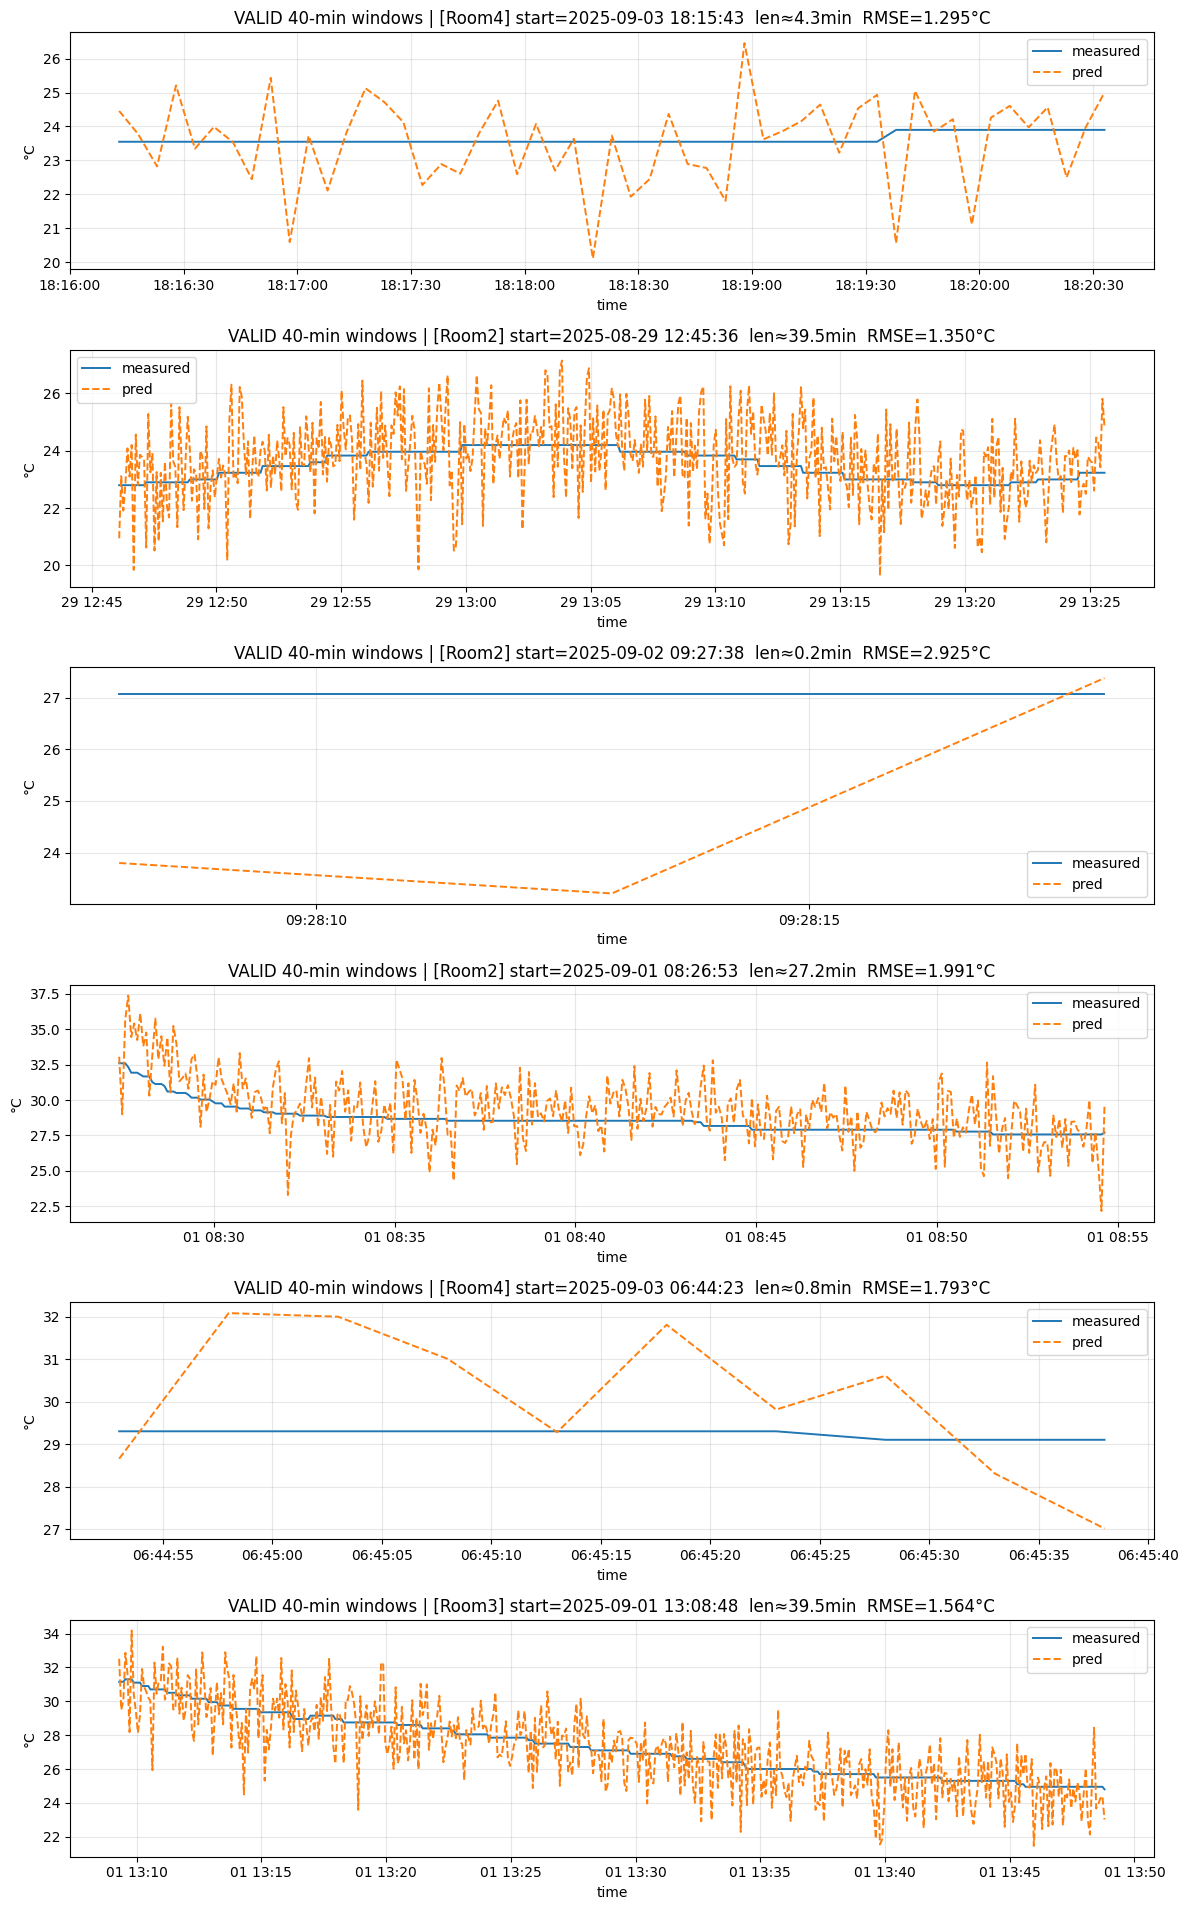

In [123]:
# ============================================================
# VALID 세트 평가: 1-step(30s ahead) 예측 vs 실측 (누수 방지, 인과)
#  - /home/deok/Desktop/LOG_SMART_202508_valid 의 CSV 사용
#  - 전처리(유닛→방) → 스키마 통일 → 40분 윈도우 → 예측/플롯
#  - 필요: 학습 완료된 ann, x_mean, x_std
# ============================================================
import os, re, glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch

# ---------- 설정 ----------
VALID_DIR = "/home/deok/Desktop/LOG_SMART_202508_valid"
TZ = "Asia/Seoul"
DELTA = 30.0         # 30초 앞
ROLL_MIN = 40        # 40분 평가 윈도우
AIR_DENSITY = 1.2    # kg/m^3
EXCLUDE_TID_IDS = {5, 9}

ROOMS = {
    "Room1": [8, 3, 5],
    "Room2": [4, 1, 6],
    "Room3": [2, 7],
    "Room4": [9, 10, 11],
}
RAW2STAGE = {5:1, 1:2, 2:3, 3:4}
VDOT_DEFAULT = {4:30.89363, 3:27.97700, 2:23.72948, 1:21.26592}  # m^3/min
VDOT_AUTO2   = {4:18.97226, 3:16.31048, 2:13.25226, 1:11.24177}
VDOT_AUTO10  = {4:18.49087, 3:15.74414, 2:13.25226, 1:11.24177}

# 학습된 모델/스케일러 확인
assert 'ann' in globals(), "학습된 ann 모델이 필요합니다."
assert 'x_mean' in globals() and 'x_std' in globals(), "x_mean/x_std가 필요합니다."
device = next(ann.parameters()).device

# ---------- CSV 로드(파일명 날짜 + Time 합성) ----------
DATE_IN_FILENAME_REGEX = re.compile(r"(20\d{6})")  # ex) 20250821
RENAME_MAP = {
    "Auto Id": "auto_id",
    "Time": "time",
    "Frun": "Frun",
    "Tcon": "Tcon",
    "Tbdy": "Tbdy",
    "Tid": "Tid",
    "Tod": "Tod",
    "Hid": "Hid",
    "Tpip_in": "Tpip_in",
    "Tpip_out": "Tpip_outeh",
    "Tpip_outeh": "Tpip_outeh",
}

def extract_date_from_filename(path: str):
    m = DATE_IN_FILENAME_REGEX.search(os.path.basename(path))
    return pd.to_datetime(m.group(1), format="%Y%m%d") if m else None

def build_datetime_from_filename_and_time(df: pd.DataFrame, src_path: str, tz: str) -> pd.Series:
    file_date = extract_date_from_filename(src_path)
    if file_date is None:
        raise ValueError(f"Filename has no date: {os.path.basename(src_path)}")
    tstr = df["time"].astype(str).str.strip()
    full = file_date.strftime("%Y-%m-%d") + " " + tstr
    dt = pd.to_datetime(full, errors="coerce")
    return dt.dt.tz_localize(tz)

def load_one_csv_schema_fixed(path: str, tz="Asia/Seoul") -> pd.DataFrame:
    df0 = pd.read_csv(path, engine="python", on_bad_lines="skip", dtype=str)
    df0.columns = [c.strip() for c in df0.columns]
    colmap = {c: RENAME_MAP[c] for c in df0.columns if c in RENAME_MAP}
    df = df0.rename(columns=colmap)

    required = ["auto_id","time","Frun","Tcon","Tbdy","Tid","Tod"]
    miss = [c for c in required if c not in df.columns]
    if miss: raise ValueError(f"Missing columns {miss} in {os.path.basename(path)}")

    df["datetime"] = build_datetime_from_filename_and_time(df, path, tz)

    df["auto_id"] = pd.to_numeric(df["auto_id"], errors="coerce").astype("Int64")
    for c in ["Frun","Tcon","Tbdy","Tid","Tod","Hid","Tpip_in","Tpip_outeh"]:
        if c in df.columns: df[c] = pd.to_numeric(df[c], errors="coerce")

    keep = ["datetime","auto_id","Frun","Tcon","Tbdy","Tid","Tod","Hid","Tpip_in","Tpip_outeh"]
    present = [c for c in keep if c in df.columns]
    return df[present].sort_values(["datetime","auto_id"]).reset_index(drop=True)

def load_all_csvs_schema_fixed(root_dir: str, tz="Asia/Seoul") -> pd.DataFrame:
    files = sorted(glob.glob(os.path.join(root_dir, "*.csv")))
    if not files: raise FileNotFoundError(f"No CSV under {root_dir}")
    dfs = []
    for p in files:
        try:
            dfs.append(load_one_csv_schema_fixed(p, tz=tz))
        except Exception as e:
            print(f"[WARN] Skip {os.path.basename(p)}: {e}")
    if not dfs: raise ValueError("No valid CSVs were loaded.")
    return (pd.concat(dfs, ignore_index=True)
              .dropna(subset=["datetime"])
              .sort_values(["datetime","auto_id"])
              .reset_index(drop=True))

# ---------- 유닛 레벨 전처리 ----------
def compute_stage(frun_series: pd.Series) -> pd.Series:
    st = frun_series.map(RAW2STAGE).astype("float")
    st[(frun_series==0) | (frun_series.isna())] = np.nan
    return st

def vdot_from_row(row) -> float:
    st = row.get("stage", np.nan)
    if pd.isna(st) or st == 0: return 0.0
    aid = row.get("auto_id", np.nan)
    if pd.isna(aid): return 0.0
    st = int(st); aid = int(aid)
    if aid == 2: table = VDOT_AUTO2
    elif aid == 10: table = VDOT_AUTO10
    else: table = VDOT_DEFAULT
    return float(table.get(st, 0.0))

def enrich_units(df: pd.DataFrame) -> pd.DataFrame:
    d = df.copy()
    d["stage"] = compute_stage(d["Frun"])
    d["vdot_m3_min"] = d.apply(vdot_from_row, axis=1)              # ✅ 행 단위 처리
    d["mdot_kg_s"]   = AIR_DENSITY * (d["vdot_m3_min"] / 60.0)
    tcon_nz = d["Tcon"].fillna(0.0)
    frun_nz = d["Frun"].fillna(0.0)
    d["is_on"] = (tcon_nz != 0) & (frun_nz != 0)
    return d

# ---------- 방 집계(누수 방지) ----------
def gb_mean_safe(g: pd.core.groupby.SeriesGroupBy) -> pd.Series:
    return g.apply(lambda s: s.mean(skipna=True) if s.notna().any() else np.nan)
def gb_sum_safe(g: pd.core.groupby.SeriesGroupBy) -> pd.Series:
    return g.apply(lambda s: s.sum(skipna=True) if s.notna().any() else np.nan)

def make_rooms_leakfree_for_ann(df_units: pd.DataFrame) -> pd.DataFrame:
    """
    출력: datetime, room, T0(방 평균 Tid; 5,9 제외), Tod0(방 평균), 
          Smdot0(Σ ON mdot), Tbdy0(유량가중 토출온도)
    any_on=True만 유지
    """
    d = df_units.copy()
    records = []
    for room, unit_ids in ROOMS.items():
        sub = d[d["auto_id"].isin(unit_ids)].copy()
        if sub.empty: continue

        tod_room = gb_mean_safe(sub.groupby("datetime")["Tod"])

        valid_ids = [uid for uid in unit_ids if uid not in EXCLUDE_TID_IDS]
        sub_tid = sub[sub["auto_id"].isin(valid_ids)]
        tid_room = gb_mean_safe(sub_tid.groupby("datetime")["Tid"])

        on_rows = sub[sub["is_on"]].copy()
        smdot_sum = gb_sum_safe(on_rows.groupby("datetime")["mdot_kg_s"])
        on_rows["mdotTb"] = on_rows["mdot_kg_s"] * on_rows["Tbdy"]
        smdotTb_sum = gb_sum_safe(on_rows.groupby("datetime")["mdotTb"])

        any_on = sub.groupby("datetime")["is_on"].any()

        df_room = pd.DataFrame({
            "datetime": tid_room.index,
            "room": room,
            "T0": tid_room.values,
            "Tod0": tod_room.reindex(tid_room.index).values,
            "Smdot0": smdot_sum.reindex(tid_room.index).values,
            "SmdotTb0": smdotTb_sum.reindex(tid_room.index).values,  # 합 자체 보관
            "any_on": any_on.reindex(tid_room.index).values,
        })
        df_room = df_room[(df_room["any_on"]==True) & (df_room["Smdot0"]>0)]
        df_room = df_room.drop(columns=["any_on"]).dropna(subset=["datetime","T0","Tod0","Smdot0","SmdotTb0"])
        records.append(df_room)

    if not records:
        return pd.DataFrame(columns=["datetime","room","T0","Tod0","Smdot0","SmdotTb0"])

    rooms_df = (pd.concat(records, ignore_index=True)
                  .sort_values(["datetime","room"])
                  .reset_index(drop=True))
    return rooms_df

# ---------- 스키마 통일 (호환 셔틀) ----------
def coerce_rooms_for_ann(rooms_df: pd.DataFrame) -> pd.DataFrame:
    d = rooms_df.copy()
    need_new = {"datetime","room","T0","Tod0","Smdot0"}
    need_old = {"datetime","room","Tid_room","Tod_room","S_mdot_sum"}

    if need_new.issubset(d.columns):
        if "SmdotTb0" not in d.columns:
            if "Tbdy0" in d.columns:
                d["SmdotTb0"] = d["Smdot0"] * d["Tbdy0"]
            elif "S_mdotTb_sum" in d.columns:
                d["SmdotTb0"] = d["S_mdotTb_sum"]
            else:
                # 새 집계는 이미 SmdotTb0를 만들어서 넣어둠
                if "SmdotTb0" not in d.columns:
                    raise AssertionError("rooms_df에 SmdotTb0/Tbdy0/S_mdotTb_sum 중 하나가 필요합니다.")
        use = ["datetime","room","T0","Tod0","Smdot0","SmdotTb0"]
        return d[use].dropna(subset=["datetime"]).reset_index(drop=True)

    elif need_old.issubset(d.columns):
        if "S_mdotTb_sum" not in d.columns:
            raise AssertionError("구 스키마 rooms_df에는 S_mdotTb_sum 컬럼이 필요합니다.")
        d2 = pd.DataFrame({
            "datetime":   d["datetime"].values,
            "room":       d["room"].values,
            "T0":         d["Tid_room"].values,
            "Tod0":       d["Tod_room"].values,
            "Smdot0":     d["S_mdot_sum"].values,
            "SmdotTb0":   d["S_mdotTb_sum"].values,
        })
        return d2.dropna(subset=["datetime"]).reset_index(drop=True)
    else:
        raise AssertionError("rooms_df 컬럼 구성 불일치")

# ---------- 시간 유틸 ----------
def to_epoch_sec(ts):
    dt = pd.to_datetime(ts, utc=True)
    if isinstance(dt, (pd.Series, pd.Index, np.ndarray)):
        return pd.to_datetime(dt).astype("int64") // 10**9
    return int(pd.to_datetime(dt).value // 10**9)

def group_contiguous_5s(dts):
    t = to_epoch_sec(dts).values
    dt = np.diff(t, prepend=t[0])
    return np.cumsum(dt != 5)

# ---------- ANN 30s ahead(1-step) 예측 ----------
@torch.no_grad()
def ann_predict_30s_causal(T0, Tod0, Sm0, SmTb0):
    x = np.array([[T0, Tod0, Sm0, SmTb0]], dtype=np.float32)
    x = (x - x_mean)/x_std
    yhat = ann(torch.from_numpy(x).to(device)).cpu().numpy().squeeze()
    return float(yhat)

# ---------- VALID 로드 → 방 집계 → 스키마 통일 ----------
valid_units_raw = load_all_csvs_schema_fixed(VALID_DIR, tz=TZ)
valid_units     = enrich_units(valid_units_raw)                 # ✅ 여기서 에러 없도록 fix
valid_rooms_LF  = make_rooms_leakfree_for_ann(valid_units)      # [datetime, room, T0, Tod0, Smdot0, SmdotTb0]
valid_rooms_unified = coerce_rooms_for_ann(valid_rooms_LF)
print("valid_rooms_unified:", valid_rooms_unified.shape)

# ---------- 40분 윈도우 평가 ----------
def make_valid_rollout_windows(df_rooms_unified, roll_min=40):
    rows, series = [], []
    for room, g in df_rooms_unified.groupby("room"):
        g = g.sort_values("datetime").copy()
        sid = group_contiguous_5s(g["datetime"])

        for _, seg in g.groupby(sid):
            if len(seg) < 7:   # 30초 ahead 용도 최소 길이
                continue
            tg = to_epoch_sec(seg["datetime"]).values.astype(float)
            t0, t_end = tg[0], tg[-1]
            t_stop = min(t0 + roll_min*60, t_end)

            # 예측 가능 마지막 인덱스 i: tg[i+6] <= t_stop
            last_pred_idx = np.searchsorted(tg, t_stop, side='right') - 1
            max_i = min(len(seg) - 7, last_pred_idx - 6)
            if max_i < 0: 
                continue

            T   = seg["T0"].values.astype(float)
            Tod = seg["Tod0"].values.astype(float)
            Sm  = seg["Smdot0"].values.astype(float)
            SmT = seg["SmdotTb0"].values.astype(float)

            t_pred, y_meas, y_hat = [], [], []

            for i in range(max_i + 1):
                yhat = ann_predict_30s_causal(T[i], Tod[i], Sm[i], SmT[i])
                y    = T[i+6]   # 30초 뒤 실내온도
                tt   = tg[i+6]
                if np.any(np.isnan([yhat, y])): 
                    continue
                t_pred.append(tt)
                y_meas.append(y)
                y_hat.append(yhat)

            if len(y_meas) == 0: 
                continue

            y_meas = np.asarray(y_meas); y_hat = np.asarray(y_hat)
            rmse = float(np.sqrt(np.mean((y_hat - y_meas)**2)))

            rows.append({
                "room": room,
                "start": pd.to_datetime(t0, unit="s", utc=True).tz_convert(TZ),
                "minutes": (t_pred[-1]-t_pred[0]) / 60.0,
                "n_points": len(y_meas),
                "rmse_C": rmse
            })
            series.append({
                "room": room,
                "time": pd.to_datetime(np.asarray(t_pred), unit="s", utc=True).tz_convert(TZ),
                "T_meas": y_meas,
                "T_pred": y_hat
            })
    return pd.DataFrame(rows), series

summary_v, series_v = make_valid_rollout_windows(valid_rooms_unified, roll_min=ROLL_MIN)
print("VALID windows:", summary_v.shape)
print(summary_v.groupby("room")["rmse_C"].describe())

# ---------- 플롯: 베스트/워스트/랜덤 ----------
def plot_windows(series_list, summary_df, k_best=2, k_worst=2, k_rand=2, seed=42, title="VALID 40-min windows"):
    if summary_df.empty:
        print("요약이 비어 있습니다."); return
    order = np.argsort(summary_df["rmse_C"].values)
    idx_best  = order[:min(k_best, len(order))]
    idx_worst = order[::-1][:min(k_worst, len(order))]
    rng = np.random.default_rng(seed)
    pool = list(set(range(len(series_list))) - set(idx_best) - set(idx_worst))
    idx_rand  = rng.choice(pool, size=min(k_rand, len(pool)), replace=False) if pool else []

    picks = list(idx_best) + list(idx_worst) + list(idx_rand)
    n = len(picks)
    if n == 0:
        print("그릴 윈도우가 없습니다."); return

    plt.figure(figsize=(12, 3.2*n))
    for j, i in enumerate(picks, start=1):
        s = series_list[i]
        meta = summary_df.iloc[i]
        ax = plt.subplot(n, 1, j)
        ax.plot(s["time"], s["T_meas"], label="measured", linewidth=1.4)
        ax.plot(s["time"], s["T_pred"], label="pred", linestyle="--", linewidth=1.4)
        ax.set_title(f"{title} | [{meta['room']}] start={meta['start']:%Y-%m-%d %H:%M:%S}  "
                     f"len≈{meta['minutes']:.1f}min  RMSE={meta['rmse_C']:.3f}°C")
        ax.set_xlabel("time"); ax.set_ylabel("°C"); ax.grid(True, alpha=0.3); ax.legend()
    plt.tight_layout(); plt.show()

plot_windows(series_v, summary_v, k_best=2, k_worst=2, k_rand=2, seed=7)


VALID: rooms_unified = (136807, 6)
VALID: windows = (53, 5)
       count      mean       std       min       25%       50%       75%  \
room                                                                       
Room1   10.0  1.673509  0.137298  1.481129  1.547124  1.704041  1.756495   
Room2   17.0  1.610691  0.154345  1.287155  1.537688  1.583443  1.681193   
Room3   11.0  1.614688  0.107527  1.472040  1.511048  1.619177  1.710428   
Room4   15.0  1.612012  0.172503  1.358805  1.464547  1.675897  1.705977   

            max  
room             
Room1  1.883909  
Room2  1.911030  
Room3  1.749679  
Room4  1.970672  


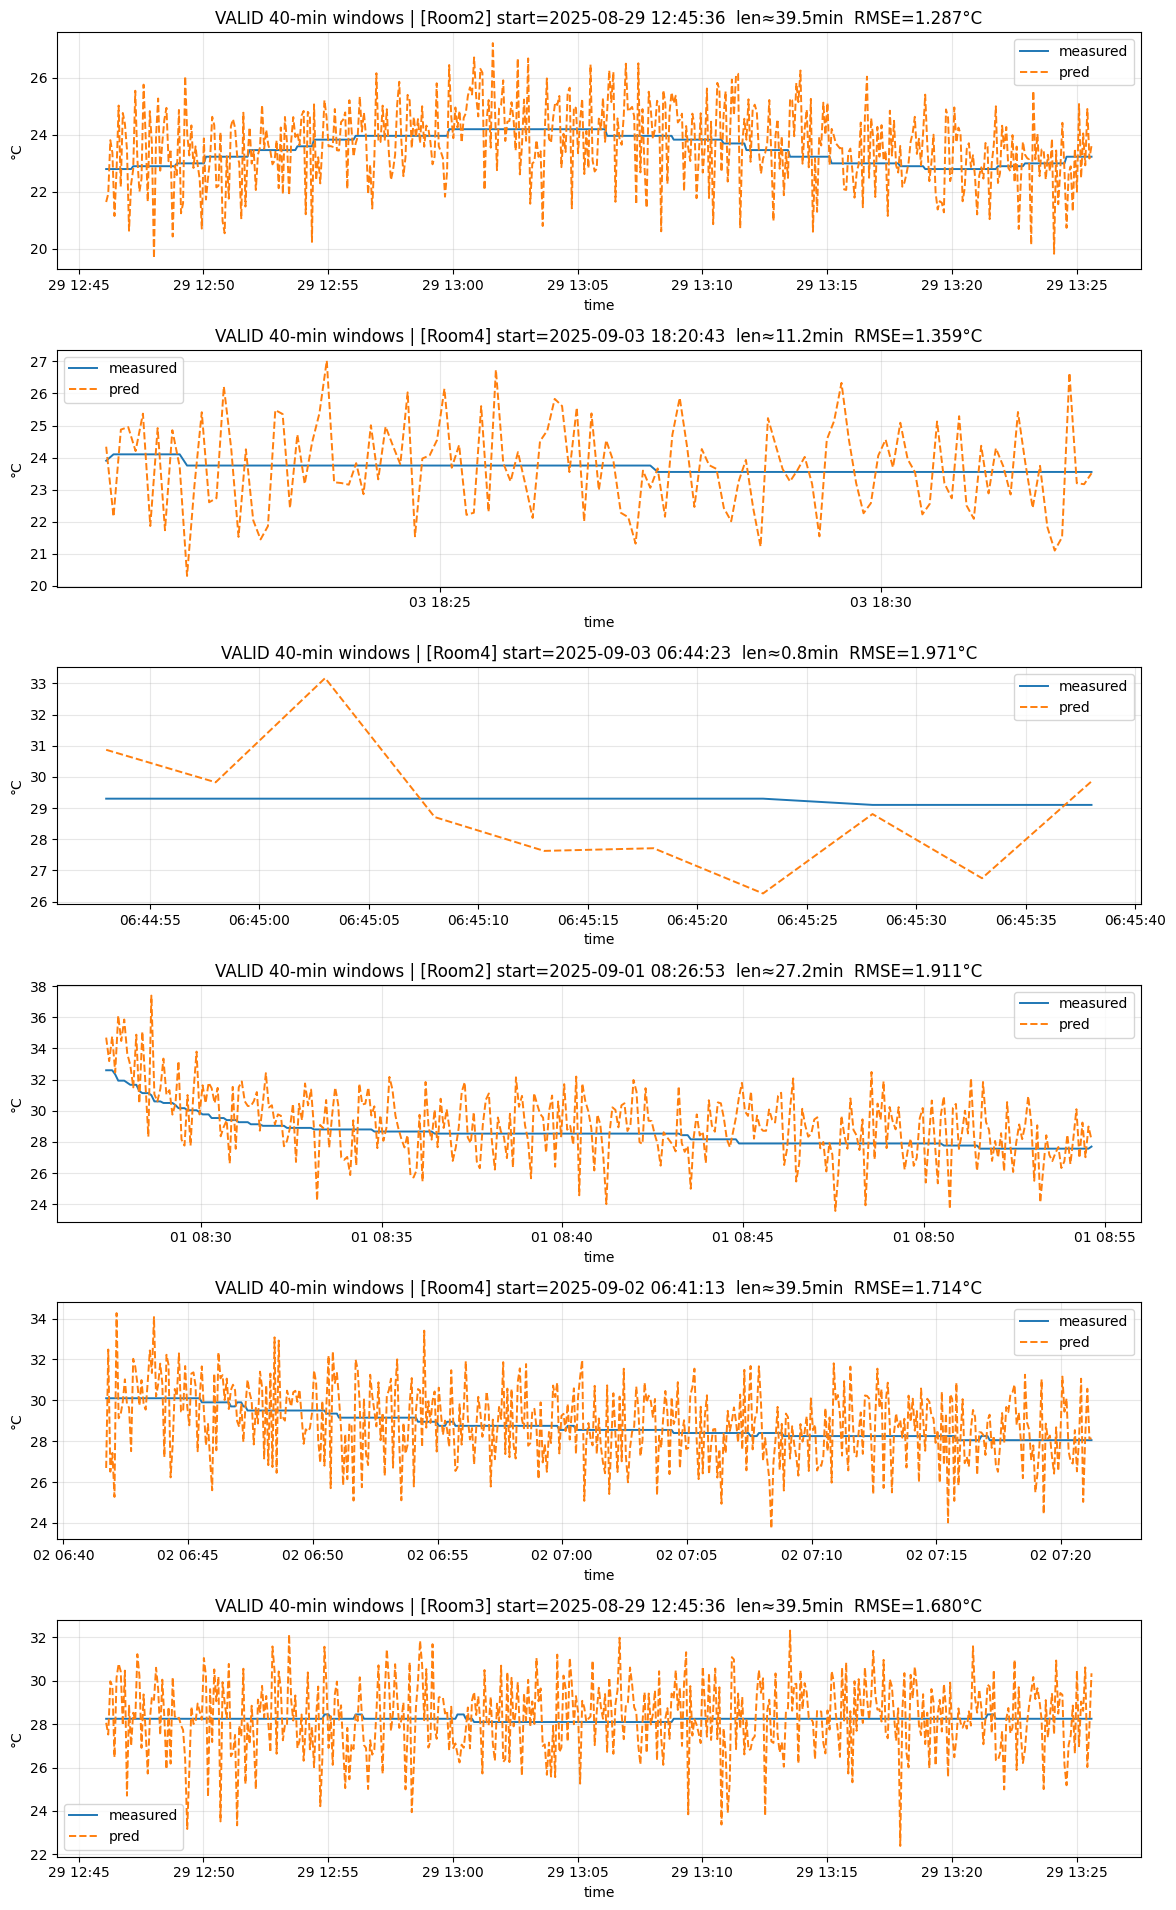

TRAIN: rooms_unified = (323653, 6)
TRAIN: windows = (103, 5)
       count      mean       std       min       25%       50%       75%  \
room                                                                       
Room1   25.0  1.712189  0.147765  1.429879  1.638056  1.715975  1.788219   
Room2   27.0  1.609712  0.229188  1.157192  1.474848  1.625669  1.701579   
Room3   24.0  1.656062  0.290333  0.847633  1.617757  1.718713  1.821489   
Room4   27.0  1.614307  0.141924  1.169236  1.542947  1.647846  1.706808   

            max  
room             
Room1  2.012976  
Room2  2.115738  
Room3  2.075842  
Room4  1.879721  


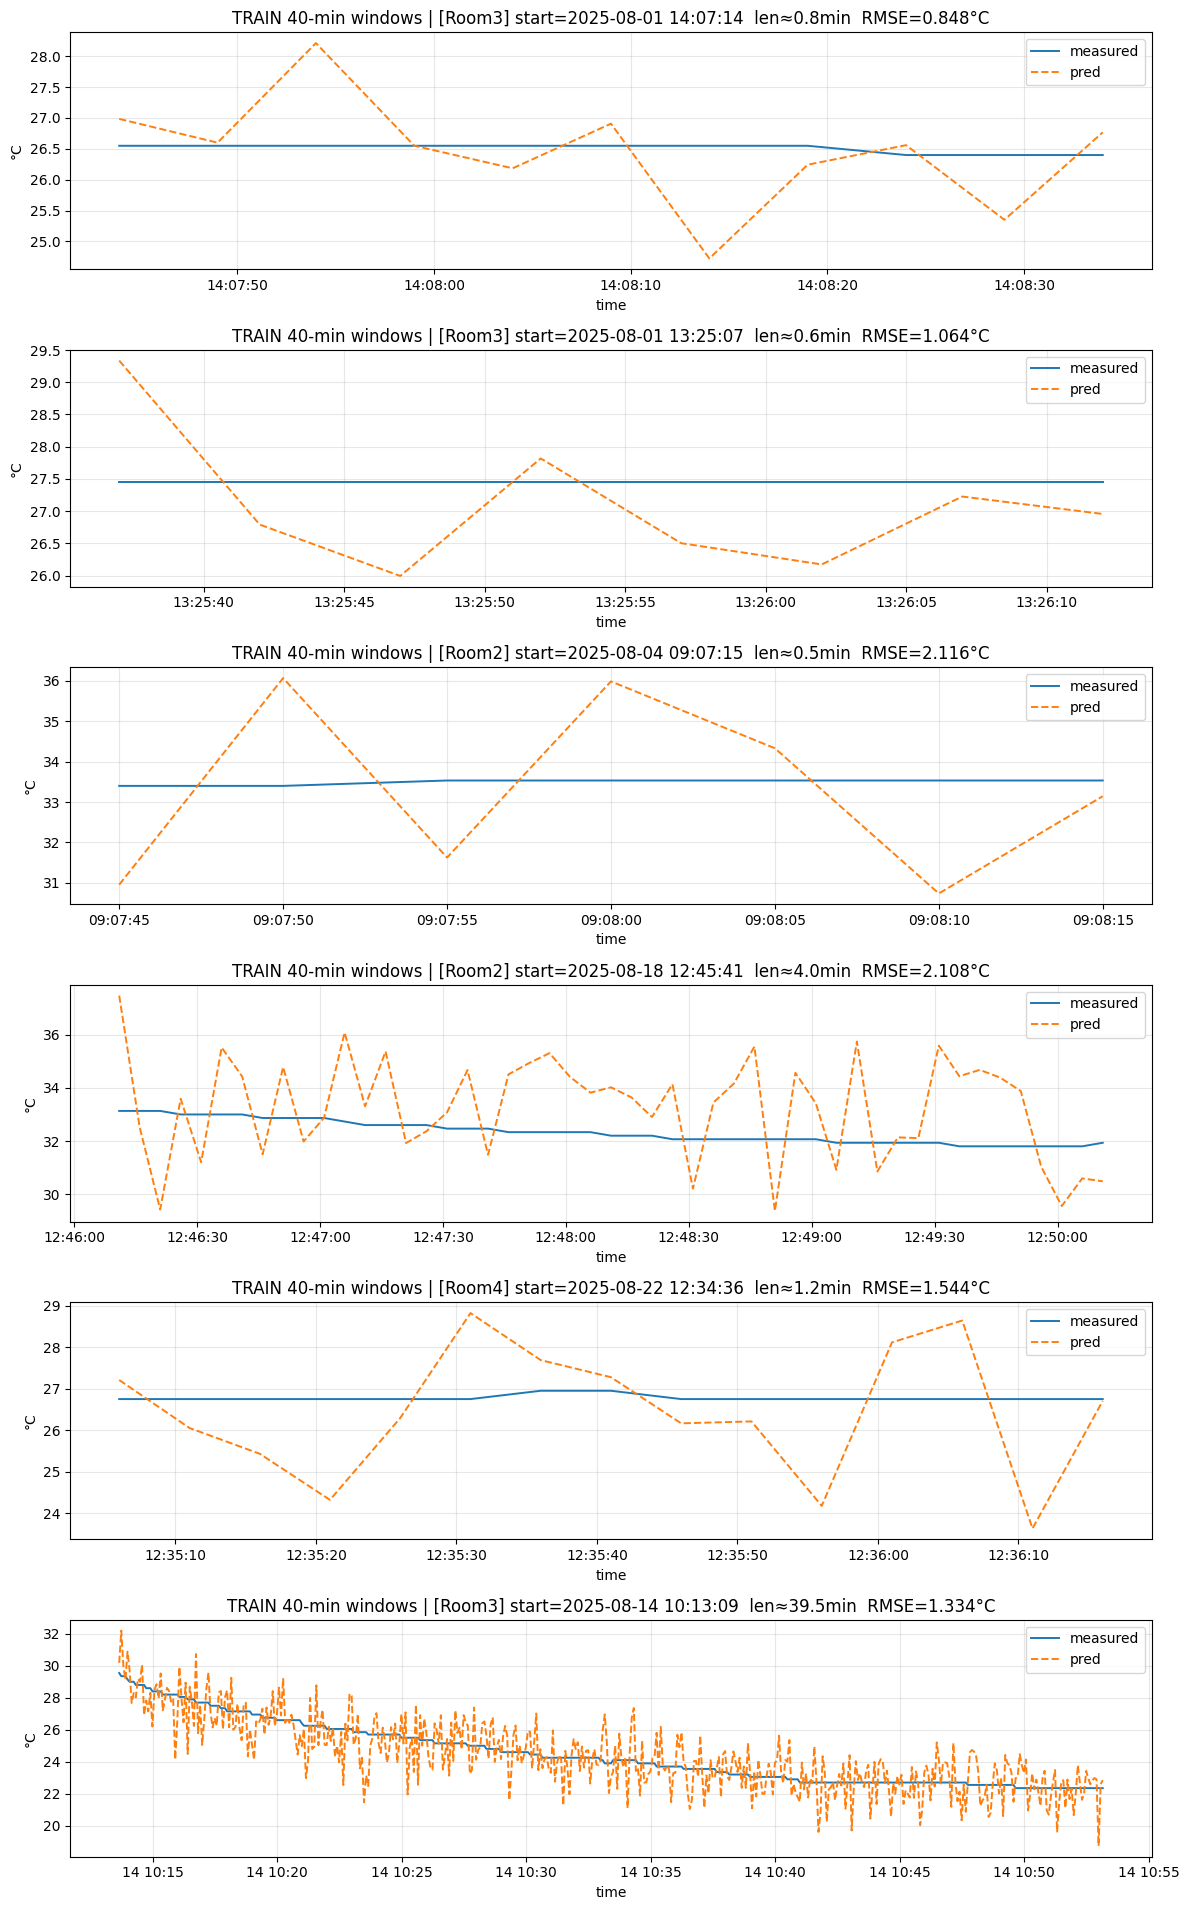

In [124]:
# ============================================================
# 40분 윈도우 평가 (VALID & TRAIN)
#  - 윈도우 기준: 세션 시작 ~ 40분, 5초 간격, 30초 ahead 라벨 존재하는 시점만
#  - 예측: 1-step(교사강제) 30초 ahead
#  - 출력: 요약 통계 + 베스트/워스트/랜덤 플롯
# 전제:
#  - 학습 완료된 ann, x_mean, x_std 가 메모리에 존재
#  - 전처리 유틸: load_all_csvs_schema_fixed, enrich_units,
#                 make_rooms_leakfree_for_ann, coerce_rooms_for_ann 존재
# ============================================================
import numpy as np, pandas as pd, matplotlib.pyplot as plt, torch, os

# ---- 경로/상수 ----
TRAIN_DIR = "/home/deok/Desktop/LOG_SMART_202508"
VALID_DIR = "/home/deok/Desktop/LOG_SMART_202508_valid"
TZ = "Asia/Seoul"
DELTA = 30.0
ROLL_MIN = 40

# ---- 가드: 학습 모델/스케일러 ----
assert 'ann' in globals(), "학습된 ann 가 필요합니다."
assert 'x_mean' in globals() and 'x_std' in globals(), "x_mean/x_std 가 필요합니다."
device = next(ann.parameters()).device

# ---- 시간 유틸 ----
def to_epoch_sec(ts):
    dt = pd.to_datetime(ts, utc=True)
    if isinstance(dt, (pd.Series, pd.Index, np.ndarray)):
        return pd.to_datetime(dt).astype("int64") // 10**9
    return int(pd.to_datetime(dt).value // 10**9)

def group_contiguous_5s(dts):
    t = to_epoch_sec(dts).values
    dt = np.diff(t, prepend=t[0])
    return np.cumsum(dt != 5)

# ---- 1-step 30s ahead 예측 함수 (학습 시 스케일러와 동일) ----
@torch.no_grad()
def ann_predict_30s_causal(T0, Tod0, Sm0, SmTb0):
    x = np.array([[T0, Tod0, Sm0, SmTb0]], dtype=np.float32)
    x = (x - x_mean)/x_std
    return float(ann(torch.from_numpy(x).to(device)).cpu().numpy().squeeze())

# ---- 공통: 윈도우 생성 & 평가 ----
def make_rollout_windows(df_rooms_unified, roll_min=40):
    rows, series = [], []
    for room, g in df_rooms_unified.groupby("room"):
        g = g.sort_values("datetime").copy()
        sid = group_contiguous_5s(g["datetime"])

        for _, seg in g.groupby(sid):
            if len(seg) < 7:  # 30s ahead라 최소 7포인트 필요
                continue
            tg = to_epoch_sec(seg["datetime"]).values.astype(float)
            t0, t_end = tg[0], tg[-1]
            t_stop = min(t0 + roll_min*60, t_end)

            # 예측 가능한 최대 i: tg[i+6] <= t_stop
            last_pred_idx = np.searchsorted(tg, t_stop, side='right') - 1
            max_i = min(len(seg) - 7, last_pred_idx - 6)
            if max_i < 0:
                continue

            T   = seg["T0"].values.astype(float)
            Tod = seg["Tod0"].values.astype(float)
            Sm  = seg["Smdot0"].values.astype(float)
            SmT = seg["SmdotTb0"].values.astype(float)

            t_pred, y_meas, y_hat = [], [], []
            for i in range(max_i + 1):
                yhat = ann_predict_30s_causal(T[i], Tod[i], Sm[i], SmT[i])  # 현재값만
                y    = T[i+6]                                              # 30s 뒤 실내온도
                tt   = tg[i+6]
                if np.any(np.isnan([yhat, y])): 
                    continue
                t_pred.append(tt); y_meas.append(y); y_hat.append(yhat)

            if len(y_meas) == 0:
                continue

            y_meas = np.asarray(y_meas); y_hat = np.asarray(y_hat)
            rmse = float(np.sqrt(np.mean((y_hat - y_meas)**2)))

            rows.append({
                "room": room,
                "start": pd.to_datetime(t0, unit="s", utc=True).tz_convert(TZ),
                "minutes": (t_pred[-1]-t_pred[0]) / 60.0,
                "n_points": len(y_meas),
                "rmse_C": rmse
            })
            series.append({
                "room": room,
                "time": pd.to_datetime(np.asarray(t_pred), unit="s", utc=True).tz_convert(TZ),
                "T_meas": y_meas,
                "T_pred": y_hat
            })
    return pd.DataFrame(rows), series

def plot_windows(series_list, summary_df, k_best=2, k_worst=2, k_rand=2, seed=42, title=""):
    if summary_df.empty:
        print("요약이 비어 있습니다."); return
    order = np.argsort(summary_df["rmse_C"].values)
    idx_best  = order[:min(k_best, len(order))]
    idx_worst = order[::-1][:min(k_worst, len(order))]
    rng = np.random.default_rng(seed)
    pool = list(set(range(len(series_list))) - set(idx_best) - set(idx_worst))
    idx_rand  = rng.choice(pool, size=min(k_rand, len(pool)), replace=False) if pool else []

    picks = list(idx_best) + list(idx_worst) + list(idx_rand)
    if len(picks) == 0:
        print("그릴 윈도우가 없습니다."); return

    plt.figure(figsize=(12, 3.2*len(picks)))
    for j, i in enumerate(picks, start=1):
        s = series_list[i]
        meta = summary_df.iloc[i]
        ax = plt.subplot(len(picks), 1, j)
        ax.plot(s["time"], s["T_meas"], label="measured", linewidth=1.4)
        ax.plot(s["time"], s["T_pred"], label="pred", linestyle="--", linewidth=1.4)
        ax.set_title(f"{title} | [{meta['room']}] start={meta['start']:%Y-%m-%d %H:%M:%S}  "
                     f"len≈{meta['minutes']:.1f}min  RMSE={meta['rmse_C']:.3f}°C")
        ax.set_xlabel("time"); ax.set_ylabel("°C"); ax.grid(True, alpha=0.3); ax.legend()
    plt.tight_layout(); plt.show()

def evaluate_dataset_40min_windows(root_dir, title_prefix="DATASET"):
    # 1) 로드 → 유닛 전처리 → 방 집계(누수 방지) → 스키마 통일
    df_units_raw = load_all_csvs_schema_fixed(root_dir, tz=TZ)
    df_units     = enrich_units(df_units_raw)
    df_rooms_lf  = make_rooms_leakfree_for_ann(df_units)         # [datetime, room, T0, Tod0, Smdot0, (Tbdy0 or SmdotTb0)]
    df_rooms_uni = coerce_rooms_for_ann(df_rooms_lf)             # [datetime, room, T0, Tod0, Smdot0, SmdotTb0]
    print(f"{title_prefix}: rooms_unified =", df_rooms_uni.shape)

    # 2) 윈도우 생성 & 평가
    summary, series = make_rollout_windows(df_rooms_uni, roll_min=ROLL_MIN)
    if summary.empty:
        print(f"{title_prefix}: 유효 윈도우 없음"); 
        return summary, series

    print(f"{title_prefix}: windows =", summary.shape)
    print(summary.groupby("room")["rmse_C"].describe())
    plot_windows(series, summary, k_best=2, k_worst=2, k_rand=2, seed=7, title=f"{title_prefix} 40-min windows")
    return summary, series

# =========================
# VALID 평가
# =========================
summary_valid, series_valid = evaluate_dataset_40min_windows(VALID_DIR, title_prefix="VALID")

# =========================
# TRAIN 평가
#  - 메모리에 df_rooms_LF/df_rooms가 있어도, 재현성을 위해
#    원본 TRAIN_DIR에서 다시 로드하여 동일 파이프라인 적용
# =========================
summary_train, series_train = evaluate_dataset_40min_windows(TRAIN_DIR, title_prefix="TRAIN")
